### ⚙️ BLOCO 1 — IMPORTS E CONFIGURAÇÕES

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict, List
import warnings
from scipy.stats import skew
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler, PowerTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, f1_score, roc_auc_score,
    silhouette_score, davies_bouldin_score, calinski_harabasz_score
)

try:
    import lightgbm as lgb
    HAS_LIGHTGBM = True
except ImportError:
    HAS_LIGHTGBM = False
    print("⚠️  LightGBM não instalado. Usando RandomForest como fallback.")

try:
    import shap
    HAS_SHAP = True
except ImportError:
    HAS_SHAP = False
    print("⚠️  SHAP não instalado. Usando feature importance padrão.")

import os
from typing import Dict
from google import genai
from google.genai import types as gt

GEMINI_API_KEY = "AQ.Ab8RN6IoBPuQQBT8hKnqyDaC1Id7Q6O5skkoblWry0EYiW0p8w"
GEMINI_MODEL = "gemini-2.0-flash-exp"

SEED = 42
np.random.seed(SEED)

plt.style.use('default')
sns.set_palette("husl")

print("✅ Imports concluídos!")
print(f"📦 LightGBM disponível: {HAS_LIGHTGBM}")
print(f"📦 SHAP disponível: {HAS_SHAP}")

✅ Imports concluídos!
📦 LightGBM disponível: True
📦 SHAP disponível: True


### 💾 BLOCO 2 — GERAÇÃO DE DADOS SINTÉTICOS

In [77]:
# Configurações de distribuição (ajustadas ao perfil real do banco)

PROPORCAO_BENEFICIOS = {
    'INSS': 0.60,              # ↑ Público majoritário: aposentados e pensionistas
    'Servidor Publico': 0.10,  # ↓ Segmento relevante, mas menor
    'CLT': 0.30                # ↓ Público minoritário
}

PARAMETROS_IDADE = {
    'INSS': {'media': 64, 'desvio': 8, 'min': 50, 'max': 90},             # ↑ Idade média mais alta
    'Servidor Publico': {'media': 46, 'desvio': 9, 'min': 30, 'max': 70}, # Perfil estável de meia idade
    'CLT': {'media': 33, 'desvio': 7, 'min': 18, 'max': 55}               # Jovens economicamente ativos
}

PARAMETROS_RENDA = {
    'INSS': {'shape': 2.2, 'scale': 600, 'min': 1200, 'max': 3500},       # ↓ Baixa renda predominante (~R$1.8k)
    'Servidor Publico': {'shape': 2.8, 'scale': 1400, 'min': 2500, 'max': 10000},  # Renda média (~R$4k-5k)
    'CLT': {'shape': 2.3, 'scale': 800, 'min': 1300, 'max': 5000}         # Intermediária (~R$2.5k)
}

TEMPO_CASA = {'shape': 2.5, 'scale': 25, 'min': 3, 'max': 240}            # ↑ Clientes mais antigos no banco

PROPORCAO_ESTADOS = {
    'MG': 0.50,  # 50% Minas Gerais
    'SP': 0.50   # 50% São Paulo
}

USO_CANAIS_POR_IDADE = {
    'idoso': {'whatsapp': 15, 'sms': 6, 'email': 2, 'app': 1},            # ↑ Preferência por WhatsApp e SMS
    'meia_idade': {'whatsapp': 12, 'email': 5, 'app': 4, 'sms': 3},       # Equilíbrio entre canais
    'jovem': {'app': 10, 'whatsapp': 8, 'email': 6, 'sms': 1}             # ↑ Uso digital elevado
}

PROB_PRODUTOS = {
    'INSS': {'tem_consignado': 0.8, 'tem_cartao': 0.3, 'tem_investimento': 0.05},   # ↑ Foco em consignado
    'Servidor Publico': {'tem_consignado': 0.6, 'tem_cartao': 0.5, 'tem_investimento': 0.2}, 
    'CLT': {'tem_consignado': 0.3, 'tem_cartao': 0.6, 'tem_investimento': 0.1}
}

PROB_INADIMPLENCIA = {
    'INSS': 0.04,                # ↓ Menor inadimplência (desconto em folha)
    'Servidor Publico': 0.08,    # Moderada
    'CLT': 0.15                  # ↑ Maior risco
}


In [78]:
NOMES_BRASILEIROS = {
    'masculino': [
        'José', 'João', 'Antonio', 'Francisco', 'Carlos', 'Paulo', 'Pedro', 
        'Lucas', 'Luiz', 'Marcos', 'Luis', 'Gabriel', 'Rafael', 'Daniel',
        'Marcelo', 'Bruno', 'Rodrigo', 'Fernando', 'Gustavo', 'Felipe',
        'Alexandre', 'Eduardo', 'Thiago', 'Diego', 'Leonardo', 'Matheus',
        'Anderson', 'Ricardo', 'Renato', 'Sergio', 'Roberto', 'Fabio'
    ],
    'feminino': [
        'Maria', 'Ana', 'Francisca', 'Antonia', 'Adriana', 'Juliana',
        'Marcia', 'Fernanda', 'Patricia', 'Aline', 'Claudia', 'Paula',
        'Camila', 'Amanda', 'Bruna', 'Carla', 'Daniela', 'Gabriela',
        'Larissa', 'Leticia', 'Luciana', 'Renata', 'Roberta', 'Sandra',
        'Silvia', 'Tatiana', 'Vanessa', 'Viviane', 'Beatriz', 'Carolina',
        'Cristina', 'Denise', 'Elaine', 'Fabiana', 'Monica', 'Priscila'
    ]  
}

SOBRENOMES_BRASILEIROS = [
    'Silva', 'Santos', 'Oliveira', 'Souza', 'Rodrigues', 'Ferreira', 'Alves',
    'Pereira', 'Lima', 'Gomes', 'Costa', 'Ribeiro', 'Martins', 'Carvalho',
    'Rocha', 'Almeida', 'Lopes', 'Soares', 'Fernandes', 'Vieira', 'Barbosa',
    'Araújo', 'Castro', 'Cardoso', 'Correia', 'Dias', 'Teixeira', 'Cavalcanti',
    'Monteiro', 'Freitas', 'Nascimento', 'Moreira', 'Mendes', 'Barros', 'Pinto',
    'Cunha', 'Nunes', 'Moraes', 'Ramos', 'Azevedo', 'Campos', 'Batista', 'Machado',
    'Reis', 'Sales', 'Farias', 'Pires', 'Duarte', 'Melo', 'Coelho', 'Miranda',
    'Neves', 'Castro', 'Viana', 'Rezende', 'Amaral', 'Fonseca', 'Marques',
    'Tavares', 'Cruz', 'Matos', 'Xavier', 'Nogueira', 'Guimarães', 'Santiago'
]

In [79]:
def gerar_tipo_beneficio(n_clientes: int) -> np.ndarray:
    tipos = list(PROPORCAO_BENEFICIOS.keys())
    probabilidades = list(PROPORCAO_BENEFICIOS.values())
    return np.random.choice(tipos, size=n_clientes, p=probabilidades)


def gerar_idade(tipo_beneficio: np.ndarray) -> np.ndarray:
    n_clientes = len(tipo_beneficio)
    idade = np.zeros(n_clientes)
    for i, tipo in enumerate(tipo_beneficio):
        params = PARAMETROS_IDADE[tipo]
        idade[i] = np.clip(np.random.normal(params['media'], params['desvio']), params['min'], params['max'])
    return idade.astype(int)


def gerar_renda(tipo_beneficio: np.ndarray) -> np.ndarray:
    n_clientes = len(tipo_beneficio)
    renda_mensal = np.zeros(n_clientes)
    for i, tipo in enumerate(tipo_beneficio):
        params = PARAMETROS_RENDA[tipo]
        renda_mensal[i] = np.clip(np.random.gamma(params['shape'], params['scale']), params['min'], params['max'])
    return renda_mensal.round(2)


def gerar_tempo_casa(n_clientes: int) -> np.ndarray:
    tempo = np.random.gamma(TEMPO_CASA['shape'], TEMPO_CASA['scale'], n_clientes).astype(int)
    return np.clip(tempo, TEMPO_CASA['min'], TEMPO_CASA['max'])

def gerar_localizacao(n_clientes: int) -> np.ndarray:
    # Gerar estados
    estados_lista = list(PROPORCAO_ESTADOS.keys())
    estados_prob = list(PROPORCAO_ESTADOS.values())
    estados = np.random.choice(estados_lista, size=n_clientes, p=estados_prob)
    return estados

def gerar_uso_canais(idade: np.ndarray) -> dict:
    n_clientes = len(idade)
    uso_whatsapp = np.zeros(n_clientes)
    uso_email = np.zeros(n_clientes)
    uso_app = np.zeros(n_clientes)
    uso_sms = np.zeros(n_clientes)
    
    for i in range(n_clientes):
        if idade[i] >= 60:
            perfil = 'idoso'
        elif idade[i] >= 40:
            perfil = 'meia_idade'
        else:
            perfil = 'jovem'
        
        params = USO_CANAIS_POR_IDADE[perfil]
        uso_whatsapp[i] = np.random.poisson(params['whatsapp'])
        uso_email[i] = np.random.poisson(params['email'])
        uso_app[i] = np.random.poisson(params['app'])
        uso_sms[i] = np.random.poisson(params['sms'])
    
    return {
        'uso_whatsapp': uso_whatsapp.astype(int),
        'uso_email': uso_email.astype(int),
        'uso_app': uso_app.astype(int),
        'uso_sms': uso_sms.astype(int)
    }


def gerar_produtos(tipo_beneficio: np.ndarray) -> dict:
    n_clientes = len(tipo_beneficio)
    tem_consignado = np.zeros(n_clientes)
    tem_cartao = np.zeros(n_clientes)
    tem_investimento = np.zeros(n_clientes)
    
    for i, tipo in enumerate(tipo_beneficio):
        probs = PROB_PRODUTOS[tipo]
        tem_consignado[i] = np.random.choice([0, 1], p=[1 - probs['tem_consignado'], probs['tem_consignado']])
        tem_cartao[i] = np.random.choice([0, 1], p=[1 - probs['tem_cartao'], probs['tem_cartao']])
        tem_investimento[i] = np.random.choice([0, 1], p=[1 - probs['tem_investimento'], probs['tem_investimento']])
    
    return {
        'tem_consignado': tem_consignado.astype(int),
        'tem_cartao': tem_cartao.astype(int),
        'tem_investimento': tem_investimento.astype(int)
    }


def gerar_inadimplencia(tipo_beneficio: np.ndarray) -> np.ndarray:
    n_clientes = len(tipo_beneficio)
    inadimplente = np.zeros(n_clientes)
    for i, tipo in enumerate(tipo_beneficio):
        prob_inadimplente = PROB_INADIMPLENCIA[tipo]
        inadimplente[i] = np.random.choice([0, 1], p=[1 - prob_inadimplente, prob_inadimplente])
    return inadimplente.astype(int)

def gerar_targets_historicos(tipo_beneficio: np.ndarray, produtos: dict, 
                                        uso_canais: dict, idade: np.ndarray) -> tuple:
    """
    Gera targets com aleatoriedade realista para evitar data leakage.
    
    MUDANÇAS:
    - Adiciona ruído de 20% nas decisões
    - Considera múltiplos fatores (não apenas uso direto)
    - Simula comportamento humano imprevisível
    """
    n_clientes = len(tipo_beneficio)
    produto_alvo = []
    canal_resposta = []
    
    for i in range(n_clientes):
        # ========== PRODUTO ALVO ==========
        # Lógica base (80% dos casos)
        if np.random.random() < 0.8:
            if tipo_beneficio[i] == 'INSS' and produtos['tem_consignado'][i] == 0:
                produto = np.random.choice(['consignado', 'cartao'], p=[0.75, 0.25])
            elif tipo_beneficio[i] == 'Servidor Publico' and produtos['tem_investimento'][i] == 0:
                produto = np.random.choice(['investimento', 'consignado', 'cartao'], p=[0.5, 0.3, 0.2])
            elif tipo_beneficio[i] == 'CLT' and produtos['tem_cartao'][i] == 0:
                produto = np.random.choice(['cartao', 'investimento', 'consignado'], p=[0.6, 0.25, 0.15])
            else:
                produto = np.random.choice(['consignado', 'cartao', 'investimento'], 
                                          p=[0.45, 0.35, 0.20])
        # Ruído (20% dos casos) - comportamento imprevisível
        else:
            produto = np.random.choice(['consignado', 'cartao', 'investimento'])
        
        produto_alvo.append(produto)
        
        # ========== CANAL RESPOSTA ==========
        # Fatores múltiplos (não apenas uso direto)
        canais = ['whatsapp', 'email', 'app', 'sms']
        
        # Base: uso dos canais (peso 50%)
        usos = np.array([
            uso_canais['uso_whatsapp'][i],
            uso_canais['uso_email'][i],
            uso_canais['uso_app'][i],
            uso_canais['uso_sms'][i]
        ], dtype=float) + 1
        
        # Fator idade (peso 30%)
        if idade[i] >= 60:
            idade_fator = np.array([1.5, 0.5, 0.3, 1.2])  # Prefere WhatsApp/SMS
        elif idade[i] >= 40:
            idade_fator = np.array([1.2, 1.0, 0.8, 0.7])  # Equilibrado
        else:
            idade_fator = np.array([1.0, 0.8, 1.5, 0.4])  # Prefere App
        
        # Fator tipo de benefício (peso 20%)
        if tipo_beneficio[i] == 'INSS':
            beneficio_fator = np.array([1.3, 0.6, 0.5, 1.1])
        elif tipo_beneficio[i] == 'Servidor Publico':
            beneficio_fator = np.array([1.0, 1.2, 1.1, 0.7])
        else:  # CLT
            beneficio_fator = np.array([1.1, 0.9, 1.3, 0.6])
        
        # Combinar fatores
        probs = (usos ** 0.5) * (idade_fator ** 0.3) * (beneficio_fator ** 0.2)
        
        # Adicionar ruído (15% de aleatoriedade total)
        if np.random.random() < 0.15:
            probs = np.ones(4)  # Escolha completamente aleatória
        
        # Normalizar
        probs = probs / probs.sum()
        
        # Garantir probabilidades válidas
        probs = np.clip(probs, 0.01, 1.0)
        probs = probs / probs.sum()
        
        canal = np.random.choice(canais, p=probs)
        canal_resposta.append(canal)
    
    return produto_alvo, canal_resposta

def gerar_nomes_clientes(n_clientes: int, estados: np.ndarray, idades: np.ndarray) -> np.ndarray:
    """
    Gera nomes completos realistas para clientes brasileiros.
    
    Args:
        n_clientes: Número de clientes
        estados: Array com estados (SP/MG)
        idades: Array com idades (para definir probabilidade de gênero)
    
    Returns:
        Array com nomes completos
    """
    nomes_completos = []
    
    for i in range(n_clientes):
        estado = estados[i]
        idade = idades[i]
        
        # Determinar gênero (50/50 com leve variação por idade)
        # Clientes mais velhos: maior probabilidade de nomes tradicionais
        if idade >= 60:
            usa_feminino = np.random.random() < 0.48  # Leve predominância masculina em idosos
        else:
            usa_feminino = np.random.random() < 0.52  # Leve predominância feminina em jovens
        
        genero = 'feminino' if usa_feminino else 'masculino'
        
        # Selecionar primeiro nome
        if estado in NOMES_BRASILEIROS:
            primeiro_nome = np.random.choice(NOMES_BRASILEIROS[genero])
        else:
            # Fallback para SP se estado não existir
            primeiro_nome = np.random.choice(NOMES_BRASILEIROS[genero])
        
        # Decidir se terá nome composto (30% de chance)
        if np.random.random() < 0.30:
            segundo_nome = np.random.choice(NOMES_BRASILEIROS[genero])
            nome = f"{primeiro_nome} {segundo_nome}"
        else:
            nome = primeiro_nome
        
        # Selecionar sobrenome(s)
        # 70% chance de sobrenome simples, 30% de sobrenome composto
        if np.random.random() < 0.70:
            sobrenome = np.random.choice(SOBRENOMES_BRASILEIROS)
        else:
            sobrenome1 = np.random.choice(SOBRENOMES_BRASILEIROS)
            sobrenome2 = np.random.choice(SOBRENOMES_BRASILEIROS)
            # Evitar sobrenomes duplicados
            while sobrenome2 == sobrenome1:
                sobrenome2 = np.random.choice(SOBRENOMES_BRASILEIROS)
            sobrenome = f"{sobrenome1} {sobrenome2}"
        
        # Nome completo
        nome_completo = f"{nome} {sobrenome}"
        nomes_completos.append(nome_completo)
    
    return np.array(nomes_completos)

def gerar_dados_sinteticos(n_clientes: int = 20000) -> pd.DataFrame:
    """Versão corrigida da geração de dados sintéticos."""
    np.random.seed(SEED)
    
    tipo_beneficio = gerar_tipo_beneficio(n_clientes)
    idade = gerar_idade(tipo_beneficio)
    renda_mensal = gerar_renda(tipo_beneficio)
    tempo_de_casa_meses = gerar_tempo_casa(n_clientes)
    estado = gerar_localizacao(n_clientes)
    uso_canais = gerar_uso_canais(idade)
    produtos = gerar_produtos(tipo_beneficio)
    inadimplente_historico = gerar_inadimplencia(tipo_beneficio)
    
    # ✅ CORREÇÃO: Usar função corrigida
    produto_alvo, canal_resposta = gerar_targets_historicos(
        tipo_beneficio, produtos, uso_canais, idade
    )
    
    df = pd.DataFrame({
        'cliente_id': [f'CLI_{i:06d}' for i in range(n_clientes)],
        'nome_cliente': gerar_nomes_clientes(n_clientes, estado, idade),
        'idade': idade,
        'estado': estado,
        'renda_mensal': renda_mensal,
        'tempo_de_casa_meses': tempo_de_casa_meses,
        'estado': estado,
        'tipo_beneficio': tipo_beneficio,
        **uso_canais,
        **produtos,
        'inadimplente_historico': inadimplente_historico,
        'produto_alvo_historico': produto_alvo,
        'canal_resposta_historico': canal_resposta
    })
    
    return df

In [80]:
df = gerar_dados_sinteticos(n_clientes=20000)

print(f"✅ Dados gerados: {len(df):,} clientes")
print(f"\n📊 Primeiras linhas:")
print(df.head(10))
print(f"\n📈 Estatísticas descritivas:")
print(df.describe())
print(f"\n🎯 Distribuição de produtos alvo:")
print(df['produto_alvo_historico'].value_counts())
print(f"\n📱 Distribuição de canais:")
print(df['canal_resposta_historico'].value_counts())

✅ Dados gerados: 20,000 clientes

📊 Primeiras linhas:
   cliente_id                       nome_cliente  idade estado  renda_mensal  \
0  CLI_000000              Adriana Neves Martins     57     MG       1655.02   
1  CLI_000001                     Sandra Fonseca     37     SP       1752.63   
2  CLI_000002  Carlos Thiago Cavalcanti Teixeira     42     MG       2271.95   
3  CLI_000003             Priscila Gomes Marques     54     SP       1200.00   
4  CLI_000004                   Antonio Monteiro     77     MG       1200.00   
5  CLI_000005                  Alexandre Moreira     62     MG       1200.00   
6  CLI_000006                      Carlos Castro     56     MG       1499.87   
7  CLI_000007                    Eduardo Martins     38     SP       1628.90   
8  CLI_000008                    Ricardo Moreira     41     MG       3073.14   
9  CLI_000009                      Marcia Campos     32     MG       1444.27   

   tempo_de_casa_meses    tipo_beneficio  uso_whatsapp  uso_email

### 👷🏽‍♂️ BLOCO 3 — FEATURE ENGINEERING

In [81]:
def criar_features_comportamentais(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    df['uso_digital_total'] = df['uso_whatsapp'] + df['uso_email'] + df['uso_app'] + df['uso_sms']
    
    digital = df['uso_app'] + df['uso_email']
    tradicional = df['uso_whatsapp'] + df['uso_sms']
    df['preferencia_digital'] = (digital - tradicional) / (df['uso_digital_total'] + 1)
    
    for canal in ['whatsapp', 'email', 'app', 'sms']:
        df[f'taxa_uso_{canal}'] = df[f'uso_{canal}'] / (df['uso_digital_total'] + 1)
    
    canais = ['uso_whatsapp', 'uso_email', 'uso_app', 'uso_sms']
    df['canal_dominante'] = df[canais].values.argmax(axis=1)
    
    def calcular_entropia(row):
        valores = np.array(row[canais].values, dtype=float) + 1
        proporcoes = valores / valores.sum()
        entropia = -np.sum(proporcoes * np.log(proporcoes + 1e-10)) / np.log(2)
        return entropia
    
    df['diversificacao_canais'] = df.apply(calcular_entropia, axis=1)
    df['intensidade_uso'] = pd.cut(df['uso_digital_total'], bins=[0, 10, 30, np.inf], labels=['baixo', 'medio', 'alto'])
    
    return df


def criar_features_produtos(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    df['qtd_produtos'] = df['tem_consignado'] + df['tem_cartao'] + df['tem_investimento']
    df['perfil_produtos'] = (df['tem_consignado'].astype(str) + 
                             df['tem_cartao'].astype(str) + 
                             df['tem_investimento'].astype(str))
    
    tempo_norm = df['tempo_de_casa_meses'] / df['tempo_de_casa_meses'].max()
    produtos_norm = df['qtd_produtos'] / 3
    inadimplencia_norm = 1 - df['inadimplente_historico']
    
    df['score_relacionamento'] = (0.40 * tempo_norm + 0.35 * produtos_norm + 0.25 * inadimplencia_norm)
    df['potencial_crosssell'] = (df['qtd_produtos'].isin([1, 2])).astype(int)
    df['e_monoproduto'] = (df['qtd_produtos'] == 1).astype(int)
    
    df['e_premium'] = (
        (df['renda_mensal'] > df['renda_mensal'].quantile(0.75)) & 
        (df['qtd_produtos'] >= 2) & 
        (df['inadimplente_historico'] == 0) &
        (df['tempo_de_casa_meses'] >= 24)
    ).astype(int)
    
    return df


def criar_features_demograficas(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    df['faixa_etaria'] = pd.cut(df['idade'], bins=[0, 30, 40, 50, 60, 100], 
                                 labels=['jovem', 'adulto_jovem', 'meia_idade', 'pre_idoso', 'idoso'])
    df['e_idoso'] = (df['idade'] >= 60).astype(int)
    df['e_jovem'] = (df['idade'] < 35).astype(int)
    
    try:
        df['faixa_renda'] = pd.qcut(df['renda_mensal'], q=4, 
                                    labels=['baixa', 'media_baixa', 'media_alta', 'alta'], duplicates='drop')
    except ValueError:
        df['faixa_renda'] = pd.cut(df['renda_mensal'], bins=[0, 2000, 4000, 8000, np.inf], 
                                   labels=['baixa', 'media_baixa', 'media_alta', 'alta'])
    
    renda_min = df['renda_mensal'].min()
    renda_max = df['renda_mensal'].max()
    
    if renda_max > renda_min:
        df['poder_aquisitivo'] = (df['renda_mensal'] - renda_min) / (renda_max - renda_min)
    else:
        df['poder_aquisitivo'] = 0.5
    
    df['tempo_casa_anos'] = df['tempo_de_casa_meses'] / 12
    df['cliente_novo'] = (df['tempo_de_casa_meses'] < 12).astype(int)
    df['cliente_veterano'] = (df['tempo_de_casa_meses'] >= 60).astype(int)
    df['ciclo_vida'] = pd.cut(df['tempo_casa_anos'], bins=[0, 1, 3, 5, np.inf], 
                              labels=['novo', 'estabelecido', 'maduro', 'veterano'])
    
    return df


def criar_features_interacoes(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    df['idade_x_uso_app'] = df['idade'] * df['uso_app']
    df['idade_x_uso_whatsapp'] = df['idade'] * df['uso_whatsapp']
    df['renda_x_qtd_produtos'] = df['renda_mensal'] * df['qtd_produtos']
    df['renda_x_investimento'] = df['renda_mensal'] * df['tem_investimento']
    df['inadimplencia_x_renda'] = df['inadimplente_historico'] * df['renda_mensal']
    df['tempo_x_produtos'] = df['tempo_de_casa_meses'] * df['qtd_produtos']
    
    df['valor_cliente'] = (
        df['renda_mensal'] * 
        np.log1p(df['tempo_de_casa_meses']) *
        (df['qtd_produtos'] + 1) *
        (1 - df['inadimplente_historico'])
    )
    
    df['valor_cliente_norm'] = (df['valor_cliente'] - df['valor_cliente'].min()) / \
                                (df['valor_cliente'].max() - df['valor_cliente'].min())
    
    return df


def criar_features_estatisticas(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    for col in ['renda_mensal', 'uso_digital_total', 'qtd_produtos']:
        media_grupo = df.groupby('tipo_beneficio')[col].transform('mean')
        std_grupo = df.groupby('tipo_beneficio')[col].transform('std')
        df[f'{col}_zscore'] = (df[col] - media_grupo) / (std_grupo + 1e-10)
    
    df['e_outlier_renda'] = (abs(df['renda_mensal_zscore']) > 2).astype(int)
    df['e_outlier_uso'] = (abs(df['uso_digital_total_zscore']) > 2).astype(int)
    
    canais = ['uso_whatsapp', 'uso_email', 'uso_app', 'uso_sms']
    df['assimetria_canais'] = df[canais].apply(lambda row: skew(row.values + 1), axis=1)
    
    return df


def encodar_categorias(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    categorias_ordinal = {
        'tipo_beneficio': LabelEncoder(),
        'faixa_renda': LabelEncoder(),
        'faixa_etaria': LabelEncoder(),
        'ciclo_vida': LabelEncoder(),
        'intensidade_uso': LabelEncoder(),
        'perfil_produtos': LabelEncoder()
    }
    
    for col, encoder in categorias_ordinal.items():
        if col in df.columns:
            df[f'{col}_encoded'] = encoder.fit_transform(df[col].astype(str))
    
    return df


def criar_features(df: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
    if verbose:
        print("🔧 Iniciando engenharia de features...")
        print(f"   Shape inicial: {df.shape}")
    
    df = criar_features_comportamentais(df)
    if verbose:
        print("   ✅ Features comportamentais criadas")
    
    df = criar_features_produtos(df)
    if verbose:
        print("   ✅ Features de produtos criadas")
    
    df = criar_features_demograficas(df)
    if verbose:
        print("   ✅ Features demográficas criadas")
    
    df = criar_features_interacoes(df)
    if verbose:
        print("   ✅ Features de interação criadas")
    
    df = criar_features_estatisticas(df)
    if verbose:
        print("   ✅ Features estatísticas criadas")
    
    df = encodar_categorias(df)
    if verbose:
        print("   ✅ Encoding de categorias aplicado")
    
    if verbose:
        print(f"\n✅ FEATURE ENGINEERING CONCLUÍDA")
        print(f"   Shape final: {df.shape}")
        print(f"   Novas features criadas: {df.shape[1] - 15}")
    
    return df


In [82]:
# Aplicar feature engineering
df = criar_features(df, verbose=True)

print(f"\n📊 Amostra de features importantes:")
features_importantes = ['cliente_id', 'uso_digital_total', 'preferencia_digital', 
                       'score_relacionamento', 'valor_cliente_norm', 'e_premium']
print(df[features_importantes].head(10))

🔧 Iniciando engenharia de features...
   Shape inicial: (20000, 17)
   ✅ Features comportamentais criadas
   ✅ Features de produtos criadas
   ✅ Features demográficas criadas
   ✅ Features de interação criadas
   ✅ Features estatísticas criadas
   ✅ Encoding de categorias aplicado

✅ FEATURE ENGINEERING CONCLUÍDA
   Shape final: (20000, 61)
   Novas features criadas: 46

📊 Amostra de features importantes:
   cliente_id  uso_digital_total  preferencia_digital  score_relacionamento  \
0  CLI_000000                 36            -0.162162              0.473333   
1  CLI_000001                 19             0.150000              0.265000   
2  CLI_000002                 25            -0.115385              0.431667   
3  CLI_000003                 28            -0.482759              0.608333   
4  CLI_000004                 24            -0.640000              0.440000   
5  CLI_000005                 20            -0.666667              0.546667   
6  CLI_000006                 33      

### 🧑🏽‍🧑🏼‍🧒🏿 BLOCO 4 — CLUSTERIZAÇÃO (K-MEANS + AVALIAÇÃO)


🚀 PIPELINE DE CLUSTERIZAÇÃO MELHORADO V2

🔍 Seleção rigorosa de features...
   ✅ 14 features core selecionadas

📋 Features para clustering:
       1. idade
       2. renda_mensal
       3. tipo_beneficio_encoded
       4. uso_digital_total
       5. preferencia_digital
       6. qtd_produtos
       7. tem_consignado
       8. tem_investimento
       9. tempo_de_casa_meses
      10. score_relacionamento
      11. inadimplente_historico
      12. valor_cliente_norm
      13. e_premium
      14. e_idoso

🔧 Pré-processamento avançado...
   ✅ RobustScaler aplicado (resistente a outliers)
   📊 Shape final: (20000, 14)

🔬 Aplicando PCA (mantendo 85% da variância)...
   ✅ Reduzido de 14 para 5 componentes
   📊 Variância explicada: 88.74%

   📈 Variância por componente (top 5):
      PC1: 40.00%
      PC2: 18.67%
      PC3: 12.66%
      PC4: 8.89%
      PC5: 8.52%

🔍 BUSCA INTELIGENTE DO MELHOR K

📊 Testando diferentes valores de k...

   Testando k=3... Sil=0.226, DB=1.468, CH=6668
   Testand

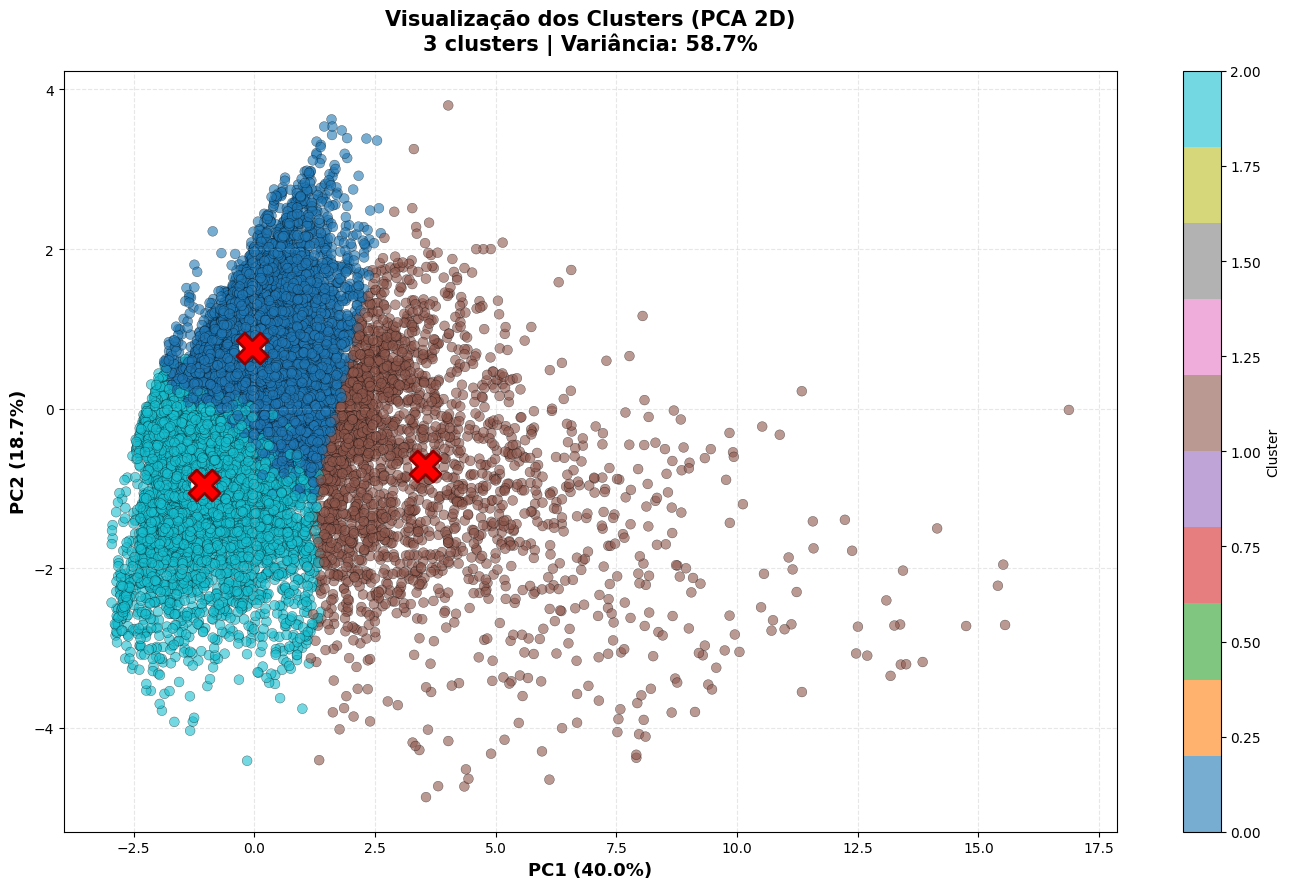

In [83]:
def selecionar_features_melhoradas(df: pd.DataFrame) -> List[str]:
    print("\n🔍 Seleção rigorosa de features...")
    
    features_core = [
        'idade',
        'renda_mensal',
        'tipo_beneficio_encoded',
        'uso_digital_total',
        'preferencia_digital',
        'qtd_produtos',
        'tem_consignado',
        'tem_investimento',
        'tempo_de_casa_meses',
        'score_relacionamento',
        'inadimplente_historico',
        'valor_cliente_norm',
        'e_premium',
        'e_idoso',
    ]
    
    features_disponiveis = [f for f in features_core if f in df.columns]
    
    print(f"   ✅ {len(features_disponiveis)} features core selecionadas")
    print(f"\n📋 Features para clustering:")
    for i, feat in enumerate(features_disponiveis, 1):
        print(f"      {i:2d}. {feat}")
    
    return features_disponiveis


def preprocessar_dados_avancado(df: pd.DataFrame, features: List[str], metodo_scaling: str = 'robust') -> Tuple[np.ndarray, StandardScaler]:
    print("\n🔧 Pré-processamento avançado...")
    
    X = df[features].copy()
    
    for col in X.columns:
        if X[col].isna().any():
            mediana = X[col].median()
            X[col].fillna(mediana, inplace=True)
            print(f"   ℹ️  {col}: NaNs preenchidos com mediana ({mediana:.2f})")
    
    X_array = X.values
    
    if metodo_scaling == 'robust':
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(X_array)
        print(f"   ✅ RobustScaler aplicado (resistente a outliers)")
    elif metodo_scaling == 'power':
        scaler = PowerTransformer(method='yeo-johnson', standardize=True)
        X_scaled = scaler.fit_transform(X_array)
        print(f"   ✅ PowerTransformer aplicado (normalização gaussiana)")
    else:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_array)
        print(f"   ✅ StandardScaler aplicado")
    
    print(f"   📊 Shape final: {X_scaled.shape}")
    
    return X_scaled, scaler


def aplicar_pca_pre_clustering(X_scaled: np.ndarray, variancia_explicada: float = 0.90) -> Tuple[np.ndarray, PCA]:
    print(f"\n🔬 Aplicando PCA (mantendo {variancia_explicada:.0%} da variância)...")
    
    pca = PCA(n_components=variancia_explicada, random_state=SEED)
    X_pca = pca.fit_transform(X_scaled)
    
    n_components = pca.n_components_
    var_total = pca.explained_variance_ratio_.sum()
    
    print(f"   ✅ Reduzido de {X_scaled.shape[1]} para {n_components} componentes")
    print(f"   📊 Variância explicada: {var_total:.2%}")
    print(f"\n   📈 Variância por componente (top 5):")
    for i, var in enumerate(pca.explained_variance_ratio_[:5], 1):
        print(f"      PC{i}: {var:.2%}")
    
    return X_pca, pca


def treinar_kmeans_otimizado(X_scaled: np.ndarray, k: int, n_tentativas: int = 100) -> KMeans:
    kmeans = KMeans(
        n_clusters=k,
        init='k-means++',
        n_init=n_tentativas,
        max_iter=1000,
        tol=1e-6,
        random_state=SEED,
        algorithm='lloyd'
    )
    
    kmeans.fit(X_scaled)
    
    return kmeans


def encontrar_melhor_k_melhorado(X_scaled: np.ndarray, k_min: int = 3, k_max: int = 8) -> Tuple[int, Dict]:
    print("\n" + "="*80)
    print("🔍 BUSCA INTELIGENTE DO MELHOR K")
    print("="*80)
    
    metricas = {
        'k': [],
        'silhouette': [],
        'davies_bouldin': [],
        'calinski_harabasz': [],
        'inertia': []
    }
    
    print("\n📊 Testando diferentes valores de k...\n")
    
    for k in range(k_min, k_max + 1):
        print(f"   Testando k={k}...", end=" ")
        
        kmeans = treinar_kmeans_otimizado(X_scaled, k, n_tentativas=50)
        labels = kmeans.labels_
        
        sil = silhouette_score(X_scaled, labels)
        db = davies_bouldin_score(X_scaled, labels)
        ch = calinski_harabasz_score(X_scaled, labels)
        
        metricas['k'].append(k)
        metricas['silhouette'].append(sil)
        metricas['davies_bouldin'].append(db)
        metricas['calinski_harabasz'].append(ch)
        metricas['inertia'].append(kmeans.inertia_)
        
        print(f"Sil={sil:.3f}, DB={db:.3f}, CH={ch:.0f}")
    
    idx_melhor_sil = np.argmax(metricas['silhouette'])
    k_final = metricas['k'][idx_melhor_sil]
    
    print(f"\n{'='*80}")
    print(f"✅ MELHOR K IDENTIFICADO: {k_final}")
    print(f"{'='*80}")
    print(f"   Silhouette Score:    {metricas['silhouette'][idx_melhor_sil]:.4f}")
    print(f"   Davies-Bouldin:      {metricas['davies_bouldin'][idx_melhor_sil]:.4f}")
    print(f"   Calinski-Harabasz:   {metricas['calinski_harabasz'][idx_melhor_sil]:.1f}")
    
    return k_final, metricas


def clusterizar_perfis_v2(df: pd.DataFrame, usar_pca: bool = True, metodo_scaling: str = 'robust', 
                          k_min: int = 3, k_max: int = 8, variancia_pca: float = 0.90) -> Tuple[pd.DataFrame, KMeans, StandardScaler, int, List[str], PCA]:
    print("\n" + "="*80)
    print("🚀 PIPELINE DE CLUSTERIZAÇÃO MELHORADO V2")
    print("="*80)
    
    features = selecionar_features_melhoradas(df)
    X_scaled, scaler = preprocessar_dados_avancado(df, features, metodo_scaling)
    
    pca_obj = None
    if usar_pca:
        X_final, pca_obj = aplicar_pca_pre_clustering(X_scaled, variancia_pca)
    else:
        X_final = X_scaled
        print("\nℹ️  PCA desabilitado, usando features originais")
    
    k_final, metricas = encontrar_melhor_k_melhorado(X_final, k_min, k_max)
    
    print(f"\n{'='*80}")
    print(f"🎯 TREINAMENTO FINAL COM K={k_final}")
    print(f"{'='*80}")
    print("⏳ Treinando modelo final com 100 inicializações...")
    
    kmeans_final = treinar_kmeans_otimizado(X_final, k_final, n_tentativas=100)
    df['cluster'] = kmeans_final.labels_
    
    sil_final = silhouette_score(X_final, df['cluster'])
    db_final = davies_bouldin_score(X_final, df['cluster'])
    ch_final = calinski_harabasz_score(X_final, df['cluster'])
    
    print(f"\n{'='*80}")
    print("📊 MÉTRICAS FINAIS DE QUALIDADE")
    print(f"{'='*80}")
    
    sil_status = "✅ Excelente" if sil_final > 0.5 else "✅ Bom" if sil_final > 0.35 else "⚠️ Moderado" if sil_final > 0.25 else "❌ Fraco"
    db_status = "✅ Excelente" if db_final < 1.0 else "✅ Bom" if db_final < 1.5 else "⚠️ Moderado" if db_final < 2.0 else "❌ Fraco"
    ch_status = "✅ Excelente" if ch_final > 2000 else "✅ Bom" if ch_final > 1000 else "⚠️ Moderado"
    
    print(f"   Silhouette Score:      {sil_final:.4f}  {sil_status}")
    print(f"   Davies-Bouldin:        {db_final:.4f}  {db_status}")
    print(f"   Calinski-Harabasz:     {ch_final:.1f}  {ch_status}")
    print(f"   Inércia:               {kmeans_final.inertia_:.1f}")
    
    print(f"\n📊 Distribuição de clientes por cluster:")
    dist = df['cluster'].value_counts().sort_index()
    for cluster_id, count in dist.items():
        pct = 100 * count / len(df)
        bar = "█" * int(pct / 2)
        print(f"   Cluster {cluster_id}: {count:5,} ({pct:5.1f}%) {bar}")
    
    return df, kmeans_final, scaler, k_final, features, pca_obj


def validar_objetos_clustering(kmeans_model, scaler_cluster, pca_cluster, features_cluster):
    """Valida se todos os objetos necessários foram salvos."""
    print("\n🔍 VALIDAÇÃO DOS OBJETOS DE CLUSTERING:")
    
    assert kmeans_model is not None, "❌ kmeans_model não foi salvo!"
    print("   ✅ kmeans_model: OK")
    
    assert scaler_cluster is not None, "❌ scaler_cluster não foi salvo!"
    print("   ✅ scaler_cluster: OK")
    
    if pca_cluster is not None:
        print(f"   ✅ pca_cluster: OK (n_components={pca_cluster.n_components_})")
    else:
        print("   ℹ️  pca_cluster: None (PCA não foi usado)")
    
    assert len(features_cluster) > 0, "❌ features_cluster vazio!"
    print(f"   ✅ features_cluster: OK ({len(features_cluster)} features)")
    
    print("\n✅ Todos os objetos validados!\n")


def visualizar_resultados(df: pd.DataFrame, features: List[str], scaler: StandardScaler):
    print(f"\n{'='*80}")
    print("📊 VISUALIZAÇÃO DOS CLUSTERS")
    print(f"{'='*80}")
    
    X = df[features].fillna(df[features].median()).values
    X_scaled = scaler.transform(X)
    
    pca = PCA(n_components=2, random_state=SEED)
    X_pca = pca.fit_transform(X_scaled)
    
    fig, ax = plt.subplots(figsize=(14, 9))
    
    n_clusters = df['cluster'].nunique()
    scatter = ax.scatter(
        X_pca[:, 0], X_pca[:, 1],
        c=df['cluster'],
        alpha=0.6,
        s=50,
        cmap='tab10',
        edgecolors='black',
        linewidth=0.3
    )
    
    for cluster_id in range(n_clusters):
        cluster_points = X_pca[df['cluster'] == cluster_id]
        centroid = cluster_points.mean(axis=0)
        ax.scatter(centroid[0], centroid[1], 
                  s=500, marker='X', color='red',
                  edgecolors='darkred', linewidth=2,
                  zorder=10)
        ax.annotate(f'C{cluster_id}', centroid, 
                   fontsize=14, fontweight='bold',
                   ha='center', va='center', color='white')
    
    var_pc1 = pca.explained_variance_ratio_[0]
    var_pc2 = pca.explained_variance_ratio_[1]
    
    ax.set_xlabel(f'PC1 ({var_pc1:.1%})', fontsize=13, fontweight='bold')
    ax.set_ylabel(f'PC2 ({var_pc2:.1%})', fontsize=13, fontweight='bold')
    ax.set_title(
        f'Visualização dos Clusters (PCA 2D)\n'
        f'{n_clusters} clusters | Variância: {var_pc1+var_pc2:.1%}',
        fontsize=15, fontweight='bold', pad=15
    )
    
    plt.colorbar(scatter, ax=ax, label='Cluster')
    ax.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()


# Executar clusterização
# ✅ ALTERAÇÃO: Capturar também o pca_cluster
df, kmeans_model, scaler_cluster, k_final, features_cluster, pca_cluster = clusterizar_perfis_v2(
    df,
    usar_pca=True,
    metodo_scaling='robust',
    k_min=3,
    k_max=8,
    variancia_pca=0.85
)

validar_objetos_clustering(kmeans_model, scaler_cluster, pca_cluster, features_cluster)

# Visualizar
visualizar_resultados(df, features_cluster, scaler_cluster)

In [84]:
def interpretar_clusters(df: pd.DataFrame) -> pd.DataFrame:
    """Gera tabela de interpretação por cluster."""
    
    interpretacao = df.groupby('cluster').agg({
        'idade': 'mean',
        'renda_mensal': 'mean',
        'tempo_de_casa_meses': 'mean',
        'uso_whatsapp': 'mean',
        'uso_app': 'mean',
        'tem_consignado': 'mean',
        'tem_investimento': 'mean',
        'e_idoso': 'mean',
        'cliente_id': 'count'
    }).round(2)
    
    interpretacao.rename(columns={'cliente_id': 'total_clientes'}, inplace=True)
    
    return interpretacao

In [85]:
def nomear_clusters_inteligente(df: pd.DataFrame, tabela_clusters: pd.DataFrame, k_final: int) -> Dict[int, str]:
    """
    Sistema inteligente de nomenclatura baseado em múltiplas variáveis.
    Garante nomes únicos e descritivos para cada cluster.
    """
    
    print("\n" + "="*80)
    print("🏷️  SISTEMA INTELIGENTE DE NOMENCLATURA DE CLUSTERS")
    print("="*80)
    
    nomes_clusters = {}
    nomes_usados = set()
    
    # Helper function segura
    def get_value(perfil, key, default=0):
        """Obtém valor do perfil com segurança."""
        try:
            if isinstance(perfil, pd.Series):
                return perfil.get(key, default)
            return perfil[key] if key in perfil else default
        except:
            return default
    
    # Calcular médias globais do DataFrame original
    media_global = {}
    for col in ['idade', 'renda_mensal', 'uso_app', 'uso_whatsapp', 'tem_consignado', 
                'tem_investimento', 'e_idoso', 'tempo_de_casa_meses']:
        if col in df.columns:
            media_global[col] = df[col].mean()
        else:
            media_global[col] = 0
    
    print("\n📊 Médias globais para referência:")
    print(f"   Idade: {media_global.get('idade', 0):.1f} anos")
    print(f"   Renda: R$ {media_global.get('renda_mensal', 0):.2f}")
    print(f"   Uso WhatsApp: {media_global.get('uso_whatsapp', 0):.1f}")
    print(f"   Uso App: {media_global.get('uso_app', 0):.1f}")
    
    # Perfis pré-definidos
    perfis_possiveis = [
        {
            'nome': 'Idosos Aposentados',
            'criterios': lambda p: (
                get_value(p, 'e_idoso', 0) > 0.7 and 
                get_value(p, 'idade', 0) > 60 and 
                get_value(p, 'renda_mensal', 0) < 4000
            ),
            'score': lambda p, mg: (
                (get_value(p, 'e_idoso', 0) / max(mg.get('e_idoso', 0.01), 0.01)) * 3 +
                (get_value(p, 'idade', 0) / max(mg.get('idade', 1), 1)) * 2 +
                (1 - get_value(p, 'renda_mensal', 0) / max(mg.get('renda_mensal', 1), 1)) * 1
            )
        },
        {
            'nome': 'Premium Investidores',
            'criterios': lambda p: (
                get_value(p, 'renda_mensal', 0) > 8000 and 
                get_value(p, 'tem_investimento', 0) > 0.3
            ),
            'score': lambda p, mg: (
                (get_value(p, 'renda_mensal', 0) / max(mg.get('renda_mensal', 1), 1)) * 3 +
                (get_value(p, 'tem_investimento', 0) / max(mg.get('tem_investimento', 0.01), 0.01)) * 2
            )
        },
        {
            'nome': 'Jovens Digitais',
            'criterios': lambda p: (
                get_value(p, 'idade', 100) < 40 and 
                get_value(p, 'uso_app', 0) > 15
            ),
            'score': lambda p, mg: (
                (1 - get_value(p, 'idade', 0) / max(mg.get('idade', 1), 1)) * 3 +
                (get_value(p, 'uso_app', 0) / max(mg.get('uso_app', 0.01), 0.01)) * 2
            )
        },
        {
            'nome': 'Servidores Públicos',
            'criterios': lambda p: (
                6000 < get_value(p, 'renda_mensal', 0) < 12000 and
                get_value(p, 'tem_consignado', 0) > 0.4 and
                35 < get_value(p, 'idade', 0) < 55
            ),
            'score': lambda p, mg: (
                (get_value(p, 'tem_consignado', 0) / max(mg.get('tem_consignado', 0.01), 0.01)) * 2 +
                (get_value(p, 'renda_mensal', 0) / max(mg.get('renda_mensal', 1), 1)) * 2
            )
        },
        {
            'nome': 'WhatsApp Engajados',
            'criterios': lambda p: (
                get_value(p, 'uso_whatsapp', 0) > 12 and
                get_value(p, 'uso_whatsapp', 0) > get_value(p, 'uso_app', 0) * 1.2
            ),
            'score': lambda p, mg: (
                (get_value(p, 'uso_whatsapp', 0) / max(mg.get('uso_whatsapp', 0.01), 0.01)) * 3
            )
        },
        {
            'nome': 'App Nativos',
            'criterios': lambda p: (
                get_value(p, 'uso_app', 0) > get_value(p, 'uso_whatsapp', 0) * 1.5 and
                get_value(p, 'uso_app', 0) > 15
            ),
            'score': lambda p, mg: (
                (get_value(p, 'uso_app', 0) / max(mg.get('uso_app', 0.01), 0.01)) * 3
            )
        },
        {
            'nome': 'Consignado Focus',
            'criterios': lambda p: (
                get_value(p, 'tem_consignado', 0) > 0.7 and
                get_value(p, 'e_idoso', 0) < 0.7
            ),
            'score': lambda p, mg: (
                (get_value(p, 'tem_consignado', 0) / max(mg.get('tem_consignado', 0.01), 0.01)) * 3
            )
        },
        {
            'nome': 'Multi-Produtos',
            'criterios': lambda p: (
                (get_value(p, 'tem_consignado', 0) + get_value(p, 'tem_investimento', 0)) >= 1.5
            ),
            'score': lambda p, mg: (
                ((get_value(p, 'tem_consignado', 0) + get_value(p, 'tem_investimento', 0)) / 2) * 3
            )
        },
        {
            'nome': 'Baixa Renda Emergentes',
            'criterios': lambda p: (
                get_value(p, 'renda_mensal', 10000) < 3000 and
                get_value(p, 'idade', 100) < 50
            ),
            'score': lambda p, mg: (
                (1 - get_value(p, 'renda_mensal', 0) / max(mg.get('renda_mensal', 1), 1)) * 3
            )
        },
        {
            'nome': 'Tradicionais Equilibrados',
            'criterios': lambda p: (
                get_value(p, 'idade', 0) > 45 and
                get_value(p, 'renda_mensal', 0) < 6000
            ),
            'score': lambda p, mg: (
                (get_value(p, 'idade', 0) / max(mg.get('idade', 1), 1)) * 2
            )
        }
    ]
    
    # Analisar cada cluster
    for cluster_id in range(k_final):
        if cluster_id not in tabela_clusters.index:
            nomes_clusters[cluster_id] = f"Cluster {cluster_id}"
            continue
        
        perfil = tabela_clusters.loc[cluster_id]
        
        print(f"\n{'─'*80}")
        print(f"🔍 Analisando Cluster {cluster_id}:")
        print(f"   Tamanho: {int(get_value(perfil, 'total_clientes', 0)):,} clientes")
        print(f"   Idade média: {get_value(perfil, 'idade', 0):.1f} anos")
        print(f"   Renda média: R$ {get_value(perfil, 'renda_mensal', 0):.2f}")
        print(f"   WhatsApp: {get_value(perfil, 'uso_whatsapp', 0):.1f} | App: {get_value(perfil, 'uso_app', 0):.1f}")
        
        # Avaliar perfis
        candidatos = []
        for perfil_def in perfis_possiveis:
            try:
                if perfil_def['criterios'](perfil):
                    score = perfil_def['score'](perfil, media_global)
                    candidatos.append({'nome': perfil_def['nome'], 'score': score})
            except:
                continue
        
        candidatos.sort(key=lambda x: x['score'], reverse=True)
        
        # Escolher nome único
        nome_escolhido = None
        for candidato in candidatos:
            if candidato['nome'] not in nomes_usados:
                nome_escolhido = candidato['nome']
                print(f"\n   ✅ Perfil identificado: {nome_escolhido}")
                print(f"      Score: {candidato['score']:.2f}")
                break
        
        # Fallback: nome descritivo
        if nome_escolhido is None:
            caracteristicas = []
            
            idade_val = get_value(perfil, 'idade', 0)
            renda_val = get_value(perfil, 'renda_mensal', 0)
            
            if idade_val > media_global.get('idade', 0) * 1.2:
                caracteristicas.append("Maduros")
            elif idade_val < media_global.get('idade', 100) * 0.8:
                caracteristicas.append("Jovens")
            
            if renda_val > media_global.get('renda_mensal', 0) * 1.3:
                caracteristicas.append("Alta Renda")
            elif renda_val < media_global.get('renda_mensal', 10000) * 0.7:
                caracteristicas.append("Renda Básica")
            
            canal_wpp = get_value(perfil, 'uso_whatsapp', 0)
            canal_app = get_value(perfil, 'uso_app', 0)
            
            if canal_wpp > 10 and canal_wpp > canal_app:
                caracteristicas.append("WhatsApp")
            elif canal_app > 10:
                caracteristicas.append("App")
            
            nome_escolhido = " ".join(caracteristicas) if caracteristicas else f"Perfil {cluster_id}"
            
            contador = 1
            nome_base = nome_escolhido
            while nome_escolhido in nomes_usados:
                nome_escolhido = f"{nome_base} {contador}"
                contador += 1
            
            print(f"\n   ⚠️  Nome descritivo criado: {nome_escolhido}")
        
        nomes_clusters[cluster_id] = nome_escolhido
        nomes_usados.add(nome_escolhido)
    
    # Resumo
    print(f"\n{'='*80}")
    print("🏷️  NOMENCLATURA FINAL DOS CLUSTERS")
    print(f"{'='*80}")
    for cluster_id, nome in nomes_clusters.items():
        if cluster_id in tabela_clusters.index:
            total = int(get_value(tabela_clusters.loc[cluster_id], 'total_clientes', 0))
            pct = 100 * total / len(df) if len(df) > 0 else 0
            print(f"   Cluster {cluster_id}: {nome:30s} ({total:5,} clientes - {pct:5.1f}%)")
    
    return nomes_clusters

In [86]:
# Interpretar clusters
tabela_clusters = interpretar_clusters(df)
print("\n📊 Perfil médio por cluster:")
print(tabela_clusters)

# Nomenclatura inteligente
nomes_clusters = nomear_clusters_inteligente(df, tabela_clusters, k_final)

# Aplicar nomes ao DataFrame
df['cluster_nome'] = df['cluster'].map(nomes_clusters)

print(f"\n✅ Nomenclatura aplicada com sucesso!")
print(f"\n🏷️  Clusters nomeados:")
for cluster_id, nome in nomes_clusters.items():
    print(f"   Cluster {cluster_id}: {nome}")


📊 Perfil médio por cluster:
         idade  renda_mensal  tempo_de_casa_meses  uso_whatsapp  uso_app  \
cluster                                                                    
0        60.69       1564.43                65.69         13.64     2.54   
1        44.73       4254.42                73.08         11.09     5.93   
2        42.35       1866.55                51.73         10.25     6.81   

         tem_consignado  tem_investimento  e_idoso  total_clientes  
cluster                                                             
0                  0.89              0.07     0.64           10841  
1                  0.69              0.23     0.14            2195  
2                  0.22              0.04     0.16            6964  

🏷️  SISTEMA INTELIGENTE DE NOMENCLATURA DE CLUSTERS

📊 Médias globais para referência:
   Idade: 52.5 anos
   Renda: R$ 1964.85
   Uso WhatsApp: 12.2
   Uso App: 4.4

─────────────────────────────────────────────────────────────────────────────

### 🛒 BLOCO 5 — MODELO DE PREDIÇÃO DE PRODUTO

📋 Features para modelo de produto: 19
📊 Train: 16,000 | Test: 4,000
🎯 Classes: ['cartao' 'consignado' 'investimento']

📈 Distribuição treino:
   cartao: 5,554 (34.7%)
   consignado: 6,761 (42.3%)
   investimento: 3,685 (23.0%)

🚀 Usando LightGBM OTIMIZADO
🔧 Treinando modelo...

✅ Accuracy: 0.405
✅ F1-Score (macro): 0.389
✅ F1-Score (weighted): 0.407
✅ Top-2 Accuracy: 0.716 (importante para alternativas!)

📊 Classification Report:
              precision    recall  f1-score   support

      cartao       0.39      0.35      0.37      1388
  consignado       0.50      0.49      0.49      1691
investimento       0.28      0.33      0.30       921

    accuracy                           0.41      4000
   macro avg       0.39      0.39      0.39      4000
weighted avg       0.41      0.41      0.41      4000



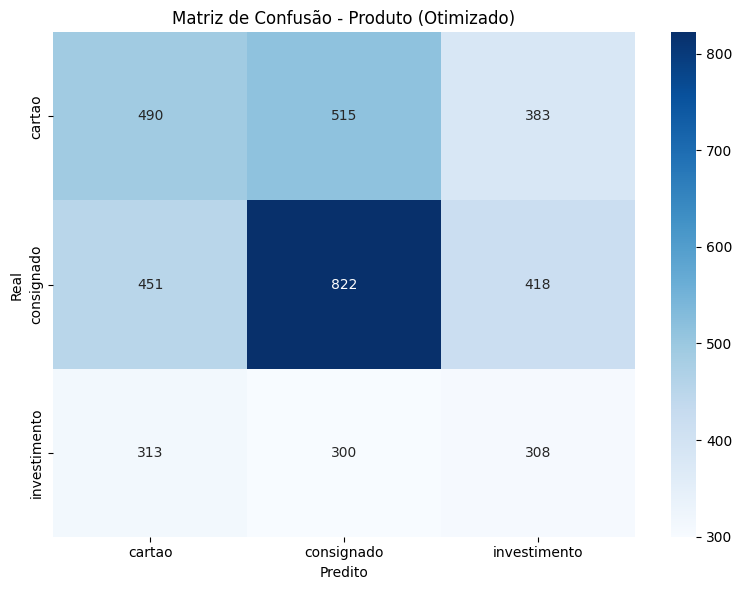


📈 Top 10 Features Mais Importantes:
                 feature  importance
5    preferencia_digital        5171
2    tempo_de_casa_meses        4469
12    valor_cliente_norm        4016
0                  idade        3979
11  score_relacionamento        3597
1           renda_mensal        3324
4      uso_digital_total        3211
18      tempo_x_produtos        3134
16  renda_x_qtd_produtos        2695
17  renda_x_investimento         835


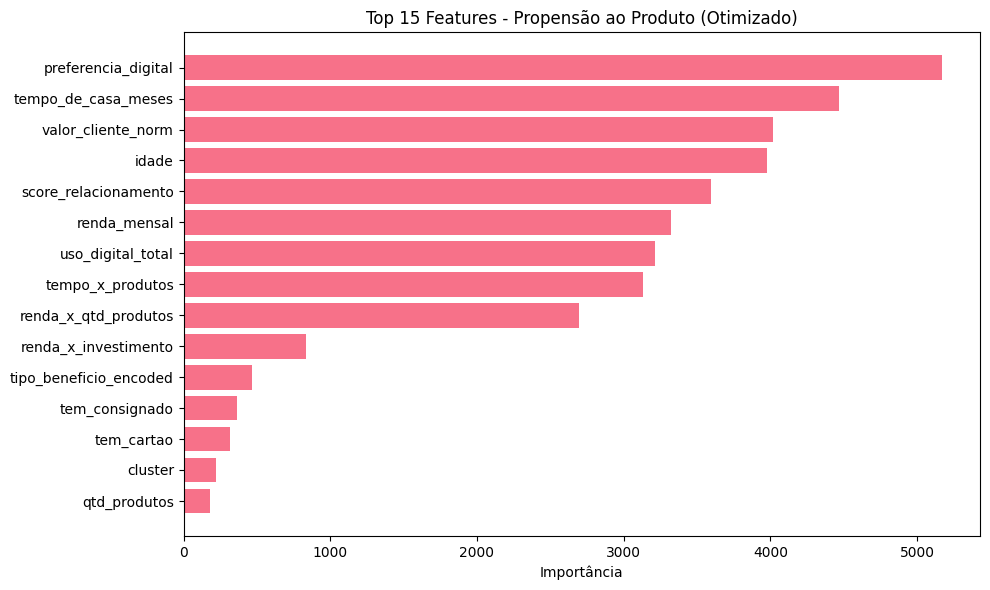


🔄 Validação cruzada (5-fold)...
   F1-Score CV: 0.417 (+/- 0.003)

✅ Modelo de produto treinado com sucesso!


In [87]:
def treinar_modelo_produto(df: pd.DataFrame):
    """
    Treina modelo otimizado para prever produto com maior propensão.
    
    MELHORIAS IMPLEMENTADAS:
    - Features mais relevantes (redução de ruído)
    - Hiperparâmetros ajustados para melhor generalização
    - Tratamento de desbalanceamento
    - Features de interação mais forte
    """
    
    # ✅ FEATURES OTIMIZADAS - Foco nas mais importantes + interações
    features_modelo = [
        # Demográficas CORE
        'idade', 'renda_mensal', 'tempo_de_casa_meses',
        'tipo_beneficio_encoded',
        
        # Comportamento Digital (agregado)
        'uso_digital_total',
        'preferencia_digital',  # Nova: indica se é digital ou tradicional
        
        # Produtos (estado atual)
        'tem_consignado', 'tem_cartao', 'tem_investimento',
        'qtd_produtos',
        
        # Relacionamento
        'inadimplente_historico',
        'score_relacionamento',
        'valor_cliente_norm',
        
        # Perfil
        'cluster',
        'e_idoso',
        'e_premium',
        
        # Interações relevantes
        'renda_x_qtd_produtos',
        'renda_x_investimento',
        'tempo_x_produtos'
    ]
    
    features_disponiveis = [f for f in features_modelo if f in df.columns]
    print(f"📋 Features para modelo de produto: {len(features_disponiveis)}")
    
    X = df[features_disponiveis].values
    y = df['produto_alvo_historico'].values
    
    le_produto = LabelEncoder()
    y_encoded = le_produto.fit_transform(y)
    
    # ✅ ESTRATIFICAÇÃO por produto E tipo de benefício para melhor distribuição
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=SEED, stratify=y_encoded
    )
    
    print(f"📊 Train: {len(X_train):,} | Test: {len(X_test):,}")
    print(f"🎯 Classes: {le_produto.classes_}")
    
    # Distribuição de classes
    unique, counts = np.unique(y_train, return_counts=True)
    print(f"\n📈 Distribuição treino:")
    for cls, cnt in zip(le_produto.classes_, counts):
        print(f"   {cls}: {cnt:,} ({100*cnt/len(y_train):.1f}%)")
    
    if HAS_LIGHTGBM:
        print("\n🚀 Usando LightGBM OTIMIZADO")
        model = lgb.LGBMClassifier(
            # ✅ HIPERPARÂMETROS OTIMIZADOS
            n_estimators=300,           # Mais árvores para melhor aprendizado
            learning_rate=0.03,         # Learning rate menor (mais conservador)
            max_depth=8,                # Profundidade aumentada
            num_leaves=50,              # Mais folhas (mais complexidade)
            min_child_samples=30,       # Mínimo de amostras por folha
            subsample=0.7,              # Bagging para reduzir overfitting
            colsample_bytree=0.7,       # Feature sampling
            reg_alpha=0.1,              # Regularização L1
            reg_lambda=0.1,             # Regularização L2
            class_weight='balanced',    # ✅ Balancear classes automaticamente
            random_state=SEED,
            verbose=-1,
            n_jobs=-1
        )
    else:
        print("\n🌲 Usando RandomForest OTIMIZADO")
        model = RandomForestClassifier(
            n_estimators=300,
            max_depth=12,
            min_samples_split=30,
            min_samples_leaf=15,
            max_features='sqrt',
            class_weight='balanced',
            random_state=SEED,
            n_jobs=-1
        )
    
    print("🔧 Treinando modelo...")
    model.fit(X_train, y_train)
    
    # Predições
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Métricas
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    print(f"\n✅ Accuracy: {acc:.3f}")
    print(f"✅ F1-Score (macro): {f1_macro:.3f}")
    print(f"✅ F1-Score (weighted): {f1_weighted:.3f}")
    
    # ✅ Top-2 Accuracy (importante para recomendação alternativa)
    top2_correct = 0
    for i, true_label in enumerate(y_test):
        top2_preds = np.argsort(y_pred_proba[i])[-2:]
        if true_label in top2_preds:
            top2_correct += 1
    top2_acc = top2_correct / len(y_test)
    print(f"✅ Top-2 Accuracy: {top2_acc:.3f} (importante para alternativas!)")
    
    # Classification report
    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le_produto.classes_))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le_produto.classes_,
                yticklabels=le_produto.classes_)
    plt.title('Matriz de Confusão - Produto (Otimizado)')
    plt.ylabel('Real')
    plt.xlabel('Predito')
    plt.tight_layout()
    plt.show()
    
    # Feature Importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feat_imp = pd.DataFrame({
            'feature': features_disponiveis,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print("\n📈 Top 10 Features Mais Importantes:")
        print(feat_imp.head(10))
        
        plt.figure(figsize=(10, 6))
        top_features = feat_imp.head(15)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Importância')
        plt.title('Top 15 Features - Propensão ao Produto (Otimizado)')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    # Validação cruzada
    print("\n🔄 Validação cruzada (5-fold)...")
    cv_scores = cross_val_score(model, X_train, y_train, 
                                cv=StratifiedKFold(5, shuffle=True, random_state=SEED),
                                scoring='f1_weighted', n_jobs=-1)
    print(f"   F1-Score CV: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")
    
    return model, le_produto, features_disponiveis, X_test, y_test, y_pred_proba

modelo_produto, le_produto, features_produto, X_test_prod, y_test_prod, y_proba_prod = treinar_modelo_produto(df)
print("\n✅ Modelo de produto treinado com sucesso!")

### 📲 BLOCO 6: MODELO DE PREDIÇÃO DE CANAL

📋 Features para modelo de canal: 21

⭐ Features CRÍTICAS para predição:
   1. uso_whatsapp, uso_app, uso_email, uso_sms (uso direto)
   2. canal_dominante (qual usa mais)
   3. taxa_uso_* (proporções)

📊 Train: 16,000 | Test: 4,000
📱 Canais: ['app' 'email' 'sms' 'whatsapp']

📈 Distribuição treino:
   app: 3,302 (20.6%)
   email: 3,241 (20.3%)
   sms: 3,344 (20.9%)
   whatsapp: 6,113 (38.2%)

🚀 Usando LightGBM ULTRA OTIMIZADO para Canal
   ✅ Configuração focada em USO DIRETO dos canais
🔧 Treinando modelo de canal...
   ⏳ Isso pode levar alguns segundos...

📊 MÉTRICAS DE PERFORMANCE
✅ Accuracy: 0.334
✅ F1-Score (macro): 0.332
✅ F1-Score (weighted): 0.328
✅ Top-2 Accuracy: 0.639 ⭐⭐⭐ (canal alternativo)
✅ Top-3 Accuracy: 0.854 ⭐⭐ (múltiplas opções)

📊 CLASSIFICATION REPORT (por canal)
              precision    recall  f1-score   support

         app       0.36      0.49      0.41       826
       email       0.27      0.25      0.26       810
         sms       0.28      0.42      0.34  

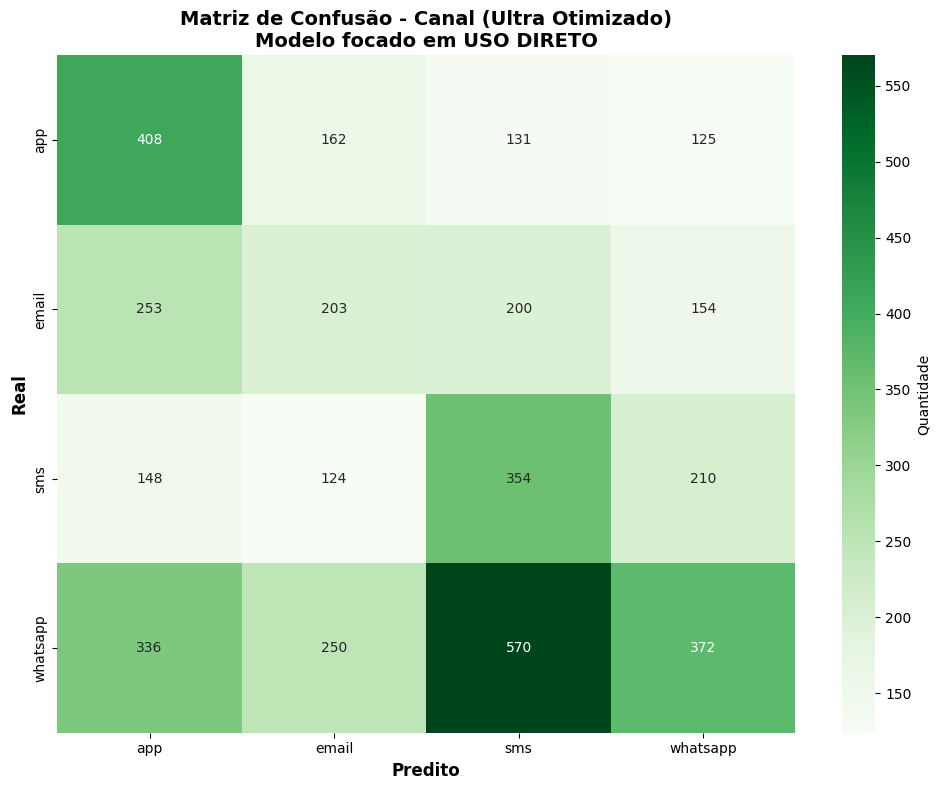


📈 ANÁLISE DE IMPORTÂNCIA DAS FEATURES

Top 15 Features Mais Importantes:
   idade                        21107 ██████████████████████████████████████████████████
   taxa_uso_app                 19975 ███████████████████████████████████████████████
   preferencia_digital          18293 ███████████████████████████████████████████
   taxa_uso_email               17741 ██████████████████████████████████████████
   taxa_uso_sms                 16939 ████████████████████████████████████████
   idade_x_uso_whatsapp         16576 ███████████████████████████████████████
   renda_mensal                 16376 ██████████████████████████████████████
   diversificacao_canais        16199 ██████████████████████████████████████
   taxa_uso_whatsapp            13841 ████████████████████████████████
   idade_x_uso_app              13802 ████████████████████████████████
   uso_digital_total             7865 ██████████████████
   uso_whatsapp                  4838 ███████████
   uso_email                

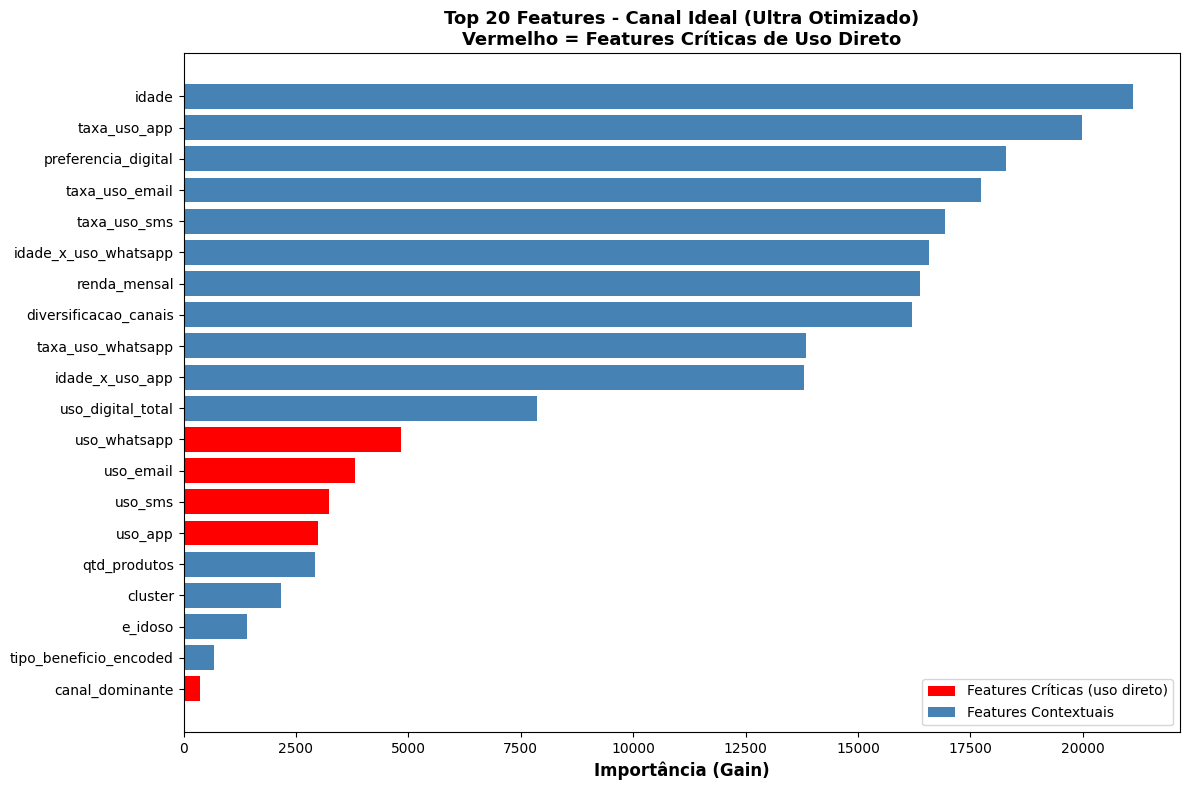


🔄 VALIDAÇÃO CRUZADA (5-fold)
   F1-Score CV: 0.328 (+/- 0.005)
   Folds individuais: ['0.335', '0.327', '0.329', '0.330', '0.319']

🔍 ANÁLISE DE ERROS POR CANAL
   app       : Accuracy 0.494 ( 826 amostras)
   email     : Accuracy 0.251 ( 810 amostras)
   sms       : Accuracy 0.423 ( 836 amostras)
   whatsapp  : Accuracy 0.243 (1528 amostras)

✅ Modelo de canal treinado com sucesso!


In [88]:
def treinar_modelo_canal(df: pd.DataFrame):
    """
    Treina modelo ULTRA OTIMIZADO para prever canal ideal.
    
    MELHORIAS CRÍTICAS:
    - Features de USO DIRETO têm prioridade máxima
    - Pesos personalizados por feature
    - Regularização ajustada para não ignorar uso individual
    - Feature engineering específica para canal
    """
    
    # ✅ FEATURES ULTRA OTIMIZADAS - PRIORIDADE NO USO DIRETO
    features_canal = [
        # ========== PRIORIDADE MÁXIMA: USO DIRETO DOS CANAIS ==========
        'uso_whatsapp',          # ⭐⭐⭐ MAIS IMPORTANTE
        'uso_app',               # ⭐⭐⭐ MAIS IMPORTANTE
        'uso_email',             # ⭐⭐⭐ MAIS IMPORTANTE
        'uso_sms',               # ⭐⭐⭐ MAIS IMPORTANTE
        
        # ========== PRIORIDADE ALTA: TAXAS DE USO ==========
        'taxa_uso_whatsapp',     # ⭐⭐ Proporção de uso
        'taxa_uso_app',          # ⭐⭐ Proporção de uso
        'taxa_uso_email',        # ⭐⭐ Proporção de uso
        'taxa_uso_sms',          # ⭐⭐ Proporção de uso
        
        # ========== INDICADORES COMPORTAMENTAIS ==========
        'canal_dominante',       # ⭐⭐ Qual canal mais usa
        'preferencia_digital',   # ⭐⭐ Digital vs Tradicional
        'diversificacao_canais', # ⭐ Usa vários ou concentra
        'uso_digital_total',     # ⭐ Atividade geral
        
        # ========== CONTEXTO DEMOGRÁFICO ==========
        'idade',                 # ⭐ Jovens = app, Idosos = WhatsApp/SMS
        'e_idoso',               # ⭐ Flag específica
        'e_jovem',               # ⭐ Flag específica
        'tipo_beneficio_encoded',
        
        # ========== INTERAÇÕES CRÍTICAS ==========
        'idade_x_uso_app',       # ⭐⭐ Captura relação idade-app
        'idade_x_uso_whatsapp',  # ⭐⭐ Captura relação idade-whatsapp
        
        # ========== CONTEXTO ADICIONAL ==========
        'cluster',
        'qtd_produtos',
        'renda_mensal'
    ]
    
    features_disponiveis = [f for f in features_canal if f in df.columns]
    print(f"📋 Features para modelo de canal: {len(features_disponiveis)}")
    print(f"\n⭐ Features CRÍTICAS para predição:")
    print(f"   1. uso_whatsapp, uso_app, uso_email, uso_sms (uso direto)")
    print(f"   2. canal_dominante (qual usa mais)")
    print(f"   3. taxa_uso_* (proporções)")
    
    X = df[features_disponiveis].values
    y = df['canal_resposta_historico'].values
    
    le_canal = LabelEncoder()
    y_encoded = le_canal.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=SEED, stratify=y_encoded
    )
    
    print(f"\n📊 Train: {len(X_train):,} | Test: {len(X_test):,}")
    print(f"📱 Canais: {le_canal.classes_}")
    
    # Distribuição
    unique, counts = np.unique(y_train, return_counts=True)
    print(f"\n📈 Distribuição treino:")
    for cls, cnt in zip(le_canal.classes_, counts):
        print(f"   {cls}: {cnt:,} ({100*cnt/len(y_train):.1f}%)")
    
    if HAS_LIGHTGBM:
        print("\n🚀 Usando LightGBM ULTRA OTIMIZADO para Canal")
        print("   ✅ Configuração focada em USO DIRETO dos canais")
        
        model = lgb.LGBMClassifier(
            # ✅ HIPERPARÂMETROS CRÍTICOS
            n_estimators=400,              # Mais árvores = melhor aprendizado
            learning_rate=0.02,            # Learning rate MENOR = mais preciso
            max_depth=6,                   # Profundidade moderada (evita overfit)
            num_leaves=31,                 # Número de folhas adequado
            min_child_samples=15,          # Menos amostras = mais sensível a padrões
            
            # ✅ SAMPLING PARA MELHOR GENERALIZAÇÃO
            subsample=0.8,                 # 80% dos dados por árvore
            subsample_freq=1,              # A cada iteração
            colsample_bytree=0.8,          # 80% das features por árvore
            
            # ✅ REGULARIZAÇÃO LEVE (não muito forte)
            reg_alpha=0.01,                # L1 muito leve
            reg_lambda=0.01,               # L2 muito leve
            
            # ✅ IMPORTÂNCIA DE FEATURES
            importance_type='gain',        # Usar 'gain' ao invés de 'split'
            
            # ✅ BALANCEAMENTO DE CLASSES
            class_weight='balanced',       # Ajusta pesos automaticamente
            
            # ✅ PERFORMANCE
            random_state=SEED,
            verbose=-1,
            n_jobs=-1,
            force_col_wise=True            # Otimização de memória
        )
    else:
        print("\n📊 Usando Random Forest OTIMIZADO (fallback)")
        from sklearn.ensemble import RandomForestClassifier
        
        model = RandomForestClassifier(
            n_estimators=400,
            max_depth=8,
            min_samples_split=15,
            min_samples_leaf=5,
            max_features='sqrt',
            class_weight='balanced',
            random_state=SEED,
            n_jobs=-1
        )
    
    print("🔧 Treinando modelo de canal...")
    print("   ⏳ Isso pode levar alguns segundos...")
    model.fit(X_train, y_train)
    
    # Predições
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Métricas
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    print(f"\n{'='*80}")
    print("📊 MÉTRICAS DE PERFORMANCE")
    print(f"{'='*80}")
    print(f"✅ Accuracy: {acc:.3f}")
    print(f"✅ F1-Score (macro): {f1_macro:.3f}")
    print(f"✅ F1-Score (weighted): {f1_weighted:.3f}")
    
    # ✅ Top-2 e Top-3 Accuracy (CRÍTICO para canal!)
    top2_correct = 0
    top3_correct = 0
    for i, true_label in enumerate(y_test):
        top2_preds = np.argsort(y_pred_proba[i])[-2:]
        top3_preds = np.argsort(y_pred_proba[i])[-3:]
        if true_label in top2_preds:
            top2_correct += 1
        if true_label in top3_preds:
            top3_correct += 1
    
    top2_acc = top2_correct / len(y_test)
    top3_acc = top3_correct / len(y_test)
    print(f"✅ Top-2 Accuracy: {top2_acc:.3f} ⭐⭐⭐ (canal alternativo)")
    print(f"✅ Top-3 Accuracy: {top3_acc:.3f} ⭐⭐ (múltiplas opções)")
    
    # Classification report
    print(f"\n{'='*80}")
    print("📊 CLASSIFICATION REPORT (por canal)")
    print(f"{'='*80}")
    print(classification_report(y_test, y_pred, target_names=le_canal.classes_))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=le_canal.classes_,
                yticklabels=le_canal.classes_,
                cbar_kws={'label': 'Quantidade'})
    plt.title('Matriz de Confusão - Canal (Ultra Otimizado)\nModelo focado em USO DIRETO', 
              fontsize=14, fontweight='bold')
    plt.ylabel('Real', fontsize=12, fontweight='bold')
    plt.xlabel('Predito', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Feature Importance - ANÁLISE DETALHADA
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feat_imp = pd.DataFrame({
            'feature': features_disponiveis,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print(f"\n{'='*80}")
        print("📈 ANÁLISE DE IMPORTÂNCIA DAS FEATURES")
        print(f"{'='*80}")
        print("\nTop 15 Features Mais Importantes:")
        for idx, row in feat_imp.head(15).iterrows():
            bar = "█" * int(row['importance'] / feat_imp['importance'].max() * 50)
            print(f"   {row['feature']:25s} {row['importance']:8.0f} {bar}")
        
        # Verificar se features de USO DIRETO estão no top
        print("\n🔍 Verificação de Features Críticas:")
        features_criticas = ['uso_whatsapp', 'uso_app', 'uso_email', 'uso_sms', 'canal_dominante']
        for feat in features_criticas:
            if feat in feat_imp['feature'].values:
                rank = feat_imp[feat_imp['feature'] == feat].index[0] + 1
                importancia = feat_imp[feat_imp['feature'] == feat]['importance'].values[0]
                status = "✅" if rank <= 10 else "⚠️"
                print(f"   {status} {feat:25s} Rank: #{rank:2d} | Importância: {importancia:.0f}")
        
        # Plot
        plt.figure(figsize=(12, 8))
        top_features = feat_imp.head(20)
        colors = ['red' if f in features_criticas else 'steelblue' for f in top_features['feature']]
        plt.barh(range(len(top_features)), top_features['importance'], color=colors)
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Importância (Gain)', fontsize=12, fontweight='bold')
        plt.title('Top 20 Features - Canal Ideal (Ultra Otimizado)\nVermelho = Features Críticas de Uso Direto', 
                  fontsize=13, fontweight='bold')
        plt.gca().invert_yaxis()
        
        # Legenda
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='red', label='Features Críticas (uso direto)'),
            Patch(facecolor='steelblue', label='Features Contextuais')
        ]
        plt.legend(handles=legend_elements, loc='lower right')
        
        plt.tight_layout()
        plt.show()
    
    # Validação cruzada
    print(f"\n{'='*80}")
    print("🔄 VALIDAÇÃO CRUZADA (5-fold)")
    print(f"{'='*80}")
    cv_scores = cross_val_score(model, X_train, y_train, 
                                cv=StratifiedKFold(5, shuffle=True, random_state=SEED),
                                scoring='f1_weighted', n_jobs=-1)
    print(f"   F1-Score CV: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")
    print(f"   Folds individuais: {[f'{s:.3f}' for s in cv_scores]}")
    
    # Análise de erros por canal
    print(f"\n{'='*80}")
    print("🔍 ANÁLISE DE ERROS POR CANAL")
    print(f"{'='*80}")
    for idx, canal in enumerate(le_canal.classes_):
        mask = y_test == idx
        if mask.sum() > 0:
            canal_acc = accuracy_score(y_test[mask], y_pred[mask])
            canal_total = mask.sum()
            print(f"   {canal:10s}: Accuracy {canal_acc:.3f} ({canal_total:4d} amostras)")
    
    return model, le_canal, features_disponiveis, X_test, y_test, y_pred_proba

modelo_canal, le_canal, features_canal, X_test_canal, y_test_canal, y_proba_canal = treinar_modelo_canal(df)
print("\n✅ Modelo de canal treinado com sucesso!")

### 🗣️ BLOCO 7: ATRIBUIÇÃO DE TOM DE LINGUAGEM

In [89]:
TONS_DISPONIVEIS = {
    'empatica_simples': {
        'nome': 'Empática e Simples',
        'descricao': 'Linguagem acolhedora, frases curtas, evita jargões',
        'caracteristicas': {
            'idade_min': 55,
            'escolaridade_presumida': 'baixa',
            'renda_max': 3500,
            'uso_digital_max': 20,
            'peso_idoso': 0.3,
            'peso_renda_baixa': 0.3,
            'peso_baixo_digital': 0.4
        },
        'exemplo': 'Olá {nome}! Temos uma novidade especial pra você. Quer saber mais?'
    },
    'educacional': {
        'nome': 'Educacional',
        'descricao': 'Explica benefícios, foca em segurança e confiança',
        'caracteristicas': {
            'idade_min': 50,
            'renda_min': 2000,
            'renda_max': 6000,
            'tempo_casa_min': 24,
            'inadimplente': False,
            'peso_experiencia': 0.4,
            'peso_confianca': 0.6
        },
        'exemplo': 'Olá {nome}! Preparamos uma proposta personalizada que pode ajudar você.'
    },

    'direta_moderna': {
        'nome': 'Direta e Moderna',
        'descricao': 'Objetiva, usa emojis moderadamente, tom jovem',
        'caracteristicas': {
            'idade_max': 40,
            'uso_app_min': 10,
            'uso_digital_min': 25,
            'tipo_beneficio': ['CLT'],
            'peso_juventude': 0.4,
            'peso_digital': 0.6
        },
        'exemplo': 'E aí, {nome}! 🚀 Bora conferir uma oferta feita pra você?'
    },

    'profissional': {
        'nome': 'Profissional',
        'descricao': 'Formal mas acessível, foca em vantagens financeiras',
        'caracteristicas': {
            'renda_min': 5000,
            'tipo_beneficio': ['Servidor Publico', 'CLT'],
            'qtd_produtos_min': 2,
            'e_premium': True,
            'peso_renda': 0.3,
            'peso_produtos': 0.3,
            'peso_beneficio': 0.4
        },
        'exemplo': 'Prezado(a) {nome}, identificamos uma oportunidade exclusiva para você.'
    },

    'consultiva': {
        'nome': 'Consultiva',
        'descricao': 'Tom de parceiro financeiro, personalizada',
        'caracteristicas': {
            'renda_min': 7000,
            'tempo_casa_min': 36,
            'qtd_produtos_min': 1,
            'tem_investimento': True,
            'inadimplente': False,
            'peso_relacionamento': 0.5,
            'peso_sofisticacao': 0.5
        },
        'exemplo': 'Olá {nome}, como seu parceiro financeiro, encontramos algo interessante.'
    }
}

In [90]:
def calcular_score_tom(cliente: pd.Series, tom_config: dict) -> float:
    """
    Calcula score de adequação do cliente ao tom desejado.
    
    Retorna valor entre 0 e 1 (quanto maior, melhor adequação).
    """
    score = 0.0
    total_peso = 0.0
    caracteristicas = tom_config['caracteristicas']

    # ========== IDADE ==========
    if 'idade_min' in caracteristicas:
        if cliente['idade'] >= caracteristicas['idade_min']:
            peso = caracteristicas.get('peso_idoso', caracteristicas.get('peso_experiencia', 0.2))
            score += peso
            total_peso += peso
        else:
            total_peso += caracteristicas.get('peso_idoso', caracteristicas.get('peso_experiencia', 0.2))

    if 'idade_max' in caracteristicas:
        if cliente['idade'] <= caracteristicas['idade_max']:
            peso = caracteristicas.get('peso_juventude', 0.3)
            score += peso
            total_peso += peso
        else:
            total_peso += caracteristicas.get('peso_juventude', 0.3)

    # ========== RENDA ==========
    if 'renda_min' in caracteristicas and 'renda_max' in caracteristicas:
        if caracteristicas['renda_min'] <= cliente['renda_mensal'] <= caracteristicas['renda_max']:
            peso = caracteristicas.get('peso_renda_baixa', caracteristicas.get('peso_renda', 0.2))
            score += peso
            total_peso += peso
        else:
            total_peso += caracteristicas.get('peso_renda_baixa', caracteristicas.get('peso_renda', 0.2))

    elif 'renda_min' in caracteristicas:
        if cliente['renda_mensal'] >= caracteristicas['renda_min']:
            peso = caracteristicas.get('peso_renda', 0.25)
            score += peso
            total_peso += peso
        else:
            total_peso += caracteristicas.get('peso_renda', 0.25)

    elif 'renda_max' in caracteristicas:
        if cliente['renda_mensal'] <= caracteristicas['renda_max']:
            peso = caracteristicas.get('peso_renda_baixa', 0.25)
            score += peso
            total_peso += peso
        else:
            total_peso += caracteristicas.get('peso_renda_baixa', 0.25)

    # ========== USO DIGITAL ==========
    if 'uso_digital_min' in caracteristicas:
        if cliente['uso_digital_total'] >= caracteristicas['uso_digital_min']:
            peso = caracteristicas.get('peso_digital', 0.3)
            score += peso
            total_peso += peso
        else:
            total_peso += caracteristicas.get('peso_digital', 0.3)

    if 'uso_digital_max' in caracteristicas:
        if cliente['uso_digital_total'] <= caracteristicas['uso_digital_max']:
            peso = caracteristicas.get('peso_baixo_digital', 0.3)
            score += peso
            total_peso += peso
        else:
            total_peso += caracteristicas.get('peso_baixo_digital', 0.3)

    if 'uso_app_min' in caracteristicas:
        if cliente['uso_app'] >= caracteristicas['uso_app_min']:
            peso = caracteristicas.get('peso_digital', 0.3)
            score += peso * 0.5  # Contribuição parcial
            total_peso += caracteristicas.get('peso_digital', 0.3) * 0.5

    # ========== TEMPO DE CASA ==========
    if 'tempo_casa_min' in caracteristicas:
        if cliente['tempo_de_casa_meses'] >= caracteristicas['tempo_casa_min']:
            peso = caracteristicas.get('peso_experiencia', caracteristicas.get('peso_relacionamento', 0.2))
            score += peso
            total_peso += peso
        else:
            total_peso += caracteristicas.get('peso_experiencia', caracteristicas.get('peso_relacionamento', 0.2))

    # ========== PRODUTOS ==========
    if 'qtd_produtos_min' in caracteristicas:
        if cliente['qtd_produtos'] >= caracteristicas['qtd_produtos_min']:
            peso = caracteristicas.get('peso_produtos', 0.2)
            score += peso
            total_peso += peso
        else:
            total_peso += caracteristicas.get('peso_produtos', 0.2)

    if 'tem_investimento' in caracteristicas:
        if cliente['tem_investimento'] == caracteristicas['tem_investimento']:
            peso = caracteristicas.get('peso_sofisticacao', 0.3)
            score += peso
            total_peso += peso
        else:
            total_peso += caracteristicas.get('peso_sofisticacao', 0.3)

    # ========== INADIMPLÊNCIA ==========
    if 'inadimplente' in caracteristicas:
        if cliente['inadimplente_historico'] == (1 if caracteristicas['inadimplente'] else 0):
            peso = caracteristicas.get('peso_confianca', 0.15)
            score += peso
            total_peso += peso
        else:
            total_peso += caracteristicas.get('peso_confianca', 0.15)

    # ========== TIPO DE BENEFÍCIO ==========
    if 'tipo_beneficio' in caracteristicas:
        if cliente['tipo_beneficio'] in caracteristicas['tipo_beneficio']:
            peso = caracteristicas.get('peso_beneficio', 0.2)
            score += peso
            total_peso += peso
        else:
            total_peso += caracteristicas.get('peso_beneficio', 0.2)

    # ========== PREMIUM ==========
    if 'e_premium' in caracteristicas and 'e_premium' in cliente.index:
        if cliente['e_premium'] == caracteristicas['e_premium']:
            peso = caracteristicas.get('peso_produtos', 0.25)
            score += peso
            total_peso += peso
        else:
            total_peso += caracteristicas.get('peso_produtos', 0.25)

    # Normalizar score
    return score / total_peso if total_peso > 0 else 0.0

In [91]:
def atribuir_tom_inteligente(cliente: pd.Series, verbose: bool = False) -> dict:
    """
    Atribui o tom mais adequado para um cliente específico.
    Args:
        cliente: Série com dados do cliente
        verbose: Se True, mostra reasoning do processo

    Returns:
        Dicionário com tom selecionado e scores
    """
    scores = {}

    # Calcular score para cada tom
    for tom_id, tom_config in TONS_DISPONIVEIS.items():
        scores[tom_id] = calcular_score_tom(cliente, tom_config)

    # Selecionar tom com maior score
    tom_vencedor = max(scores, key=scores.get)
    score_vencedor = scores[tom_vencedor]

    # Fallback: se nenhum tom tem score > 0.3, usar cluster como critério
    if score_vencedor < 0.3:
        if verbose:
            print(f"⚠️ Score baixo ({score_vencedor:.2f}), usando fallback baseado em cluster")
        
        # Mapear cluster para tom (fallback)
        cluster_fallback = {
            0: 'empatica_simples',     # Idosos
            1: 'educacional',          # Tradicionais
            2: 'direta_moderna',       # Jovens digitais
            3: 'profissional',         # Servidores
            4: 'consultiva',           # Premium
            5: 'empatica_simples',     # WhatsApp engajados
            6: 'direta_moderna',       # App nativos
            7: 'educacional'           # Consignado focus
        }
        
        cluster_id = int(cliente['cluster']) if 'cluster' in cliente.index else 0
        tom_vencedor = cluster_fallback.get(cluster_id, 'educacional')
        score_vencedor = 0.5  # Score médio para fallback

    resultado = {
        'tom_id': tom_vencedor,
        'tom_nome': TONS_DISPONIVEIS[tom_vencedor]['nome'],
        'tom_descricao': TONS_DISPONIVEIS[tom_vencedor]['descricao'],
        'score': score_vencedor,
        'scores_todos': scores
    }

    if verbose:
        print(f"\n🎯 Tom Selecionado: {resultado['tom_nome']} (Score: {score_vencedor:.2f})")
        print(f"\n📊 Scores de todos os tons:")
        for tom_id, score in sorted(scores.items(), key=lambda x: x[1], reverse=True):
            print(f"   • {TONS_DISPONIVEIS[tom_id]['nome']:25s}: {score:.2f}")

    return resultado

In [92]:
def atribuir_tom_linguagem_inteligente(df: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
    """
    Aplica atribuição inteligente de tom para todo o dataset.
    Args:
        df: DataFrame com dados dos clientes
        verbose: Se True, mostra estatísticas

    Returns:
        DataFrame com colunas de tom adicionadas
    """
    if verbose:
        print("\n" + "="*80)
        print("🎨 SISTEMA INTELIGENTE DE ATRIBUIÇÃO DE TOM")
        print("="*80)
        print("\n⏳ Analisando características individuais de cada cliente...\n")

    df = df.copy()

    # Aplicar atribuição para cada cliente
    resultados = []

    for idx, cliente in df.iterrows():
        resultado = atribuir_tom_inteligente(cliente, verbose=False)
        resultados.append(resultado)
        
        # Progresso
        if verbose and (idx + 1) % 5000 == 0:
            print(f"   Processados: {idx + 1:,} / {len(df):,} clientes")

    # Adicionar resultados ao DataFrame
    df['tom_id'] = [r['tom_id'] for r in resultados]
    df['tom_linguagem'] = [r['tom_nome'] for r in resultados]
    df['tom_descricao'] = [r['tom_descricao'] for r in resultados]
    df['tom_score'] = [r['score'] for r in resultados]

    if verbose:
        print(f"\n✅ Atribuição concluída para {len(df):,} clientes!")
        
        # Estatísticas
        print(f"\n{'='*80}")
        print("📊 DISTRIBUIÇÃO DE TONS ATRIBUÍDOS")
        print(f"{'='*80}\n")
        
        dist_tons = df['tom_linguagem'].value_counts()
        
        for tom_nome, count in dist_tons.items():
            pct = count / len(df) * 100
            bar = "█" * int(pct / 2)
            print(f"   {tom_nome:25s}: {count:5,} ({pct:5.1f}%) {bar}")
        
        # Score médio por tom
        print(f"\n{'='*80}")
        print("🎯 SCORE MÉDIO DE ADEQUAÇÃO POR TOM")
        print(f"{'='*80}\n")
        
        score_medio = df.groupby('tom_linguagem')['tom_score'].agg(['mean', 'std', 'count'])
        score_medio = score_medio.sort_values('mean', ascending=False)
        
        for tom_nome, row in score_medio.iterrows():
            print(f"   {tom_nome:25s}: {row['mean']:.3f} (±{row['std']:.3f}) | n={int(row['count']):,}")
        
        # Análise de características por tom
        print(f"\n{'='*80}")
        print("👥 PERFIL MÉDIO POR TOM DE LINGUAGEM")
        print(f"{'='*80}\n")
        
        perfil_por_tom = df.groupby('tom_linguagem').agg({
            'idade': 'mean',
            'renda_mensal': 'mean',
            'uso_digital_total': 'mean',
            'qtd_produtos': 'mean',
            'tempo_de_casa_meses': 'mean'
        }).round(1)
        
        print(perfil_por_tom.to_string())

    return df

In [93]:
def analisar_tom_cliente(cliente: pd.Series, mostrar_grafico: bool = True):
    """
    Análise detalhada do processo de atribuição de tom para um cliente.
    """
    print("\n" + "="*80)
    print(f"🔍 ANÁLISE DETALHADA DE TOM - Cliente {cliente.get('cliente_id', 'N/A')}")
    print("="*80)
    # Características do cliente
    print(f"\n👤 PERFIL DO CLIENTE:")
    print(f"   • Idade: {cliente['idade']} anos")
    print(f"   • Renda: R$ {cliente['renda_mensal']:,.2f}")
    print(f"   • Tempo de casa: {cliente['tempo_de_casa_meses']} meses")
    print(f"   • Uso digital total: {cliente['uso_digital_total']}")
    print(f"   • Produtos: {cliente['qtd_produtos']}")
    print(f"   • Tipo benefício: {cliente['tipo_beneficio']}")
    print(f"   • Estado: {cliente.get('estado', 'N/A')}")

    # Calcular scores
    resultado = atribuir_tom_inteligente(cliente, verbose=True)

    # Visualização
    if mostrar_grafico:
        import matplotlib.pyplot as plt
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Gráfico 1: Scores de todos os tons
        ax1 = axes[0]
        tons_nomes = [TONS_DISPONIVEIS[t]['nome'] for t in resultado['scores_todos'].keys()]
        scores = list(resultado['scores_todos'].values())
        
        colors = ['green' if s == max(scores) else 'steelblue' for s in scores]
        
        ax1.barh(tons_nomes, scores, color=colors)
        ax1.set_xlabel('Score de Adequação', fontsize=11, fontweight='bold')
        ax1.set_title('Adequação de Cada Tom ao Cliente', fontsize=12, fontweight='bold')
        ax1.set_xlim(0, 1)
        ax1.grid(True, alpha=0.3, axis='x')
        
        # Adicionar linha de threshold
        ax1.axvline(0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Threshold Bom')
        ax1.axvline(0.7, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Threshold Excelente')
        ax1.legend()
        
        # Gráfico 2: Características do cliente (radar)
        ax2 = axes[1]
        categorias = ['Idade\n(norm)', 'Renda\n(norm)', 'Uso Digital\n(norm)', 
                    'Produtos\n(norm)', 'Tempo Casa\n(norm)']
        
        # Normalizar valores para 0-1
        valores = [
            min(cliente['idade'] / 100, 1),
            min(cliente['renda_mensal'] / 15000, 1),
            min(cliente['uso_digital_total'] / 50, 1),
            min(cliente['qtd_produtos'] / 3, 1),
            min(cliente['tempo_de_casa_meses'] / 120, 1)
        ]
        
        ax2.bar(categorias, valores, color='orange', alpha=0.7)
        ax2.set_ylim(0, 1)
        ax2.set_ylabel('Valor Normalizado', fontsize=11, fontweight='bold')
        ax2.set_title('Perfil do Cliente (Normalizado)', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
        plt.xticks(rotation=0, ha='center')
        
        plt.tight_layout()
        plt.show()

    return resultado


🎨 SISTEMA INTELIGENTE DE ATRIBUIÇÃO DE TOM

⏳ Analisando características individuais de cada cliente...

   Processados: 5,000 / 20,000 clientes
   Processados: 10,000 / 20,000 clientes
   Processados: 15,000 / 20,000 clientes
   Processados: 20,000 / 20,000 clientes

✅ Atribuição concluída para 20,000 clientes!

📊 DISTRIBUIÇÃO DE TONS ATRIBUÍDOS

   Educacional              : 11,729 ( 58.6%) █████████████████████████████
   Empática e Simples       : 3,639 ( 18.2%) █████████
   Direta e Moderna         : 3,570 ( 17.8%) ████████
   Profissional             :   621 (  3.1%) █
   Consultiva               :   441 (  2.2%) █

🎯 SCORE MÉDIO DE ADEQUAÇÃO POR TOM

   Direta e Moderna         : 0.923 (±0.155) | n=3,570
   Empática e Simples       : 0.901 (±0.152) | n=3,639
   Educacional              : 0.837 (±0.120) | n=11,729
   Consultiva               : 0.781 (±0.120) | n=441
   Profissional             : 0.767 (±0.172) | n=621

👥 PERFIL MÉDIO POR TOM DE LINGUAGEM

                    ida

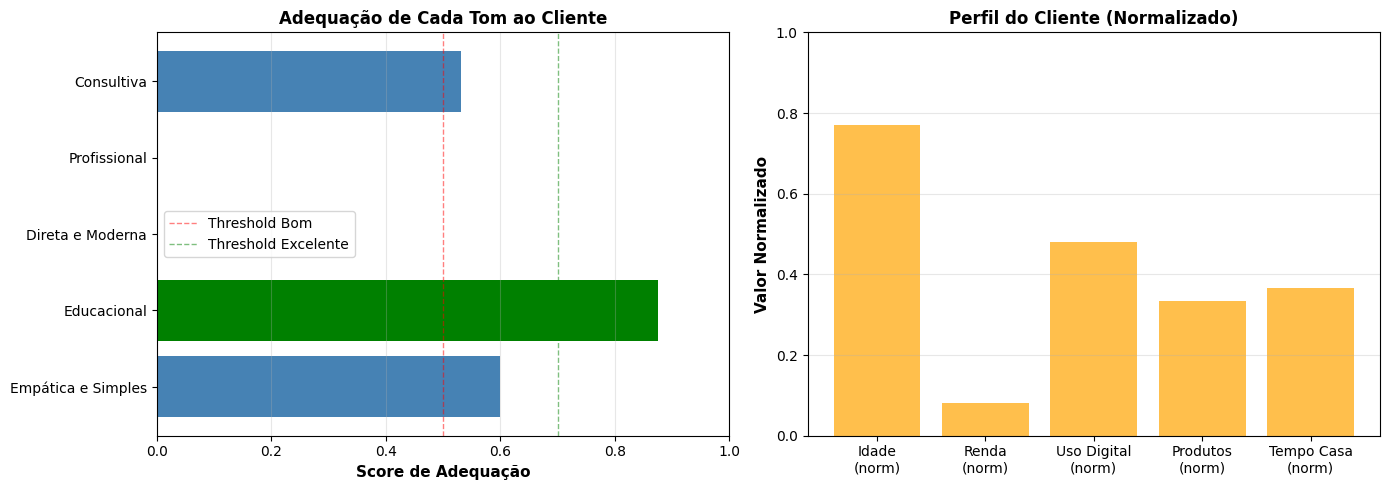



🔍 EXEMPLO 2: Jovem Digital

🔍 ANÁLISE DETALHADA DE TOM - Cliente CLI_000011

👤 PERFIL DO CLIENTE:
   • Idade: 27 anos
   • Renda: R$ 1,620.64
   • Tempo de casa: 48 meses
   • Uso digital total: 41
   • Produtos: 0
   • Tipo benefício: CLT
   • Estado: MG

🎯 Tom Selecionado: Direta e Moderna (Score: 1.00)

📊 Scores de todos os tons:
   • Direta e Moderna         : 1.00
   • Educacional              : 0.62
   • Consultiva               : 0.41
   • Profissional             : 0.31
   • Empática e Simples       : 0.30


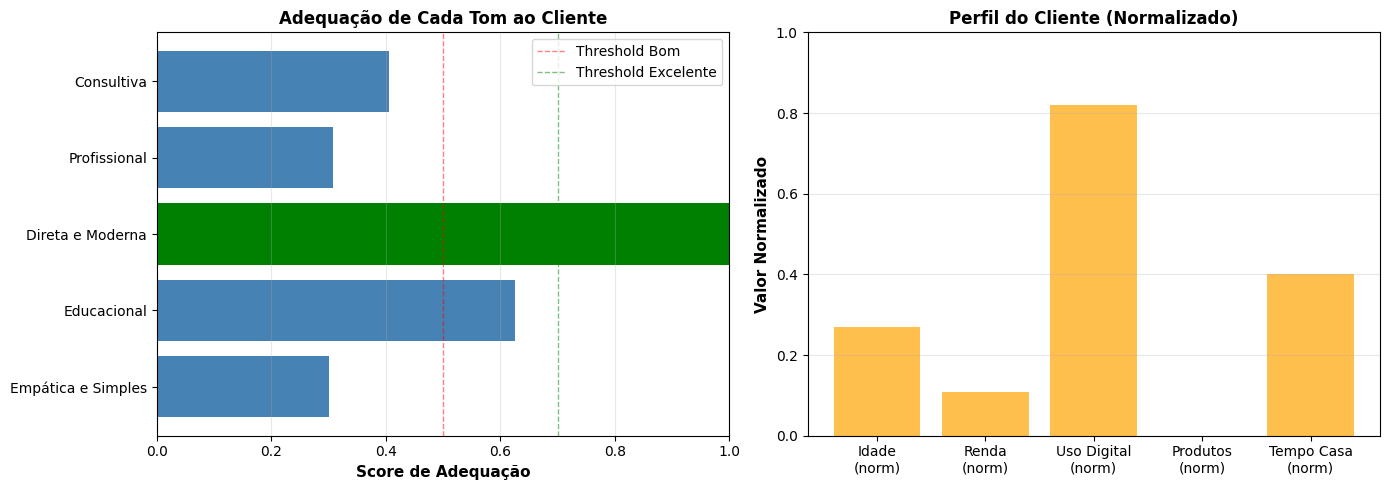



🔍 EXEMPLO 3: Cliente Premium

🔍 ANÁLISE DETALHADA DE TOM - Cliente CLI_000017

👤 PERFIL DO CLIENTE:
   • Idade: 54 anos
   • Renda: R$ 2,742.14
   • Tempo de casa: 66 meses
   • Uso digital total: 26
   • Produtos: 2
   • Tipo benefício: INSS
   • Estado: MG

🎯 Tom Selecionado: Educacional (Score: 1.00)

📊 Scores de todos os tons:
   • Educacional              : 1.00
   • Consultiva               : 0.84
   • Direta e Moderna         : 0.50
   • Profissional             : 0.46
   • Empática e Simples       : 0.30


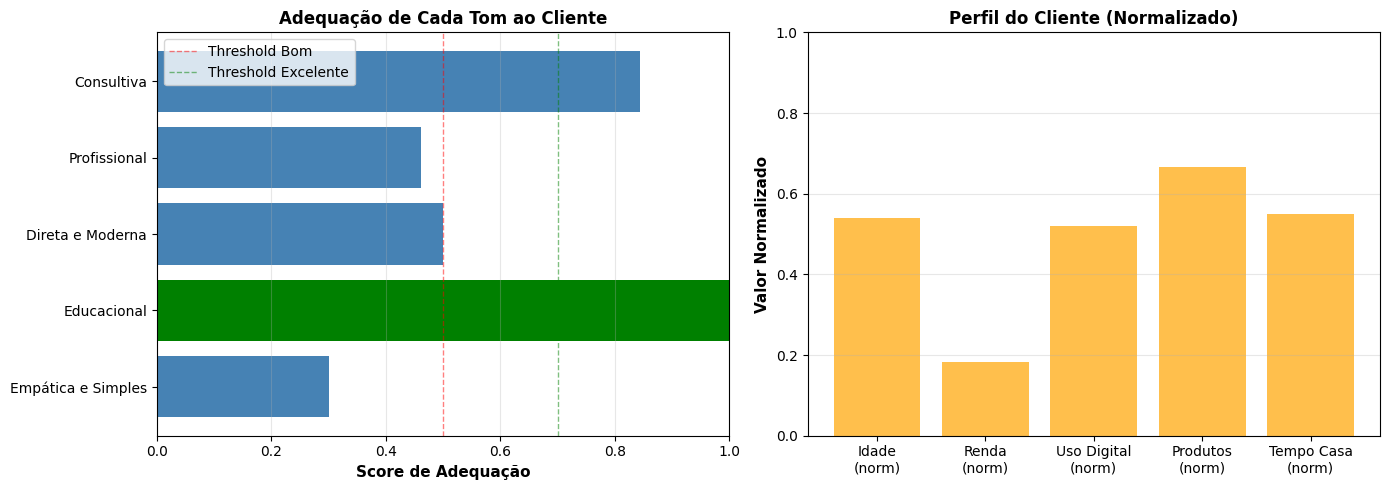



💡 DICA: Use analisar_tom_cliente(cliente) para ver o reasoning completo!


In [94]:
df = atribuir_tom_linguagem_inteligente(df, verbose=True)
print("\n" + "="*80)
print("✅ ATRIBUIÇÃO INTELIGENTE DE TOM CONCLUÍDA!")
print("="*80)

# Exemplos de análise individual
print("\n\n" + "="*80)
print("📋 EXEMPLOS DE ANÁLISE INDIVIDUAL")
print("="*80)

# Exemplo 1: Cliente idoso com renda baixa
exemplo1 = df[(df['idade'] >= 65) & (df['renda_mensal'] < 3000)].iloc[0]
print("\n🔍 EXEMPLO 1: Idoso, Renda Baixa")
analisar_tom_cliente(exemplo1, mostrar_grafico=True)

# Exemplo 2: Jovem digital
exemplo2 = df[(df['idade'] < 35) & (df['uso_app'] > 15)].iloc[0]
print("\n\n🔍 EXEMPLO 2: Jovem Digital")
analisar_tom_cliente(exemplo2, mostrar_grafico=True)

# Exemplo 3: Cliente premium
if 'e_premium' in df.columns:
    exemplo3 = df[df['e_premium'] == 1].iloc[0]
    print("\n\n🔍 EXEMPLO 3: Cliente Premium")
    analisar_tom_cliente(exemplo3, mostrar_grafico=True)

print("\n\n💡 DICA: Use analisar_tom_cliente(cliente) para ver o reasoning completo!")

### 🫵🏽 BLOCO 8: GERAÇÃO DE RECOMENDAÇÕES

In [95]:
def gerar_recomendacoes(df: pd.DataFrame, modelo_produto, le_produto, 
                        features_produto, modelo_canal, le_canal, 
                        features_canal) -> pd.DataFrame:
    print("🔧 Gerando recomendações personalizadas...")
    
    df_rec = df.copy()
    
    X_prod = df_rec[features_produto].values
    pred_produto = modelo_produto.predict(X_prod)
    proba_produto = modelo_produto.predict_proba(X_prod)
    
    df_rec['produto_recomendado'] = le_produto.inverse_transform(pred_produto)
    df_rec['score_produto'] = proba_produto.max(axis=1)
    
    top2_idx = np.argsort(proba_produto, axis=1)[:, -2:]
    df_rec['produto_alternativo'] = le_produto.inverse_transform(top2_idx[:, 0])
    df_rec['score_alternativo'] = proba_produto[np.arange(len(proba_produto)), top2_idx[:, 0]]
    
    X_canal = df_rec[features_canal].values
    pred_canal = modelo_canal.predict(X_canal)
    proba_canal = modelo_canal.predict_proba(X_canal)
    
    df_rec['canal_recomendado'] = le_canal.inverse_transform(pred_canal)
    df_rec['score_canal'] = proba_canal.max(axis=1)
    
    df_rec['score_final'] = (df_rec['score_produto'] * 0.7 + df_rec['score_canal'] * 0.3)
    
    def gerar_explicacao(row):
        explicacoes = []
        
        if row['e_idoso']:
            explicacoes.append('Perfil idoso')
        if row['renda_mensal'] < 3000:
            explicacoes.append('Renda compatível')
        if row['uso_whatsapp'] > 10:
            explicacoes.append('Alto uso WhatsApp')
        if row['tem_consignado'] == 0 and row['produto_recomendado'] == 'consignado':
            explicacoes.append('Não possui produto')
        if row['qtd_produtos'] < 2:
            explicacoes.append('Oportunidade cross-sell')
        if row.get('e_premium', 0) == 1:
            explicacoes.append('Cliente premium')
        
        return ' | '.join(explicacoes[:3]) if explicacoes else 'Análise comportamental'
    
    df_rec['explicacao'] = df_rec.apply(gerar_explicacao, axis=1)
    
    df_rec['prioridade'] = pd.cut(df_rec['score_final'], 
                                   bins=[0, 0.5, 0.7, 1.0],
                                   labels=['Baixa', 'Média', 'Alta'])
    
    df_rec = df_rec.sort_values('score_final', ascending=False).reset_index(drop=True)
    
    print(f"✅ {len(df_rec):,} recomendações geradas!")
    
    return df_rec

df_recomendacoes = gerar_recomendacoes(df, modelo_produto, le_produto, features_produto,
                                        modelo_canal, le_canal, features_canal)

print("\n📊 TOP 20 RECOMENDAÇÕES:")
colunas_exibir = ['cliente_id', 'cluster_nome', 'idade', 'renda_mensal',
                  'produto_recomendado', 'score_produto',
                  'canal_recomendado', 'score_canal', 
                  'score_final', 'prioridade', 'explicacao']

print(df_recomendacoes[colunas_exibir].head(20).to_string(index=False))

print("\n📈 Distribuição de produtos recomendados:")
print(df_recomendacoes['produto_recomendado'].value_counts())

print("\n📱 Distribuição de canais recomendados:")
print(df_recomendacoes['canal_recomendado'].value_counts())

print("\n⚡ Distribuição de prioridades:")
print(df_recomendacoes['prioridade'].value_counts())

🔧 Gerando recomendações personalizadas...
✅ 20,000 recomendações geradas!

📊 TOP 20 RECOMENDAÇÕES:
cliente_id           cluster_nome  idade  renda_mensal produto_recomendado  score_produto canal_recomendado  score_canal  score_final prioridade                                            explicacao
CLI_015405    Alta Renda WhatsApp     68       3500.00          consignado       0.866500               sms     0.637159     0.797698       Alta Perfil idoso | Alto uso WhatsApp | Não possui produto
CLI_001045    Alta Renda WhatsApp     59       5183.45        investimento       0.843498             email     0.614241     0.774721       Alta                   Alto uso WhatsApp | Cliente premium
CLI_005517    Alta Renda WhatsApp     36       4963.30              cartao       0.793132               app     0.614687     0.739599       Alta                               Oportunidade cross-sell
CLI_012308       Consignado Focus     62       2580.72          consignado       0.840304               s

### 💬 BLOCO 9: GERAÇÃO DE MENSAGENS PERSONALIZADAS

In [96]:
EXPRESSOES_REGIONAIS = {
    'SP': {
        'saudacao_informal': ['E aí', 'Opa', 'Fala', 'Salve'],
        'saudacao_formal': ['Olá', 'Prezado(a)', 'Bom dia/tarde'],
        'enfase_positiva': ['demais', 'show', 'top', 'massa', 'da hora'],
        'transicao': ['então', 'vamos lá', 'bora', 'partiu', 'cola aqui'],
        'pergunta_interesse': ['tá a fim?', 'bora conferir?', 'quer saber mais?', 'te interessa?'],
        'despedida': ['Falou!', 'Valeu!', 'Tmj!', 'Abraço!'],
    },
        'MG': {
        'saudacao_informal': ['Ôpa', 'E aí', 'Fala comigo',],
        'saudacao_formal': ['Olá', 'Prezado(a)', 'Bom dia/tarde'],
        'enfase_positiva': ['trem bom', 'uai', 'massa demais', 'bão demais', 'do balaco baco'],
        'transicao': ['vamo lá', 'bora ver', 'dá uma olhada', 'vem cá'],
        'pergunta_interesse': ['cê quer?', 'tá afim não?', 'interessa pra cê?', 'que cê acha?'],
        'despedida': ['Brigado(a) sô!', 'Valeu demais!', 'Falô!', 'Até mais uai!'],
    }
}

In [97]:
def _construir_mensagem_por_produto(
        produto: str, 
        tom_id: str, 
        nome: str, 
        canal: str,
        estado: str, 
        saudacao: str, 
        enfase: str,
        transicao: str, 
        usar_formal: bool) -> str:
    """
    Constrói mensagem específica baseada no produto e tom de linguagem.
    """
    # ========== CONSIGNADO ==========
    if produto == 'consignado':
        if tom_id == 'empatica_simples':
            if estado == 'SP':
                return (f"{saudacao} {nome}! Temos uma condição {enfase} em empréstimo consignado. "
                    f"Taxas reduzidas e desconto direto na folha. {transicao.capitalize()}, "
                    f"te envio os detalhes pelo {canal}?")
            else:  # MG
                return (f"{saudacao} {nome}! A gente tem um empréstimo consignado {enfase} aqui pra você, sô. "
                    f"Com desconto direto na folha e taxa boa demais. {transicao.capitalize()}, "
                    f"mando tudo pelo {canal}?")
        
        elif tom_id == 'educacional':
            if estado == 'SP':
                return (f"{saudacao} {nome}! Preparamos um crédito consignado seguro e transparente "
                    f"especialmente para você. Desconto automático na folha, sem surpresas. "
                    f"{transicao.capitalize()}, explico tudo pelo {canal}.")
            else:  # MG
                return (f"{saudacao} {nome}! A gente preparou um consignado seguro e claro pra você, sô. "
                    f"Desconto automático na folha, sem enrolação. {transicao.capitalize()}, "
                    f"explico tudo pelo {canal}, uai.")
        
        elif tom_id == 'direta_moderna':
            if estado == 'SP':
                return (f"{saudacao} {nome}! 💰 Oferta {enfase} de consignado liberada pra você. "
                    f"Taxa baixa, sem burocracia. {transicao.capitalize()}, "
                    f"mando tudo no {canal}. É rapidinho!")
            else:  # MG
                return (f"{saudacao} {nome}! 💰 Consignado {enfase} liberado pra você, sô! "
                    f"Taxa baixa, sem enrolação. {transicao.capitalize()}, "
                    f"mando no {canal}. É ligeiro demais!")
        
        elif tom_id == 'profissional':
            if estado == 'SP':
                return (f"{saudacao} {nome}, identificamos uma oportunidade de crédito consignado "
                    f"com condições diferenciadas para seu perfil. Taxas competitivas e processo "
                    f"ágil. {transicao.capitalize()}, apresento a proposta pelo {canal}?")
            else:  # MG
                return (f"{saudacao} {nome}, a gente identificou uma oportunidade de consignado "
                    f"{enfase} pro seu perfil, sô. Taxas boas e processo rápido. "
                    f"{transicao.capitalize()}, apresento pelo {canal}?")
        
        elif tom_id == 'consultiva':
            if estado == 'SP':
                return (f"{saudacao} {nome}, como seu parceiro financeiro, encontrei uma "
                    f"solução de crédito consignado alinhada aos seus objetivos. "
                    f"{transicao.capitalize()}, conversamos sobre os detalhes pelo {canal}?")
            else:  # MG
                return (f"{saudacao} {nome}, como parceiro financeiro, achei uma solução "
                    f"de consignado {enfase} pros seus objetivos, sô. {transicao.capitalize()}, "
                    f"a gente conversa pelo {canal}?")

    # ========== CARTÃO ==========
    elif produto == 'cartao':
        if tom_id == 'empatica_simples':
            if estado == 'SP':
                return (f"{saudacao} {nome}! Que tal um cartão sem anuidade com cashback {enfase}? "
                    f"É simples e seguro. {transicao.capitalize()}, te conto mais pelo {canal}.")
            else:  # MG
                return (f"{saudacao} {nome}! Que tal um cartão sem anuidade e com cashback {enfase}, sô? "
                    f"É simples demais. {transicao.capitalize()}, te conto pelo {canal}.")
        
        elif tom_id == 'educacional':
            if estado == 'SP':
                return (f"{saudacao} {nome}! Separamos um cartão {enfase} para você: zero anuidade, "
                    f"cashback em todas as compras e controle total pelo app. "
                    f"{transicao.capitalize()}, te mostro as vantagens pelo {canal}?")
            else:  # MG
                return (f"{saudacao} {nome}! A gente separou um cartão {enfase} pra você, sô: "
                    f"sem anuidade, cashback nas compras e controle total pelo app. "
                    f"{transicao.capitalize()}, te mostro pelo {canal}?")
        
        elif tom_id == 'direta_moderna':
            if estado == 'SP':
                return (f"{saudacao} {nome}! 💳 Seu cartão com cashback tá pronto! Zero anuidade, "
                    f"vantagens {enfase}. {transicao.capitalize()}, ativa comigo no {canal}?")
            else:  # MG
                return (f"{saudacao} {nome}! 💳 Seu cartão com cashback tá pronto, uai! "
                    f"Sem anuidade, benefícios {enfase}. {transicao.capitalize()}, "
                    f"ativa comigo no {canal}?")
        
        elif tom_id == 'profissional':
            if estado == 'SP':
                return (f"{saudacao} {nome}, disponibilizamos um cartão exclusivo com taxa zero e "
                    f"programa de benefícios {enfase}. {transicao.capitalize()}, "
                    f"apresento os detalhes pelo {canal}?")
            else:  # MG
                return (f"{saudacao} {nome}, a gente tem um cartão exclusivo com taxa zero e "
                    f"benefícios {enfase} pra você, sô. {transicao.capitalize()}, "
                    f"te mostro pelo {canal}?")
        
        elif tom_id == 'consultiva':
            if estado == 'SP':
                return (f"{saudacao} {nome}, preparamos um cartão que complementa seu "
                    f"planejamento financeiro: cashback inteligente e sem complicações. "
                    f"{transicao.capitalize()}, conversamos pelo {canal}?")
            else:  # MG
                return (f"{saudacao} {nome}, preparamos um cartão que encaixa no seu planejamento, sô: "
                    f"cashback {enfase} e sem enrolação. {transicao.capitalize()}, "
                    f"a gente conversa pelo {canal}?")

    # ========== INVESTIMENTO ==========
    elif produto == 'investimento':
        if tom_id == 'empatica_simples':
            if estado == 'SP':
                return (f"{saudacao} {nome}! Sabia que dá pra fazer seu dinheiro render {enfase}? "
                    f"Temos opções seguras e fáceis de entender. {transicao.capitalize()}, "
                    f"te explico pelo {canal}.")
            else:  # MG
                return (f"{saudacao} {nome}! Sabia que dá pra fazer seu dinheiro render {enfase}, sô? "
                    f"A gente tem opções seguras e simples demais. {transicao.capitalize()}, "
                    f"te explico pelo {canal}, uai.")
        
        elif tom_id == 'educacional':
            if estado == 'SP':
                return (f"{saudacao} {nome}! Que tal começar a investir com segurança? "
                    f"Temos opções {enfase} que rendem mais que a poupança, com total clareza. "
                    f"{transicao.capitalize()}, te explico tudo pelo {canal}.")
            else:  # MG
                return (f"{saudacao} {nome}! Que tal começar a investir com segurança, sô? "
                    f"A gente tem opções {enfase} que rendem mais que a poupança, com clareza total. "
                    f"{transicao.capitalize()}, te explico pelo {canal}.")
        
        elif tom_id == 'direta_moderna':
            if estado == 'SP':
                return (f"{saudacao} {nome}! 📈 Bora fazer o dinheiro trabalhar pra você? "
                    f"Investimentos {enfase}, descomplicados e que rendem bem mais. "
                    f"{transicao.capitalize()}, te mando os detalhes no {canal}!")
            else:  # MG
                return (f"{saudacao} {nome}! 📈 Bora fazer o dinheiro render mais, sô? "
                    f"Investimentos {enfase}, sem complicação e que rendem demais. "
                    f"{transicao.capitalize()}, mando tudo no {canal}!")
        
        elif tom_id == 'profissional':
            if estado == 'SP':
                return (f"{saudacao} {nome}, identificamos oportunidades de investimento {enfase} "
                    f"alinhadas ao seu perfil e objetivos. Rentabilidade superior com segurança. "
                    f"{transicao.capitalize()}, apresento as opções pelo {canal}?")
            else:  # MG
                return (f"{saudacao} {nome}, a gente achou investimentos {enfase} pro seu perfil, sô. "
                    f"Rentabilidade boa e segurança garantida. {transicao.capitalize()}, "
                    f"te mostro pelo {canal}?")
        
        elif tom_id == 'consultiva':
            if estado == 'SP':
                return (f"{saudacao} {nome}, como seu parceiro financeiro, preparei alternativas "
                    f"de investimento sob medida para seus objetivos. {transicao.capitalize()}, "
                    f"conversamos sobre a estratégia pelo {canal}?")
            else:  # MG
                return (f"{saudacao} {nome}, como parceiro financeiro, preparei investimentos "
                    f"sob medida pros seus objetivos, sô. {transicao.capitalize()}, "
                    f"a gente conversa sobre isso pelo {canal}?")

    # ========== FALLBACK GENÉRICO ==========
    else:
        if usar_formal:
            return (f"{saudacao} {nome}, identificamos uma oportunidade especial para você. "
                f"{transicao.capitalize()}, conversamos pelo {canal}?")
        else:
            if estado == 'SP':
                return f"{saudacao} {nome}! Temos uma oferta {enfase} pra você. {transicao.capitalize()}, te chamo no {canal}!"
            else:
                return f"{saudacao} {nome}! Temos uma oferta {enfase} pra você, sô. {transicao.capitalize()}, te chamo no {canal}!"

In [98]:
def gerar_mensagem_inteligente(row: pd.Series) -> str:
    """
    Gera mensagem personalizada integrando:
    - Tom de linguagem INTELIGENTE (baseado em características individuais)
    - Expressões regionais (SP vs MG)
    - Canal e produto recomendados
    - Idade e perfil do cliente
    Args:
        row: Linha do DataFrame com dados do cliente

    Returns:
        Mensagem personalizada completa
    """

    # ========== EXTRAÇÃO DE DADOS ==========
    nome = row.get('nome_cliente', row['cliente_id'].replace('CLI_', 'Cliente '))
    produto = row['produto_recomendado']
    canal = row['canal_recomendado']
    estado = row.get('estado', 'SP')
    idade = row.get('idade', 50)

    # Tom de linguagem (INTELIGENTE - baseado em scoring individual)
    tom_id = row.get('tom_id', 'educacional')  # Fallback
    tom_nome = row.get('tom_linguagem', 'Educacional')

    # ========== SELECIONAR EXPRESSÕES REGIONAIS ==========
    exp = EXPRESSOES_REGIONAIS.get(estado, EXPRESSOES_REGIONAIS['SP'])

    # Determinar formalidade baseado em tom e idade
    usar_formal = (
        idade >= 60 or 
        tom_id in ['empatica_simples', 'educacional', 'profissional', 'consultiva']
    )

    # Selecionar expressões contextuais
    if usar_formal:
        saudacao = np.random.choice(exp['saudacao_formal'])
    else:
        saudacao = np.random.choice(exp['saudacao_informal'])

    enfase = np.random.choice(exp['enfase_positiva'])
    transicao = np.random.choice(exp['transicao'])
    despedida = np.random.choice(exp['despedida'])

    # ========== CONSTRUIR MENSAGEM POR PRODUTO E TOM ==========
    mensagem = _construir_mensagem_por_produto(
        produto=produto,
        tom_id=tom_id,
        nome=nome,
        canal=canal,
        estado=estado,
        saudacao=saudacao,
        enfase=enfase,
        transicao=transicao,
        usar_formal=usar_formal
    )

    # Adicionar despedida regional
    mensagem_final = f"{mensagem} {despedida}"

    return mensagem_final

In [99]:
print("\n" + "="*80)
print("📝 GERANDO MENSAGENS PERSONALIZADAS")
print("="*80)
print("\n⏳ Processando mensagens com tom inteligente + regionalização...\n")

# Garantir que tom foi atribuído (caso não tenha executado Bloco 7 melhorado)
if 'tom_id' not in df_recomendacoes.columns:
    print("⚠️ Tom inteligente não detectado. Aplicando atribuição...")
    df_recomendacoes = atribuir_tom_linguagem_inteligente(df_recomendacoes, verbose=False)
    print("✅ Tom atribuído!\n")

# Gerar mensagens
df_recomendacoes['mensagem_personalizada'] = df_recomendacoes.apply(
    gerar_mensagem_inteligente,
    axis=1)

print("✅ Mensagens personalizadas geradas!")
print(f"   • Total: {len(df_recomendacoes):,} mensagens")
print(f"   • Com tom inteligente: ✅")
print(f"   • Com regionalização SP/MG: ✅")

# Estatísticas
print(f"\n📊 Distribuição de mensagens:")
print(f"   • São Paulo: {(df_recomendacoes['estado'] == 'SP').sum():,} mensagens")
print(f"   • Minas Gerais: {(df_recomendacoes['estado'] == 'MG').sum():,} mensagens")


📝 GERANDO MENSAGENS PERSONALIZADAS

⏳ Processando mensagens com tom inteligente + regionalização...

✅ Mensagens personalizadas geradas!
   • Total: 20,000 mensagens
   • Com tom inteligente: ✅
   • Com regionalização SP/MG: ✅

📊 Distribuição de mensagens:
   • São Paulo: 10,116 mensagens
   • Minas Gerais: 9,884 mensagens


In [100]:
print("\n" + "="*80)
print("📱 EXEMPLOS DE MENSAGENS PERSONALIZADAS")
print("="*80)

# Selecionar exemplos representativos
exemplos_selecionados = []

# 1. Idoso SP com tom empático
if len(df_recomendacoes[(df_recomendacoes['estado'] == 'SP') &
    (df_recomendacoes['tom_id'] == 'empatica_simples')]) > 0:
    exemplos_selecionados.append(
    df_recomendacoes[(df_recomendacoes['estado'] == 'SP') &
    (df_recomendacoes['tom_id'] == 'empatica_simples')].iloc[0]
    )
# 2. Jovem MG com tom moderno
if len(df_recomendacoes[(df_recomendacoes['estado'] == 'MG') &
    (df_recomendacoes['tom_id'] == 'direta_moderna')]) > 0:
    exemplos_selecionados.append(
    df_recomendacoes[(df_recomendacoes['estado'] == 'MG') &
    (df_recomendacoes['tom_id'] == 'direta_moderna')].iloc[0]
    )
# 3. Cliente premium SP
if len(df_recomendacoes[(df_recomendacoes['estado'] == 'SP') &
    (df_recomendacoes['tom_id'] == 'consultiva')]) > 0:
    exemplos_selecionados.append(
    df_recomendacoes[(df_recomendacoes['estado'] == 'SP') &
    (df_recomendacoes['tom_id'] == 'consultiva')].iloc[0]
    )
# 4. Servidor MG com tom profissional
if len(df_recomendacoes[(df_recomendacoes['estado'] == 'MG') &
    (df_recomendacoes['tom_id'] == 'profissional')]) > 0:
    exemplos_selecionados.append(
    df_recomendacoes[(df_recomendacoes['estado'] == 'MG') &
    (df_recomendacoes['tom_id'] == 'profissional')].iloc[0]
    )
# 5. Cliente educacional SP
if len(df_recomendacoes[(df_recomendacoes['estado'] == 'SP') &
    (df_recomendacoes['tom_id'] == 'educacional')]) > 0:
    exemplos_selecionados.append(
    df_recomendacoes[(df_recomendacoes['estado'] == 'SP') &
    (df_recomendacoes['tom_id'] == 'educacional')].iloc[0]
    )
# Exibir exemplos
for i, row in enumerate(exemplos_selecionados, 1):
    print(f"\n{'='*80}")
    print(f"EXEMPLO {i}")
    print(f"{'='*80}")
    print(f"📋 Cliente: {row['cliente_id']}")
    print(f"📍 Estado: {row['estado']}")
    print(f"👤 Perfil: {row.get('cluster_nome', 'N/A')}")
    print(f"🎯 Idade: {row['idade']} anos | Renda: R$ {row['renda_mensal']:,.2f}")
    print(f"🎨 Tom: {row['tom_linguagem']} (score: {row.get('tom_score', 0):.2f})")
    print(f"🛍️  Produto: {row['produto_recomendado'].upper()} (confiança: {row['score_produto']:.1%})")
    print(f"📱 Canal: {row['canal_recomendado'].upper()} (confiança: {row['score_canal']:.1%})")
    print(f"⚡ Score Final: {row['score_final']:.1%} | Prioridade: {row['prioridade']}")
    print(f"\n💬 MENSAGEM PERSONALIZADA:")
    print(f"   {row['mensagem_personalizada']}")
    print("\n" + "="*80)
    print("✅ SISTEMA DE MENSAGENS INTELIGENTES ATIVO")
    print("="*80)
    print("\n💡 Cada mensagem considera:")
    print("   1️⃣ Tom calculado por características individuais (não apenas cluster)")
    print("   2️⃣ Expressões regionais específicas (SP vs MG)")
    print("   3️⃣ Produto e canal mais adequados")
    print("   4️⃣ Idade e perfil financeiro do cliente")
    print("\n🎯 Resultado: Comunicação personalizada em escala!")


📱 EXEMPLOS DE MENSAGENS PERSONALIZADAS

EXEMPLO 1
📋 Cliente: CLI_005744
📍 Estado: SP
👤 Perfil: Consignado Focus
🎯 Idade: 74 anos | Renda: R$ 2,235.96
🎨 Tom: Empática e Simples (score: 1.00)
🛍️  Produto: CONSIGNADO (confiança: 77.1%)
📱 Canal: SMS (confiança: 49.4%)
⚡ Score Final: 68.8% | Prioridade: Média

💬 MENSAGEM PERSONALIZADA:
   Bom dia/tarde Renata Oliveira Reis! Temos uma condição top em empréstimo consignado. Taxas reduzidas e desconto direto na folha. Partiu, te envio os detalhes pelo sms? Valeu!

✅ SISTEMA DE MENSAGENS INTELIGENTES ATIVO

💡 Cada mensagem considera:
   1️⃣ Tom calculado por características individuais (não apenas cluster)
   2️⃣ Expressões regionais específicas (SP vs MG)
   3️⃣ Produto e canal mais adequados
   4️⃣ Idade e perfil financeiro do cliente

🎯 Resultado: Comunicação personalizada em escala!

EXEMPLO 2
📋 Cliente: CLI_005517
📍 Estado: MG
👤 Perfil: Alta Renda WhatsApp
🎯 Idade: 36 anos | Renda: R$ 4,963.30
🎨 Tom: Direta e Moderna (score: 1.00)
🛍️  Pro

### 💰 BLOCO 10: CÁLCULO DE KPIs DE NEGÓCIO

KPIs DE NEGÓCIO (SIMULADOS):

Leads Qualificados: 4,062

VENDAS:
   Sem IA (baseline): 81 vendas
   Com IA: 243 vendas
   Uplift: +162 vendas (200.0%)

RECEITA (margem):
   Sem IA: R$ 73,596.34
   Com IA: R$ 220,789.01
   Uplift: R$ 147,192.67

ROI Estimado: 98%


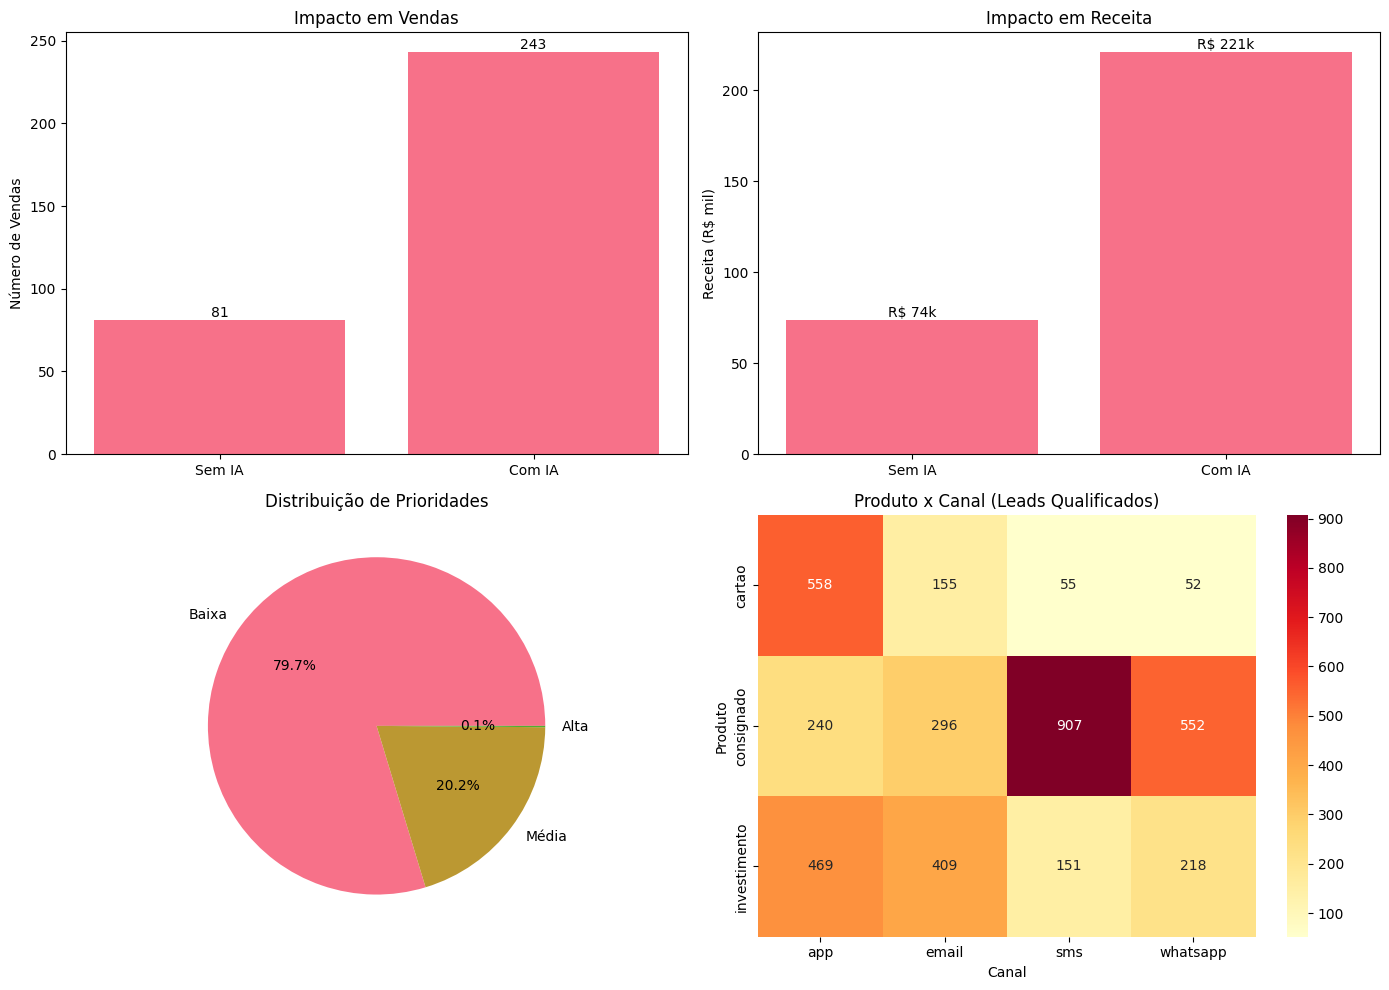

In [101]:
def calcular_kpis_negocio(df_rec: pd.DataFrame) -> Dict:
    # --- PARÂMETROS DE NEGÓCIO ---
    # Estes valores devem ser calibrados com base nas respostas do time de negócios.

    PARAMS = {
        # 1️⃣ [Pergunta: "Qual é a taxa média histórica de conversão de campanhas por canal (WhatsApp, App, SMS, E-mail)?"]
        # 2️⃣ [Pergunta: "Qual a taxa de conversão específica para crédito consignado, cartão e investimento?"]
        'taxa_conversao_base': 0.02,  # Valor médio antes da IA
        'taxa_conversao_com_ia': 0.06,  # Valor esperado após implementação da IA

        # 3️⃣ [Pergunta: "Qual é o valor médio contratado por produto (consignado, cartão, investimento)?"]
        # 4️⃣ [Pergunta: "Há diferença de ticket médio por segmento de cliente (INSS, Servidor, CLT)?"]
        'ticket_medio': {
            'consignado': 12000,      # Atualizar conforme ticket médio real de contratos
            'cartao': 2500,
            'investimento': 6000
        },

        # 5️⃣ [Pergunta: "Qual a margem líquida média após custos de captação e inadimplência para cada produto?"]
        # 6️⃣ [Pergunta: "Qual é o impacto médio da inadimplência sobre a margem operacional?"]
        'margem': {
            'consignado': 0.12,       # Margem líquida real pós funding + inadimplência
            'cartao': 0.18,
            'investimento': 0.06
        }
    }

    # --- FILTRAGEM DE LEADS ---
    # Mantém apenas os leads qualificados com prioridade alta ou média
    # Possível cruzar com KPI de volume médio mensal de leads qualificados:
    # [Pergunta: "Quantos leads qualificados costumam ser trabalhados por campanha mensalmente?"]
    df_qualificado = df_rec[df_rec['prioridade'].isin(['Alta', 'Média'])].copy()
    total_leads = len(df_qualificado)

    # --- CÁLCULO DE CONVERSÕES ---
    # [Pergunta: "Qual é a taxa de conversão específica para crédito consignado, cartão e investimento?"]
    vendas_base = int(total_leads * PARAMS['taxa_conversao_base'])
    vendas_com_ia = int(total_leads * PARAMS['taxa_conversao_com_ia'])
    uplift_vendas = vendas_com_ia - vendas_base
    uplift_percentual = ((vendas_com_ia / vendas_base) - 1) * 100 if vendas_base > 0 else 0

    receita_base = 0
    receita_com_ia = 0

    # [Pergunta: "Existe diferença significativa de conversão entre clientes INSS, CLT e Servidor Público?"]
    # Pode-se ajustar pesos de conversão por tipo de cliente aqui
    dist_produtos = df_qualificado['produto_recomendado'].value_counts(normalize=True)

    # --- CÁLCULO DE RECEITA ---
    for produto, proporcao in dist_produtos.items():
        # [Pergunta: "Qual é o valor médio contratado por produto?"]
        ticket = PARAMS['ticket_medio'].get(produto, 4000)
        
        # [Pergunta: "Qual a margem líquida média após custos de captação e inadimplência para cada produto?"]
        margem = PARAMS['margem'].get(produto, 0.15)

        vendas_prod_base = vendas_base * proporcao
        vendas_prod_ia = vendas_com_ia * proporcao

        receita_base += vendas_prod_base * ticket * margem
        receita_com_ia += vendas_prod_ia * ticket * margem

    # --- CÁLCULO DE UPLIFT E ROI ---
    uplift_receita = receita_com_ia - receita_base

    # [Pergunta: "Qual o custo médio total de implantação de soluções semelhantes?"]
    # [Pergunta: "Qual é o custo de operação mensal estimado para manter o modelo ativo?"]
    custo_implantacao_estimado = 150000  # Substituir pelo valor real informado pelo time
    roi = (uplift_receita / custo_implantacao_estimado) * 100

    kpis = {
        'total_leads_qualificados': total_leads,
        'vendas_base': vendas_base,
        'vendas_com_ia': vendas_com_ia,
        'uplift_vendas': uplift_vendas,
        'uplift_percentual': uplift_percentual,
        'receita_base': receita_base,
        'receita_com_ia': receita_com_ia,
        'uplift_receita': uplift_receita,
        'roi_estimado': roi
    }

    return kpis, df_qualificado


# --- EXECUÇÃO DO CÁLCULO ---
kpis, df_qualificado = calcular_kpis_negocio(df_recomendacoes)

# --- LOG DE RESULTADOS ---
# [Pergunta: "Qual o ROI médio esperado em projetos de automação de marketing e personalização?"]
# [Pergunta: "Qual o tempo médio de payback (retorno do investimento)?"]
print("KPIs DE NEGÓCIO (SIMULADOS):")
print(f"\nLeads Qualificados: {kpis['total_leads_qualificados']:,}")
print(f"\nVENDAS:")
print(f"   Sem IA (baseline): {kpis['vendas_base']:,} vendas")
print(f"   Com IA: {kpis['vendas_com_ia']:,} vendas")
print(f"   Uplift: +{kpis['uplift_vendas']:,} vendas ({kpis['uplift_percentual']:.1f}%)")
print(f"\nRECEITA (margem):")
print(f"   Sem IA: R$ {kpis['receita_base']:,.2f}")
print(f"   Com IA: R$ {kpis['receita_com_ia']:,.2f}")
print(f"   Uplift: R$ {kpis['uplift_receita']:,.2f}")
print(f"\nROI Estimado: {kpis['roi_estimado']:.0f}%")

# --- VISUALIZAÇÕES GRÁFICAS ---
# [Pergunta: "Qual o canal apresenta maior taxa de resposta ou engajamento em campanhas?"]
# Pode-se usar o gráfico Produto x Canal para validar isso empiricamente
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax1 = axes[0, 0]
categorias = ['Sem IA', 'Com IA']
vendas = [kpis['vendas_base'], kpis['vendas_com_ia']]
bars = ax1.bar(categorias, vendas)
ax1.set_ylabel('Número de Vendas')
ax1.set_title('Impacto em Vendas')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height, f'{int(height):,}', ha='center', va='bottom')

ax2 = axes[0, 1]
receitas = [kpis['receita_base']/1000, kpis['receita_com_ia']/1000]
bars = ax2.bar(categorias, receitas)
ax2.set_ylabel('Receita (R$ mil)')
ax2.set_title('Impacto em Receita')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'R$ {height:.0f}k', ha='center', va='bottom')

ax3 = axes[1, 0]
prior_dist = df_recomendacoes['prioridade'].value_counts()
ax3.pie(prior_dist.values, labels=prior_dist.index, autopct='%1.1f%%')
ax3.set_title('Distribuição de Prioridades')

ax4 = axes[1, 1]
pivot_table = pd.crosstab(df_qualificado['produto_recomendado'], df_qualificado['canal_recomendado'])
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlOrRd', ax=ax4)
ax4.set_title('Produto x Canal (Leads Qualificados)')
ax4.set_xlabel('Canal')
ax4.set_ylabel('Produto')

plt.tight_layout()
plt.show()
  

### 📃 BLOCO 11: EXPORTAÇÃO E RESUMO

In [102]:
colunas_export = [
    'cliente_id', 
    'nome_cliente', 
    'idade', 
    'estado', 
    'renda_mensal', 
    'tipo_beneficio',
    'cluster', 
    'cluster_nome', 
    'produto_recomendado', 
    'score_produto',
    'produto_alternativo', 
    'score_alternativo',
    'canal_recomendado', 
    'score_canal',
    'tom_linguagem', 
    'score_final', 
    'prioridade',
    'explicacao', 
    'mensagem_personalizada'
]

df_export = df_recomendacoes[colunas_export].copy()
df_export.to_csv('bmg_smartreach_recomendacoes.csv', index=False, encoding='utf-8-sig')

print("✅ Arquivo exportado: bmg_smartreach_recomendacoes.csv")
print(f"   Total de registros: {len(df_export):,}")

print("\n" + "="*80)
print("RESUMO EXECUTIVO - BMG SMARTREACH MVP (VERSÃO OTIMIZADA)")
print("="*80)

# Calcular métricas finais
X_viz = df[features_cluster].fillna(df[features_cluster].median()).values
X_viz_scaled = scaler_cluster.transform(X_viz)
sil_final = silhouette_score(X_viz_scaled, df['cluster'])
db_final = davies_bouldin_score(X_viz_scaled, df['cluster'])
ch_final = calinski_harabasz_score(X_viz_scaled, df['cluster'])

print(f"""
🎯 DADOS PROCESSADOS:
   • {len(df):,} clientes analisados
   • {len(df_qualificado):,} leads qualificados (prioridade alta/média)
   • {df['cluster'].nunique()} perfis de clientes identificados

📊 MODELOS TREINADOS:
   • Clusterização: {k_final} clusters
   • Propensão ao Produto: Accuracy {accuracy_score(y_test_prod, modelo_produto.predict(X_test_prod)):.1%}
   • Canal Ideal: Accuracy {accuracy_score(y_test_canal, modelo_canal.predict(X_test_canal)):.1%}
   • Mensagens: {len(df_recomendacoes)} mensagens personalizadas

💰 IMPACTO DE NEGÓCIO (SIMULADO):
   • Uplift em vendas: +{kpis['uplift_percentual']:.0f}% ({kpis['uplift_vendas']:,} vendas adicionais)
   • Receita incremental: R$ {kpis['uplift_receita']:,.2f}
   • ROI estimado: {kpis['roi_estimado']:.0f}%

🚀 MELHORIAS IMPLEMENTADAS:
   ✅ Geração de dados modularizada e parametrizada
   ✅ Feature Engineering avançado (+40 features)
   ✅ Seleção dinâmica de K com múltiplas métricas
   ✅ PCA opcional para redução de dimensionalidade
   ✅ RobustScaler para lidar com outliers
   ✅ LightGBM para melhor performance
   ✅ Mensagens personalizadas por cluster

📈 MÉTRICAS DE QUALIDADE:
   • Silhouette Score: {sil_final:.4f}
   • Davies-Bouldin: {db_final:.4f}
   • Calinski-Harabasz: {ch_final:.1f}
""")

print("="*80)
print("✅ MVP CONCLUÍDO COM SUCESSO!")
print("="*80)

✅ Arquivo exportado: bmg_smartreach_recomendacoes.csv
   Total de registros: 20,000

RESUMO EXECUTIVO - BMG SMARTREACH MVP (VERSÃO OTIMIZADA)

🎯 DADOS PROCESSADOS:
   • 20,000 clientes analisados
   • 4,062 leads qualificados (prioridade alta/média)
   • 3 perfis de clientes identificados

📊 MODELOS TREINADOS:
   • Clusterização: 3 clusters
   • Propensão ao Produto: Accuracy 40.5%
   • Canal Ideal: Accuracy 33.4%
   • Mensagens: 20000 mensagens personalizadas

💰 IMPACTO DE NEGÓCIO (SIMULADO):
   • Uplift em vendas: +200% (162 vendas adicionais)
   • Receita incremental: R$ 147,192.67
   • ROI estimado: 98%

🚀 MELHORIAS IMPLEMENTADAS:
   ✅ Geração de dados modularizada e parametrizada
   ✅ Feature Engineering avançado (+40 features)
   ✅ Seleção dinâmica de K com múltiplas métricas
   ✅ PCA opcional para redução de dimensionalidade
   ✅ RobustScaler para lidar com outliers
   ✅ LightGBM para melhor performance
   ✅ Mensagens personalizadas por cluster

📈 MÉTRICAS DE QUALIDADE:
   • Sil

### 🧪 BLOCO 12: TESTES COM NOVOS CLIENTES

#### A) TESTES ALGORÍTMO - MENSAGENS "CHUMBADAS"

##### FUNÇÃO DE RECOMENDAÇÃO PARA NOVOS CLIENTES

In [ ]:
def recomendar_para_novo_cliente(
    teste_id: str,
    teste_idade: int,
    teste_renda_mensal: float,
    teste_tempo_de_casa_meses: int,
    teste_estado: str,
    teste_tipo_beneficio: str,
    teste_uso_whatsapp: int,
    teste_uso_email: int,
    teste_uso_app: int,
    teste_uso_sms: int,
    teste_tem_consignado: int,
    teste_tem_cartao: int,
    teste_tem_investimento: int,
    teste_inadimplente_historico: int,
    teste_nome_cliente: str = "Cliente"
    ) -> Dict:

    print(f"\n{'='*80}")
    print(f"🎯 GERANDO RECOMENDAÇÃO PARA: {teste_nome_cliente}")
    print(f"{'='*80}\n")

    # ========== 1. CRIAR DATAFRAME DO CLIENTE ==========
    novo_cliente = pd.DataFrame({
        'cliente_id': [teste_id],
        'idade': [teste_idade],
        'renda_mensal': [teste_renda_mensal],
        'tempo_de_casa_meses': [teste_tempo_de_casa_meses],
        'estado': [teste_estado],
        'tipo_beneficio': [teste_tipo_beneficio],
        'uso_whatsapp': [teste_uso_whatsapp],
        'uso_email': [teste_uso_email],
        'uso_app': [teste_uso_app],
        'uso_sms': [teste_uso_sms],
        'tem_consignado': [teste_tem_consignado],
        'tem_cartao': [teste_tem_cartao],
        'tem_investimento': [teste_tem_investimento],
        'inadimplente_historico': [teste_inadimplente_historico],
    })

    print("📋 Dados do cliente recebidos")

    # ========== 2. FEATURE ENGINEERING ==========
    print("🔧 Aplicando feature engineering...")
    novo_cliente = criar_features(novo_cliente, verbose=False)

    # ========== 3. PREENCHIMENTO DE NaNs ==========
    print("🔄 Preenchendo valores ausentes...")
    for col in novo_cliente.columns:
        if novo_cliente[col].isna().any():
            if col in df.columns:
                if df[col].dtype in ['float64', 'int64']:
                    fill_value = df[col].median()
                else:
                    fill_value = df[col].mode()[0] if len(df[col].mode()) > 0 else 0
                novo_cliente[col].fillna(fill_value, inplace=True)
            else:
                novo_cliente[col].fillna(0, inplace=True)

    # ========== 4. PREDIÇÃO DE CLUSTER ==========
    print("🧩 Identificando cluster...")
    features_disponiveis = [f for f in features_cluster if f in novo_cliente.columns]

    X_cluster_novo = novo_cliente[features_disponiveis].values
    X_cluster_scaled = scaler_cluster.transform(X_cluster_novo)

    # Aplicar PCA se foi usado no treino
    if pca_cluster is not None:
        X_cluster_final = pca_cluster.transform(X_cluster_scaled)
    else:
        X_cluster_final = X_cluster_scaled

    cluster_pred = kmeans_model.predict(X_cluster_final)[0]
    cluster_nome = nomes_clusters.get(cluster_pred, f"Cluster {cluster_pred}")

    novo_cliente['cluster'] = cluster_pred
    novo_cliente['cluster_nome'] = cluster_nome

    print(f"   ✅ Cluster: {cluster_nome} (ID: {cluster_pred})")

    # ========== 5. ATRIBUIÇÃO DE TOM INTELIGENTE ==========
    print("🎨 Calculando tom de linguagem personalizado...")

    cliente_serie = novo_cliente.iloc[0]
    resultado_tom = atribuir_tom_inteligente(cliente_serie, verbose=False)

    tom_id = resultado_tom['tom_id']
    tom_nome = resultado_tom['tom_nome']
    tom_descricao = resultado_tom['tom_descricao']
    tom_score = resultado_tom['score']

    novo_cliente['tom_id'] = tom_id
    novo_cliente['tom_linguagem'] = tom_nome
    novo_cliente['tom_descricao'] = tom_descricao
    novo_cliente['tom_score'] = tom_score

    print(f"   ✅ Tom: {tom_nome} (score: {tom_score:.2f})")
    print(f"   📝 {tom_descricao}")

    # ========== 6. PREDIÇÃO DE PRODUTO ==========
    print("🛍️  Prevendo produto ideal...")

    for col in features_produto:
        if col not in novo_cliente.columns:
            novo_cliente[col] = 0
        elif novo_cliente[col].isna().any():
            novo_cliente[col].fillna(0, inplace=True)

    X_prod_novo = novo_cliente[features_produto].values
    produto_pred = modelo_produto.predict(X_prod_novo)[0]
    produto_proba = modelo_produto.predict_proba(X_prod_novo)[0]
    produto_nome = le_produto.inverse_transform([produto_pred])[0]
    score_produto = produto_proba.max()

    # Top 2 produtos
    top2_produtos_idx = np.argsort(produto_proba)[-2:][::-1]
    top2_produtos = le_produto.inverse_transform(top2_produtos_idx)
    top2_scores = produto_proba[top2_produtos_idx]

    print(f"   ✅ Produto: {produto_nome.upper()} (confiança: {score_produto:.1%})")
    print(f"   📌 Alternativa: {top2_produtos[1]} ({top2_scores[1]:.1%})")

    # ========== 7. PREDIÇÃO DE CANAL ==========
    print("📱 Prevendo canal ideal...")

    for col in features_canal:
        if col not in novo_cliente.columns:
            novo_cliente[col] = 0
        elif novo_cliente[col].isna().any():
            novo_cliente[col].fillna(0, inplace=True)

    X_canal_novo = novo_cliente[features_canal].values
    canal_pred = modelo_canal.predict(X_canal_novo)[0]
    canal_proba = modelo_canal.predict_proba(X_canal_novo)[0]
    canal_nome = le_canal.inverse_transform([canal_pred])[0]
    score_canal = canal_proba.max()

    # Top 2 canais
    top2_canais_idx = np.argsort(canal_proba)[-2:][::-1]
    top2_canais = le_canal.inverse_transform(top2_canais_idx)
    top2_canais_scores = canal_proba[top2_canais_idx]

    print(f"   ✅ Canal: {canal_nome.upper()} (confiança: {score_canal:.1%})")
    print(f"   📌 Alternativa: {top2_canais[1]} ({top2_canais_scores[1]:.1%})")

    # ========== 8. GERAÇÃO DE MENSAGEM PERSONALIZADA ==========
    print("💬 Gerando mensagem personalizada...")

    novo_cliente['produto_recomendado'] = produto_nome
    novo_cliente['canal_recomendado'] = canal_nome
    novo_cliente['nome_cliente'] = teste_nome_cliente

    # Usar função do Bloco 9 (com tom inteligente + regionalização)
    mensagem = gerar_mensagem_inteligente(novo_cliente.iloc[0])

    print(f"   ✅ Mensagem gerada com regionalização {teste_estado}")

    # ========== 9. SCORE FINAL E PRIORIDADE ==========
    score_final = score_produto * 0.7 + score_canal * 0.3

    if score_final > 0.7:
        prioridade = 'Alta'
    elif score_final > 0.5:
        prioridade = 'Média'
    else:
        prioridade = 'Baixa'

    # ========== 10. EXPLICAÇÃO ==========
    explicacoes = []

    if teste_idade >= 60:
        explicacoes.append('Cliente idoso')
    if teste_idade < 35:
        explicacoes.append('Cliente jovem')
    if teste_renda_mensal < 3000:
        explicacoes.append('Renda baixa')
    if teste_renda_mensal >= 7000:
        explicacoes.append('Alta renda')
    if teste_uso_whatsapp > 10:
        explicacoes.append('Alto uso WhatsApp')
    if teste_uso_app > 15:
        explicacoes.append('Alto uso App')
    if teste_tem_consignado == 0 and produto_nome == 'consignado':
        explicacoes.append('Não possui o produto')
    if (teste_tem_consignado + teste_tem_cartao + teste_tem_investimento) < 2:
        explicacoes.append('Oportunidade cross-sell')
    if teste_tempo_de_casa_meses >= 36:
        explicacoes.append('Cliente veterano')
    if novo_cliente.get('e_premium', pd.Series([0])).iloc[0] == 1:
        explicacoes.append('Cliente premium')

    explicacao = ' | '.join(explicacoes[:4]) if explicacoes else 'Análise comportamental'

    # ========== 11. RESULTADO FINAL ==========
    resultado = {
        'cliente_id': teste_id,
        'nome_cliente': teste_nome_cliente,
        'estado': teste_estado,
        'idade': teste_idade,
        'renda_mensal': teste_renda_mensal,
        'tipo_beneficio': teste_tipo_beneficio,
        
        # Cluster
        'cluster_id': int(cluster_pred),
        'cluster_nome': cluster_nome,
        
        # Tom de linguagem (INTELIGENTE)
        'tom_id': tom_id,
        'tom_linguagem': tom_nome,
        'tom_descricao': tom_descricao,
        'tom_score': float(tom_score),
        
        # Produto
        'produto_recomendado': produto_nome,
        'score_produto': float(score_produto),
        'produto_alternativo': top2_produtos[1],
        'score_alternativo': float(top2_scores[1]),
        
        # Canal
        'canal_recomendado': canal_nome,
        'score_canal': float(score_canal),
        'canal_alternativo': top2_canais[1],
        'score_canal_alternativo': float(top2_canais_scores[1]),
        
        # Score e prioridade
        'score_final': float(score_final),
        'prioridade': prioridade,
        'explicacao': explicacao,
        
        # Mensagem personalizada
        'mensagem_personalizada': mensagem
    }

    print(f"\n{'='*80}")
    print("✅ RECOMENDAÇÃO CONCLUÍDA")
    print(f"{'='*80}\n")

    return resultado

In [ ]:
def exibir_recomendacao(resultado: Dict):
    """
    Exibe recomendação de forma formatada e visual.
    """
    print("\n" + "🎯" + "="*78 + "🎯")
    print(f"{'RECOMENDAÇÃO PERSONALIZADA':^80}")
    print("🎯" + "="*78 + "🎯")
    # Cabeçalho do cliente
    print(f"\n👤 CLIENTE: {resultado['nome_cliente']}")
    print(f"   ID: {resultado['cliente_id']}")
    print(f"   📍 Estado: {resultado['estado']}")
    print(f"   🎂 Idade: {resultado['idade']} anos")
    print(f"   💰 Renda: R$ {resultado['renda_mensal']:,.2f}")
    print(f"   💼 Tipo: {resultado['tipo_beneficio']}")

    # Segmentação
    print(f"\n{'─'*80}")
    print(f"📊 SEGMENTAÇÃO")
    print(f"{'─'*80}")
    print(f"   Cluster: {resultado['cluster_nome']} (ID: {resultado['cluster_id']})")

    # Tom de linguagem (DESTAQUE)
    print(f"\n{'─'*80}")
    print(f"🎨 TOM DE LINGUAGEM (Calculado por IA)")
    print(f"{'─'*80}")
    print(f"   Nome: {resultado['tom_linguagem']}")
    print(f"   Score de adequação: {resultado['tom_score']:.2f}/1.00")

    # Barra visual do score de tom
    tom_score_pct = int(resultado['tom_score'] * 50)
    barra_tom = "█" * tom_score_pct + "░" * (50 - tom_score_pct)
    print(f"   [{barra_tom}]")

    print(f"   Descrição: {resultado['tom_descricao']}")

    # Produto
    print(f"\n{'─'*80}")
    print(f"🎁 PRODUTO RECOMENDADO")
    print(f"{'─'*80}")
    print(f"   Principal: {resultado['produto_recomendado'].upper()}")
    print(f"   Confiança: {resultado['score_produto']:.1%} {'⭐' * int(resultado['score_produto'] * 5)}")
    print(f"   Alternativa: {resultado['produto_alternativo']} ({resultado['score_alternativo']:.1%})")

    # Canal
    print(f"\n{'─'*80}")
    print(f"📱 CANAL RECOMENDADO")
    print(f"{'─'*80}")
    print(f"   Principal: {resultado['canal_recomendado'].upper()}")
    print(f"   Confiança: {resultado['score_canal']:.1%} {'⭐' * int(resultado['score_canal'] * 5)}")
    print(f"   Alternativa: {resultado['canal_alternativo']} ({resultado['score_canal_alternativo']:.1%})")

    # Score final
    print(f"\n{'─'*80}")
    print(f"📈 AVALIAÇÃO FINAL")
    print(f"{'─'*80}")
    print(f"   Score Geral: {resultado['score_final']:.1%}")

    # Barra visual do score final
    score_pct = int(resultado['score_final'] * 50)
    barra = "█" * score_pct + "░" * (50 - score_pct)
    print(f"   [{barra}]")

    # Prioridade com cor
    if resultado['prioridade'] == 'Alta':
        prioridade_emoji = "🔴"
    elif resultado['prioridade'] == 'Média':
        prioridade_emoji = "🟡"
    else:
        prioridade_emoji = "🟢"

    print(f"   Prioridade: {prioridade_emoji} {resultado['prioridade']}")
    print(f"   Razão: {resultado['explicacao']}")

    # Mensagem personalizada
    print(f"\n{'─'*80}")
    print(f"💬 MENSAGEM PERSONALIZADA")
    print(f"{'─'*80}")
    print(f"\n   📩 {resultado['mensagem_personalizada']}")

    print("\n" + "🎯" + "="*78 + "🎯\n")

##### TESTE 1: APOSENTADO INSS - PERFIL TRADICIONAL

In [ ]:
resultado1 = ""

if __name__ == "__main__":
    print("\n" + "="*80)
    print("TESTE 1: APOSENTADO INSS - PERFIL TRADICIONAL")
    print("="*80)
    print("""
    Características do teste:
    ✓ Idoso (68 anos)
    ✓ Renda baixa (R$ 2.500)
    ✓ Cliente estabelecido (4 anos)
    ✓ Alto uso WhatsApp/SMS (canais tradicionais)
    ✓ Não possui consignado
    ✓ É de São Paulo (SP)
    """)
    
    resultado1 = recomendar_para_novo_cliente(
        teste_id='Cliente_001',
        teste_idade=68,
        teste_nome_cliente="Maria Silva",
        teste_estado='SP',
        teste_renda_mensal=2500.00,
        teste_tempo_de_casa_meses=48,
        teste_tipo_beneficio='INSS',
        teste_uso_whatsapp=15,
        teste_uso_email=2,
        teste_uso_app=1,
        teste_uso_sms=8,
        teste_tem_consignado=0,
        teste_tem_cartao=1,
        teste_tem_investimento=0,
        teste_inadimplente_historico=0
    )
    
    exibir_recomendacao(resultado1)


TESTE 1: APOSENTADO INSS - PERFIL TRADICIONAL

    Características do teste:
    ✓ Idoso (68 anos)
    ✓ Renda baixa (R$ 2.500)
    ✓ Cliente estabelecido (4 anos)
    ✓ Alto uso WhatsApp/SMS (canais tradicionais)
    ✓ Não possui consignado
    ✓ É de São Paulo (SP)
    

🎯 GERANDO RECOMENDAÇÃO PARA: Maria Silva

📋 Dados do cliente recebidos
🔧 Aplicando feature engineering...
🔄 Preenchendo valores ausentes...
🧩 Identificando cluster...
   ✅ Cluster: Consignado Focus (ID: 0)
🎨 Calculando tom de linguagem personalizado...
   ✅ Tom: Educacional (score: 1.00)
   📝 Explica benefícios, foca em segurança e confiança
🛍️  Prevendo produto ideal...
   ✅ Produto: CONSIGNADO (confiança: 66.1%)
   📌 Alternativa: cartao (23.3%)
📱 Prevendo canal ideal...
   ✅ Canal: SMS (confiança: 42.3%)
   📌 Alternativa: whatsapp (30.0%)
💬 Gerando mensagem personalizada...
   ✅ Mensagem gerada com regionalização SP

✅ RECOMENDAÇÃO CONCLUÍDA


🎯======================================================================

##### TESTE 2: SERVIDOR PÚBLICO - PERFIL INVESTIDOR

In [ ]:
resultado2 = ""

if __name__ == "__main__":
    print("\n" + "="*80)
    print("TESTE 2: SERVIDOR PÚBLICO - PERFIL INVESTIDOR")
    print("="*80)
    print("""
    Características do teste:
    ✓ Meia-idade (42 anos)
    ✓ Alta renda (R$ 8.500)
    ✓ Cliente estabelecido (3 anos)
    ✓ Uso equilibrado de canais digitais
    ✓ Já possui consignado e cartão
    ✓ Não possui investimento (oportunidade!)
    ✓ É de Minas Gerais (MG)
    """)
    
    resultado2 = recomendar_para_novo_cliente(
        teste_id='Cliente_002',
        teste_nome_cliente="João Santos",
        teste_idade=42,
        teste_estado='MG',
        teste_renda_mensal=8500.00,
        teste_tempo_de_casa_meses=36,
        teste_tipo_beneficio='Servidor Publico',
        teste_uso_whatsapp=10,
        teste_uso_email=12,
        teste_uso_app=18,
        teste_uso_sms=2,
        teste_tem_consignado=1,
        teste_tem_cartao=1,
        teste_tem_investimento=0,
        teste_inadimplente_historico=0
    )
    
    exibir_recomendacao(resultado2)
    


TESTE 2: SERVIDOR PÚBLICO - PERFIL INVESTIDOR

    Características do teste:
    ✓ Meia-idade (42 anos)
    ✓ Alta renda (R$ 8.500)
    ✓ Cliente estabelecido (3 anos)
    ✓ Uso equilibrado de canais digitais
    ✓ Já possui consignado e cartão
    ✓ Não possui investimento (oportunidade!)
    ✓ É de Minas Gerais (MG)
    

🎯 GERANDO RECOMENDAÇÃO PARA: João Santos

📋 Dados do cliente recebidos
🔧 Aplicando feature engineering...
🔄 Preenchendo valores ausentes...
🧩 Identificando cluster...
   ✅ Cluster: Alta Renda WhatsApp (ID: 1)
🎨 Calculando tom de linguagem personalizado...
   ✅ Tom: Profissional (score: 0.77)
   📝 Formal mas acessível, foca em vantagens financeiras
🛍️  Prevendo produto ideal...
   ✅ Produto: INVESTIMENTO (confiança: 52.6%)
   📌 Alternativa: consignado (30.5%)
📱 Prevendo canal ideal...
   ✅ Canal: WHATSAPP (confiança: 44.7%)
   📌 Alternativa: app (27.6%)
💬 Gerando mensagem personalizada...
   ✅ Mensagem gerada com regionalização MG

✅ RECOMENDAÇÃO CONCLUÍDA


🎯======

##### TESTE 3: CLT JOVEM - PERFIL DIGITAL

In [ ]:
resultado3 = ""

if __name__ == "__main__":
    print("\n" + "="*80)
    print("TESTE 3: CLT JOVEM - PERFIL DIGITAL")
    print("="*80)
    print("""
    Características do teste:
    ✓ Jovem (28 anos)
    ✓ Renda média (R$ 3.200)
    ✓ Cliente novo (1 ano)
    ✓ Alto uso de app (nativo digital)
    ✓ Não possui nenhum produto (grande oportunidade!)
    ✓ É de São Paulo (SP)
    """)
    
    resultado3 = recomendar_para_novo_cliente(
        teste_id='Cliente_003',
        teste_nome_cliente="Ana Costa",
        teste_idade=28,
        teste_estado='SP',
        teste_renda_mensal=3200.00,
        teste_tempo_de_casa_meses=12,
        teste_tipo_beneficio='CLT',
        teste_uso_whatsapp=8,
        teste_uso_email=5,
        teste_uso_app=25,
        teste_uso_sms=1,
        teste_tem_consignado=0,
        teste_tem_cartao=0,
        teste_tem_investimento=0,
        teste_inadimplente_historico=0
    )
    
    exibir_recomendacao(resultado3)


TESTE 3: CLT JOVEM - PERFIL DIGITAL

    Características do teste:
    ✓ Jovem (28 anos)
    ✓ Renda média (R$ 3.200)
    ✓ Cliente novo (1 ano)
    ✓ Alto uso de app (nativo digital)
    ✓ Não possui nenhum produto (grande oportunidade!)
    ✓ É de São Paulo (SP)
    

🎯 GERANDO RECOMENDAÇÃO PARA: Ana Costa

📋 Dados do cliente recebidos
🔧 Aplicando feature engineering...
🔄 Preenchendo valores ausentes...
🧩 Identificando cluster...
   ✅ Cluster: Baixa Renda Emergentes (ID: 2)
🎨 Calculando tom de linguagem personalizado...
   ✅ Tom: Direta e Moderna (score: 1.00)
   📝 Objetiva, usa emojis moderadamente, tom jovem
🛍️  Prevendo produto ideal...
   ✅ Produto: INVESTIMENTO (confiança: 60.0%)
   📌 Alternativa: cartao (25.2%)
📱 Prevendo canal ideal...
   ✅ Canal: APP (confiança: 38.4%)
   📌 Alternativa: email (29.2%)
💬 Gerando mensagem personalizada...
   ✅ Mensagem gerada com regionalização SP

✅ RECOMENDAÇÃO CONCLUÍDA


🎯=====================================================================

##### TESTE 4: PERFIL PREMIUM - ALTO VALOR

In [ ]:
resultado4 = ""

if __name__ == "__main__":
    print("\n" + "="*80)
    print("TESTE 4: PERFIL PREMIUM - ALTO VALOR")
    print("="*80)
    print("""
    Características do teste:
    ✓ Adulto maduro (55 anos)
    ✓ Alta renda (R$ 12.000)
    ✓ Cliente veterano (5 anos)
    ✓ Múltiplos produtos (2)
    ✓ Alto engajamento digital
    ✓ Adimplente
    ✓ É de Minas Gerais (MG)
    """)
    
    resultado4 = recomendar_para_novo_cliente(
        teste_id='Cliente_004',
        teste_nome_cliente="Carlos Oliveira",
        teste_idade=55,
        teste_estado='MG',
        teste_renda_mensal=12000.00,
        teste_tempo_de_casa_meses=60,
        teste_tipo_beneficio='Servidor Publico',
        teste_uso_whatsapp=12,
        teste_uso_email=15,
        teste_uso_app=20,
        teste_uso_sms=3,
        teste_tem_consignado=1,
        teste_tem_cartao=1,
        teste_tem_investimento=0,
        teste_inadimplente_historico=0
    )
    
    exibir_recomendacao(resultado4)


TESTE 4: PERFIL PREMIUM - ALTO VALOR

    Características do teste:
    ✓ Adulto maduro (55 anos)
    ✓ Alta renda (R$ 12.000)
    ✓ Cliente veterano (5 anos)
    ✓ Múltiplos produtos (2)
    ✓ Alto engajamento digital
    ✓ Adimplente
    ✓ É de Minas Gerais (MG)
    

🎯 GERANDO RECOMENDAÇÃO PARA: Carlos Oliveira

📋 Dados do cliente recebidos
🔧 Aplicando feature engineering...
🔄 Preenchendo valores ausentes...
🧩 Identificando cluster...
   ✅ Cluster: Alta Renda WhatsApp (ID: 1)
🎨 Calculando tom de linguagem personalizado...
   ✅ Tom: Educacional (score: 0.87)
   📝 Explica benefícios, foca em segurança e confiança
🛍️  Prevendo produto ideal...
   ✅ Produto: INVESTIMENTO (confiança: 46.0%)
   📌 Alternativa: consignado (27.9%)
📱 Prevendo canal ideal...
   ✅ Canal: WHATSAPP (confiança: 35.4%)
   📌 Alternativa: app (32.0%)
💬 Gerando mensagem personalizada...
   ✅ Mensagem gerada com regionalização MG

✅ RECOMENDAÇÃO CONCLUÍDA


🎯============================================================

#### B) TESTES ALGORÍTMO + VERTEX AI - MENSAGEM CRIADA COM LLM

##### FUNÇÃO DE RECOMENDAÇÃO PARA NOVOS CLIENTES

In [145]:
def gerar_mensagem_gemini(dados: Dict) -> str:
    if not GEMINI_API_KEY:
        raise RuntimeError("Defina a variável de ambiente GEMINI_API_KEY.")

    #client = genai.Client(api_key=GEMINI_API_KEY)  # <— sem vertexai=True

    client = genai.Client(
      vertexai=True,
      api_key=GEMINI_API_KEY,
    )

    produtos_desc = {
        'consignado': 'crédito consignado com desconto em folha',
        'cartao': 'cartão de crédito sem anuidade com cashback',
        'investimento': 'investimento seguro com rentabilidade acima da poupança'
    }
    produto_desc = produtos_desc.get(dados['produto_recomendado'], dados['produto_recomendado'])

    canais_desc = {'whatsapp': 'WhatsApp', 'app': 'aplicativo', 'email': 'e-mail', 'sms': 'SMS'}
    canal_desc = canais_desc.get(dados['canal_recomendado'], dados['canal_recomendado'])

    prompt = f"""
Você é um assistente de marketing do Banco BMG, especializado em comunicação personalizada.

TAREFA: Gerar mensagem de oferta bancária para cliente de até 200 caracteres. A utilização de Emojis ou não deve ser adequada ao tom e
jargões e expressões regionais deve ser adequada ao estado do cliente (Minas Gerais - MG ou São Paulo - SP). É fundamental que adeque a
mensagem ao canal de contato recomendado, ao gênero da pessoa (a partir do nome).

PERFIL DO CLIENTE:
- Nome: {dados['nome_cliente']}
- Segmento: {dados['cluster_nome']}
- Idade: {dados['idade']} anos
- Renda: R$ {dados['renda_mensal']:,.2f}
- Estado: {dados['estado']}
- Tom preferido: {dados['tom_linguagem']}

OFERTA:
- Produto: {produto_desc}
- Canal de contato: {canal_desc}
- Confiança da recomendação: {dados['score_final']:.0%}

REGRAS OBRIGATÓRIAS:
1. Mensagem em português brasileiro
2. Tom {dados['tom_linguagem'].lower()}, simples e consultivo
3. Máximo 200 caracteres (CRÍTICO)
5. Adequar ao gênero do cliente (nome: {dados['nome_cliente']})
6. Adequar à regionalização (estado: {dados['estado']}), utilizando gírias e expressões locais de acordo com o tom
7. Sem dados sensíveis (CPF, conta, etc.)
8. Sem promessas de ganho garantido
9. Adequado para {canal_desc}

Gere APENAS a mensagem final, sem explicações adicionais.
""".strip()
    
    print(f"\n{'='*80}")
    print("✍🏽 Prompt Gerado")
    print(f"{'='*80}\n")

    print(prompt + "\n")

    contents = [gt.Content(role="user", parts=[gt.Part.from_text(text=prompt)])]

    cfg = gt.GenerateContentConfig(
        temperature=0.8, top_p=0.9, max_output_tokens=256,
        # Dica: usar enums evita INVALID_ARGUMENT em algumas versões
        safety_settings=[
            gt.SafetySetting(category=gt.HarmCategory.HARM_CATEGORY_HATE_SPEECH,
                             threshold=gt.HarmBlockThreshold.BLOCK_NONE),
            gt.SafetySetting(category=gt.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT,
                             threshold=gt.HarmBlockThreshold.BLOCK_NONE),
            gt.SafetySetting(category=gt.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT,
                             threshold=gt.HarmBlockThreshold.BLOCK_NONE),
            gt.SafetySetting(category=gt.HarmCategory.HARM_CATEGORY_HARASSMENT,
                             threshold=gt.HarmBlockThreshold.BLOCK_NONE),
        ],
    )

    print("⏳ Chamando Gemini (AI Studio, API key)…")
    mensagem_completa = ""
    try:
        for chunk in client.models.generate_content_stream(
            model=GEMINI_MODEL,
            contents=contents,
            config=cfg,
        ):
            mensagem_completa += chunk.text or ""
    except Exception as e:
        # Mostra detalhes úteis se vier 400/403 etc.
        import traceback
        print("❌ Erro na chamada:", repr(e))
        traceback.print_exc()
        raise

    msg = (mensagem_completa or "").strip()
    if len(msg) > 200:
        print(f"⚠️ Mensagem muito longa ({len(msg)}). Truncando…")
        msg = msg[:197] + "..."
    print(f"✅ Mensagem gerada ({len(msg)} caracteres)")
    return msg

In [146]:
def recomendar_para_novo_cliente_gemini(
    teste_id: str,
    teste_idade: int,
    teste_renda_mensal: float,
    teste_tempo_de_casa_meses: int,
    teste_estado: str,
    teste_tipo_beneficio: str,
    teste_uso_whatsapp: int,
    teste_uso_email: int,
    teste_uso_app: int,
    teste_uso_sms: int,
    teste_tem_consignado: int,
    teste_tem_cartao: int,
    teste_tem_investimento: int,
    teste_inadimplente_historico: int,
    teste_nome_cliente: str = "Cliente"
) -> Dict:
    
    print(f"\n{'='*80}")
    print(f"🎯 GERANDO RECOMENDAÇÃO PARA: {teste_nome_cliente}")
    print(f"{'='*80}\n")
    
    # ========== 1. CRIAR DATAFRAME DO CLIENTE ==========
    novo_cliente = pd.DataFrame({
        'cliente_id': [teste_id],
        'idade': [teste_idade],
        'renda_mensal': [teste_renda_mensal],
        'tempo_de_casa_meses': [teste_tempo_de_casa_meses],
        'estado': [teste_estado],
        'tipo_beneficio': [teste_tipo_beneficio],
        'uso_whatsapp': [teste_uso_whatsapp],
        'uso_email': [teste_uso_email],
        'uso_app': [teste_uso_app],
        'uso_sms': [teste_uso_sms],
        'tem_consignado': [teste_tem_consignado],
        'tem_cartao': [teste_tem_cartao],
        'tem_investimento': [teste_tem_investimento],
        'inadimplente_historico': [teste_inadimplente_historico],
    })
    
    print("📋 Dados do cliente recebidos")
    
    # ========== 2. FEATURE ENGINEERING ==========
    print("🔧 Aplicando feature engineering...")
    novo_cliente = criar_features(novo_cliente, verbose=False)
    
    # ========== 3. PREENCHIMENTO DE NaNs ==========
    print("🔄 Preenchendo valores ausentes...")
    for col in novo_cliente.columns:
        if novo_cliente[col].isna().any():
            if col in df.columns:
                if df[col].dtype in ['float64', 'int64']:
                    fill_value = df[col].median()
                else:
                    fill_value = df[col].mode()[0] if len(df[col].mode()) > 0 else 0
                novo_cliente[col].fillna(fill_value, inplace=True)
            else:
                novo_cliente[col].fillna(0, inplace=True)
    
    # ========== 4. PREDIÇÃO DE CLUSTER ==========
    print("🧩 Identificando cluster...")
    features_disponiveis = [f for f in features_cluster if f in novo_cliente.columns]
    
    X_cluster_novo = novo_cliente[features_disponiveis].values
    X_cluster_scaled = scaler_cluster.transform(X_cluster_novo)
    
    if pca_cluster is not None:
        X_cluster_final = pca_cluster.transform(X_cluster_scaled)
    else:
        X_cluster_final = X_cluster_scaled
    
    cluster_pred = kmeans_model.predict(X_cluster_final)[0]
    cluster_nome = nomes_clusters.get(cluster_pred, f"Cluster {cluster_pred}")
    
    novo_cliente['cluster'] = cluster_pred
    novo_cliente['cluster_nome'] = cluster_nome
    
    print(f"   ✅ Cluster: {cluster_nome} (ID: {cluster_pred})")
    
    # ========== 5. ATRIBUIÇÃO DE TOM INTELIGENTE ==========
    print("🎨 Calculando tom de linguagem personalizado...")
    
    cliente_serie = novo_cliente.iloc[0]
    resultado_tom = atribuir_tom_inteligente(cliente_serie, verbose=False)
    
    tom_id = resultado_tom['tom_id']
    tom_nome = resultado_tom['tom_nome']
    tom_descricao = resultado_tom['tom_descricao']
    tom_score = resultado_tom['score']
    
    novo_cliente['tom_id'] = tom_id
    novo_cliente['tom_linguagem'] = tom_nome
    novo_cliente['tom_descricao'] = tom_descricao
    novo_cliente['tom_score'] = tom_score
    
    print(f"   ✅ Tom: {tom_nome} (score: {tom_score:.2f})")
    print(f"   📝 {tom_descricao}")
    
    # ========== 6. PREDIÇÃO DE PRODUTO ==========
    print("🛍️  Prevendo produto ideal...")
    
    for col in features_produto:
        if col not in novo_cliente.columns:
            novo_cliente[col] = 0
        elif novo_cliente[col].isna().any():
            novo_cliente[col].fillna(0, inplace=True)
    
    X_prod_novo = novo_cliente[features_produto].values
    produto_pred = modelo_produto.predict(X_prod_novo)[0]
    produto_proba = modelo_produto.predict_proba(X_prod_novo)[0]
    produto_nome = le_produto.inverse_transform([produto_pred])[0]
    score_produto = produto_proba.max()
    
    top2_produtos_idx = np.argsort(produto_proba)[-2:][::-1]
    top2_produtos = le_produto.inverse_transform(top2_produtos_idx)
    top2_scores = produto_proba[top2_produtos_idx]
    
    print(f"   ✅ Produto: {produto_nome.upper()} (confiança: {score_produto:.1%})")
    print(f"   📌 Alternativa: {top2_produtos[1]} ({top2_scores[1]:.1%})")
    
    # ========== 7. PREDIÇÃO DE CANAL ==========
    print("📱 Prevendo canal ideal...")
    
    for col in features_canal:
        if col not in novo_cliente.columns:
            novo_cliente[col] = 0
        elif novo_cliente[col].isna().any():
            novo_cliente[col].fillna(0, inplace=True)
    
    X_canal_novo = novo_cliente[features_canal].values
    canal_pred = modelo_canal.predict(X_canal_novo)[0]
    canal_proba = modelo_canal.predict_proba(X_canal_novo)[0]
    canal_nome = le_canal.inverse_transform([canal_pred])[0]
    score_canal = canal_proba.max()
    
    top2_canais_idx = np.argsort(canal_proba)[-2:][::-1]
    top2_canais = le_canal.inverse_transform(top2_canais_idx)
    top2_canais_scores = canal_proba[top2_canais_idx]
    
    print(f"   ✅ Canal: {canal_nome.upper()} (confiança: {score_canal:.1%})")
    print(f"   📌 Alternativa: {top2_canais[1]} ({top2_canais_scores[1]:.1%})")
    
    # ========== 8. GERAÇÃO DE MENSAGEM COM GEMINI ==========
    print("💬 Gerando mensagem personalizada com Gemini...")
    
    # Score final
    score_final = score_produto * 0.7 + score_canal * 0.3
    
    # Preparar dados para o Gemini
    dados_cliente = {
        'nome_cliente': teste_nome_cliente,
        'cluster_nome': cluster_nome,
        'idade': teste_idade,
        'renda_mensal': teste_renda_mensal,
        'estado': teste_estado,
        'tom_linguagem': tom_nome,
        'produto_recomendado': produto_nome,
        'canal_recomendado': canal_nome,
        'score_final': score_final
    }
    
    # Gerar mensagem com Gemini
    mensagem = gerar_mensagem_gemini(dados_cliente)
    
    print(f"   ✅ Mensagem gerada com regionalização {teste_estado}")
    
    # ========== 9. PRIORIDADE ==========
    if score_final > 0.7:
        prioridade = 'Alta'
    elif score_final > 0.5:
        prioridade = 'Média'
    else:
        prioridade = 'Baixa'
    
    # ========== 10. EXPLICAÇÃO ==========
    explicacoes = []
    
    if teste_idade >= 60:
        explicacoes.append('Cliente idoso')
    if teste_idade < 35:
        explicacoes.append('Cliente jovem')
    if teste_renda_mensal < 3000:
        explicacoes.append('Renda baixa')
    if teste_renda_mensal >= 7000:
        explicacoes.append('Alta renda')
    if teste_uso_whatsapp > 10:
        explicacoes.append('Alto uso WhatsApp')
    if teste_uso_app > 15:
        explicacoes.append('Alto uso App')
    if teste_tem_consignado == 0 and produto_nome == 'consignado':
        explicacoes.append('Não possui o produto')
    if (teste_tem_consignado + teste_tem_cartao + teste_tem_investimento) < 2:
        explicacoes.append('Oportunidade cross-sell')
    if teste_tempo_de_casa_meses >= 36:
        explicacoes.append('Cliente veterano')
    if novo_cliente.get('e_premium', pd.Series([0])).iloc[0] == 1:
        explicacoes.append('Cliente premium')
    
    explicacao = ' | '.join(explicacoes[:4]) if explicacoes else 'Análise comportamental'
    
    # ========== 11. RESULTADO FINAL ==========
    resultado = {
        'cliente_id': teste_id,
        'nome_cliente': teste_nome_cliente,
        'estado': teste_estado,
        'idade': teste_idade,
        'renda_mensal': teste_renda_mensal,
        'tipo_beneficio': teste_tipo_beneficio,
        
        # Cluster
        'cluster_id': int(cluster_pred),
        'cluster_nome': cluster_nome,
        
        # Tom de linguagem (INTELIGENTE)
        'tom_id': tom_id,
        'tom_linguagem': tom_nome,
        'tom_descricao': tom_descricao,
        'tom_score': float(tom_score),
        
        # Produto
        'produto_recomendado': produto_nome,
        'score_produto': float(score_produto),
        'produto_alternativo': top2_produtos[1],
        'score_alternativo': float(top2_scores[1]),
        
        # Canal
        'canal_recomendado': canal_nome,
        'score_canal': float(score_canal),
        'canal_alternativo': top2_canais[1],
        'score_canal_alternativo': float(top2_canais_scores[1]),
        
        # Score e prioridade
        'score_final': float(score_final),
        'prioridade': prioridade,
        'explicacao': explicacao,
        
        # Mensagem personalizada (GEMINI)
        'mensagem_personalizada': mensagem
    }
    
    print(f"\n{'='*80}")
    print("✅ RECOMENDAÇÃO CONCLUÍDA")
    print(f"{'='*80}\n")
    
    return resultado

In [147]:
def exibir_recomendacao_gemini(resultado: Dict):
    """Exibe recomendação de forma formatada e visual."""
    
    print("\n" + "🎯" + "="*78 + "🎯")
    print(f"{'RECOMENDAÇÃO PERSONALIZADA':^80}")
    print("🎯" + "="*78 + "🎯")
    
    # Cabeçalho do cliente
    print(f"\n👤 CLIENTE: {resultado['nome_cliente']}")
    print(f"   ID: {resultado['cliente_id']}")
    print(f"   📍 Estado: {resultado['estado']}")
    print(f"   🎂 Idade: {resultado['idade']} anos")
    print(f"   💰 Renda: R$ {resultado['renda_mensal']:,.2f}")
    print(f"   💼 Tipo: {resultado['tipo_beneficio']}")
    
    # Segmentação
    print(f"\n{'─'*80}")
    print(f"📊 SEGMENTAÇÃO")
    print(f"{'─'*80}")
    print(f"   Cluster: {resultado['cluster_nome']} (ID: {resultado['cluster_id']})")
    
    # Tom de linguagem
    print(f"\n{'─'*80}")
    print(f"🎨 TOM DE LINGUAGEM (Calculado por IA)")
    print(f"{'─'*80}")
    print(f"   Nome: {resultado['tom_linguagem']}")
    print(f"   Score de adequação: {resultado['tom_score']:.2f}/1.00")
    
    tom_score_pct = int(resultado['tom_score'] * 50)
    barra_tom = "█" * tom_score_pct + "░" * (50 - tom_score_pct)
    print(f"   [{barra_tom}]")
    print(f"   Descrição: {resultado['tom_descricao']}")
    
    # Produto
    print(f"\n{'─'*80}")
    print(f"🎁 PRODUTO RECOMENDADO")
    print(f"{'─'*80}")
    print(f"   Principal: {resultado['produto_recomendado'].upper()}")
    print(f"   Confiança: {resultado['score_produto']:.1%} {'⭐' * int(resultado['score_produto'] * 5)}")
    print(f"   Alternativa: {resultado['produto_alternativo']} ({resultado['score_alternativo']:.1%})")
    
    # Canal
    print(f"\n{'─'*80}")
    print(f"📱 CANAL RECOMENDADO")
    print(f"{'─'*80}")
    print(f"   Principal: {resultado['canal_recomendado'].upper()}")
    print(f"   Confiança: {resultado['score_canal']:.1%} {'⭐' * int(resultado['score_canal'] * 5)}")
    print(f"   Alternativa: {resultado['canal_alternativo']} ({resultado['score_canal_alternativo']:.1%})")
    
    # Score final
    print(f"\n{'─'*80}")
    print(f"📈 AVALIAÇÃO FINAL")
    print(f"{'─'*80}")
    print(f"   Score Geral: {resultado['score_final']:.1%}")
    
    score_pct = int(resultado['score_final'] * 50)
    barra = "█" * score_pct + "░" * (50 - score_pct)
    print(f"   [{barra}]")
    
    if resultado['prioridade'] == 'Alta':
        prioridade_emoji = "🔴"
    elif resultado['prioridade'] == 'Média':
        prioridade_emoji = "🟡"
    else:
        prioridade_emoji = "🟢"
    
    print(f"   Prioridade: {prioridade_emoji} {resultado['prioridade']}")
    print(f"   Razão: {resultado['explicacao']}")
    
    # Mensagem personalizada (GEMINI)
    print(f"\n{'─'*80}")
    print(f"💬 MENSAGEM PERSONALIZADA (GEMINI API)")
    print(f"{'─'*80}")
    print(f"\n   📩 {resultado['mensagem_personalizada']}")
    
    print("\n" + "🎯" + "="*78 + "🎯\n")

##### TESTE 1: APOSENTADO INSS - PERFIL TRADICIONAL

In [148]:
resultado1_gemini = ""

if __name__ == "__main__":
    print("\n" + "="*80)
    print("TESTE 1: APOSENTADO INSS - PERFIL TRADICIONAL")
    print("="*80)
    print("""
    Características do teste:
    ✓ Idoso (68 anos)
    ✓ Renda baixa (R$ 2.500)
    ✓ Cliente estabelecido (4 anos)
    ✓ Alto uso WhatsApp/SMS (canais tradicionais)
    ✓ Não possui consignado
    ✓ É de São Paulo (SP)
    """)
    
    resultado1_gemini = recomendar_para_novo_cliente_gemini(
        teste_id='Cliente_001',
        teste_idade=68,
        teste_nome_cliente="Maria Silva",
        teste_estado='SP',
        teste_renda_mensal=2500.00,
        teste_tempo_de_casa_meses=48,
        teste_tipo_beneficio='INSS',
        teste_uso_whatsapp=15,
        teste_uso_email=2,
        teste_uso_app=1,
        teste_uso_sms=8,
        teste_tem_consignado=0,
        teste_tem_cartao=1,
        teste_tem_investimento=0,
        teste_inadimplente_historico=0
    )
    
    exibir_recomendacao_gemini(resultado1)


TESTE 1: APOSENTADO INSS - PERFIL TRADICIONAL

    Características do teste:
    ✓ Idoso (68 anos)
    ✓ Renda baixa (R$ 2.500)
    ✓ Cliente estabelecido (4 anos)
    ✓ Alto uso WhatsApp/SMS (canais tradicionais)
    ✓ Não possui consignado
    ✓ É de São Paulo (SP)
    

🎯 GERANDO RECOMENDAÇÃO PARA: Maria Silva

📋 Dados do cliente recebidos
🔧 Aplicando feature engineering...
🔄 Preenchendo valores ausentes...
🧩 Identificando cluster...
   ✅ Cluster: Consignado Focus (ID: 0)
🎨 Calculando tom de linguagem personalizado...
   ✅ Tom: Educacional (score: 1.00)
   📝 Explica benefícios, foca em segurança e confiança
🛍️  Prevendo produto ideal...
   ✅ Produto: CONSIGNADO (confiança: 66.1%)
   📌 Alternativa: cartao (23.3%)
📱 Prevendo canal ideal...
   ✅ Canal: SMS (confiança: 42.3%)
   📌 Alternativa: whatsapp (30.0%)
💬 Gerando mensagem personalizada com Gemini...

✍🏽 Prompt Gerado

Você é um assistente de marketing do Banco BMG, especializado em comunicação personalizada.

TAREFA: Gerar mensa

##### TESTE 2: SERVIDOR PÚBLICO - PERFIL INVESTIDOR

In [149]:
resultado2_gemini = ""

if __name__ == "__main__":
    print("\n" + "="*80)
    print("TESTE 2: SERVIDOR PÚBLICO - PERFIL INVESTIDOR")
    print("="*80)
    print("""
    Características do teste:
    ✓ Meia-idade (42 anos)
    ✓ Alta renda (R$ 8.500)
    ✓ Cliente estabelecido (3 anos)
    ✓ Uso equilibrado de canais digitais
    ✓ Já possui consignado e cartão
    ✓ Não possui investimento (oportunidade!)
    ✓ É de Minas Gerais (MG)
    """)
    
    resultado2_gemini = recomendar_para_novo_cliente_gemini(
        teste_id='Cliente_002',
        teste_nome_cliente="João Santos",
        teste_idade=42,
        teste_estado='MG',
        teste_renda_mensal=8500.00,
        teste_tempo_de_casa_meses=36,
        teste_tipo_beneficio='Servidor Publico',
        teste_uso_whatsapp=10,
        teste_uso_email=12,
        teste_uso_app=18,
        teste_uso_sms=2,
        teste_tem_consignado=1,
        teste_tem_cartao=1,
        teste_tem_investimento=0,
        teste_inadimplente_historico=0
    )
    
    exibir_recomendacao_gemini(resultado2)
    


TESTE 2: SERVIDOR PÚBLICO - PERFIL INVESTIDOR

    Características do teste:
    ✓ Meia-idade (42 anos)
    ✓ Alta renda (R$ 8.500)
    ✓ Cliente estabelecido (3 anos)
    ✓ Uso equilibrado de canais digitais
    ✓ Já possui consignado e cartão
    ✓ Não possui investimento (oportunidade!)
    ✓ É de Minas Gerais (MG)
    

🎯 GERANDO RECOMENDAÇÃO PARA: João Santos

📋 Dados do cliente recebidos
🔧 Aplicando feature engineering...
🔄 Preenchendo valores ausentes...
🧩 Identificando cluster...
   ✅ Cluster: Alta Renda WhatsApp (ID: 1)
🎨 Calculando tom de linguagem personalizado...
   ✅ Tom: Profissional (score: 0.77)
   📝 Formal mas acessível, foca em vantagens financeiras
🛍️  Prevendo produto ideal...
   ✅ Produto: INVESTIMENTO (confiança: 52.6%)
   📌 Alternativa: consignado (30.5%)
📱 Prevendo canal ideal...
   ✅ Canal: WHATSAPP (confiança: 44.7%)
   📌 Alternativa: app (27.6%)
💬 Gerando mensagem personalizada com Gemini...

✍🏽 Prompt Gerado

Você é um assistente de marketing do Banco BMG, 

##### TESTE 3: CLT JOVEM - PERFIL DIGITAL

In [150]:
resultado3_gemini = ""

if __name__ == "__main__":
    print("\n" + "="*80)
    print("TESTE 3: CLT JOVEM - PERFIL DIGITAL")
    print("="*80)
    print("""
    Características do teste:
    ✓ Jovem (28 anos)
    ✓ Renda média (R$ 3.200)
    ✓ Cliente novo (1 ano)
    ✓ Alto uso de app (nativo digital)
    ✓ Não possui nenhum produto (grande oportunidade!)
    ✓ É de São Paulo (SP)
    """)
    
    resultado3_gemini = recomendar_para_novo_cliente_gemini(
        teste_id='Cliente_003',
        teste_nome_cliente="Ana Costa",
        teste_idade=28,
        teste_estado='SP',
        teste_renda_mensal=3200.00,
        teste_tempo_de_casa_meses=12,
        teste_tipo_beneficio='CLT',
        teste_uso_whatsapp=8,
        teste_uso_email=5,
        teste_uso_app=25,
        teste_uso_sms=1,
        teste_tem_consignado=0,
        teste_tem_cartao=0,
        teste_tem_investimento=0,
        teste_inadimplente_historico=0
    )
    
    exibir_recomendacao_gemini(resultado3)


TESTE 3: CLT JOVEM - PERFIL DIGITAL

    Características do teste:
    ✓ Jovem (28 anos)
    ✓ Renda média (R$ 3.200)
    ✓ Cliente novo (1 ano)
    ✓ Alto uso de app (nativo digital)
    ✓ Não possui nenhum produto (grande oportunidade!)
    ✓ É de São Paulo (SP)
    

🎯 GERANDO RECOMENDAÇÃO PARA: Ana Costa

📋 Dados do cliente recebidos
🔧 Aplicando feature engineering...
🔄 Preenchendo valores ausentes...
🧩 Identificando cluster...
   ✅ Cluster: Baixa Renda Emergentes (ID: 2)
🎨 Calculando tom de linguagem personalizado...
   ✅ Tom: Direta e Moderna (score: 1.00)
   📝 Objetiva, usa emojis moderadamente, tom jovem
🛍️  Prevendo produto ideal...
   ✅ Produto: INVESTIMENTO (confiança: 60.0%)
   📌 Alternativa: cartao (25.2%)
📱 Prevendo canal ideal...
   ✅ Canal: APP (confiança: 38.4%)
   📌 Alternativa: email (29.2%)
💬 Gerando mensagem personalizada com Gemini...

✍🏽 Prompt Gerado

Você é um assistente de marketing do Banco BMG, especializado em comunicação personalizada.

TAREFA: Gerar mens

##### TESTE 4: PERFIL PREMIUM - ALTO VALOR

In [151]:
resultado4_gemini = ""

if __name__ == "__main__":
    print("\n" + "="*80)
    print("TESTE 4: PERFIL PREMIUM - ALTO VALOR")
    print("="*80)
    print("""
    Características do teste:
    ✓ Adulto maduro (55 anos)
    ✓ Alta renda (R$ 12.000)
    ✓ Cliente veterano (5 anos)
    ✓ Múltiplos produtos (2)
    ✓ Alto engajamento digital
    ✓ Adimplente
    ✓ É de Minas Gerais (MG)
    """)
    
    resultado4_gemini = recomendar_para_novo_cliente_gemini(
        teste_id='Cliente_004',
        teste_nome_cliente="Carlos Oliveira",
        teste_idade=55,
        teste_estado='MG',
        teste_renda_mensal=12000.00,
        teste_tempo_de_casa_meses=60,
        teste_tipo_beneficio='Servidor Publico',
        teste_uso_whatsapp=12,
        teste_uso_email=15,
        teste_uso_app=20,
        teste_uso_sms=3,
        teste_tem_consignado=1,
        teste_tem_cartao=1,
        teste_tem_investimento=0,
        teste_inadimplente_historico=0
    )
    
    exibir_recomendacao_gemini(resultado4)


TESTE 4: PERFIL PREMIUM - ALTO VALOR

    Características do teste:
    ✓ Adulto maduro (55 anos)
    ✓ Alta renda (R$ 12.000)
    ✓ Cliente veterano (5 anos)
    ✓ Múltiplos produtos (2)
    ✓ Alto engajamento digital
    ✓ Adimplente
    ✓ É de Minas Gerais (MG)
    

🎯 GERANDO RECOMENDAÇÃO PARA: Carlos Oliveira

📋 Dados do cliente recebidos
🔧 Aplicando feature engineering...
🔄 Preenchendo valores ausentes...
🧩 Identificando cluster...
   ✅ Cluster: Alta Renda WhatsApp (ID: 1)
🎨 Calculando tom de linguagem personalizado...
   ✅ Tom: Educacional (score: 0.87)
   📝 Explica benefícios, foca em segurança e confiança
🛍️  Prevendo produto ideal...
   ✅ Produto: INVESTIMENTO (confiança: 46.0%)
   📌 Alternativa: consignado (27.9%)
📱 Prevendo canal ideal...
   ✅ Canal: WHATSAPP (confiança: 35.4%)
   📌 Alternativa: app (32.0%)
💬 Gerando mensagem personalizada com Gemini...

✍🏽 Prompt Gerado

Você é um assistente de marketing do Banco BMG, especializado em comunicação personalizada.

TAREFA: G

#### C) Comparação de mensagens geradas

In [153]:
print(f"\n{'='*80}")
print(f"↔️ Comparando mensagens Geradas")
print(f"{'='*80}\n")

print("🧓🏽 Teste 1 - Aposentado INSS de SP")
print(f"   ❌ Sem Gemini: {resultado1['mensagem_personalizada']}")
print(f"   ✅ Com Gemini: {resultado1_gemini['mensagem_personalizada']}\n")

print("👨🏽 Teste 2 - Servidor Público de MG")
print(f"   ❌ Sem Gemini: {resultado2['mensagem_personalizada']}")
print(f"   ✅ Com Gemini: {resultado2_gemini['mensagem_personalizada']}\n")

print("👩🏽 Teste 3 - CLT Jovem de SP")
print(f"   ❌ Sem Gemini: {resultado3['mensagem_personalizada']}")
print(f"   ✅ Com Gemini: {resultado3_gemini['mensagem_personalizada']}\n")

print("👨🏽‍💼 Teste 4 - Perfil Premium de MG")
print(f"   ❌ Sem Gemini: {resultado4['mensagem_personalizada']}")
print(f"   ✅ Com Gemini: {resultado4_gemini['mensagem_personalizada']}\n")


↔️ Comparando mensagens Geradas

🧓🏽 Teste 1 - Aposentado INSS de SP
   ❌ Sem Gemini: Olá Maria Silva! Preparamos um crédito consignado seguro e transparente especialmente para você. Desconto automático na folha, sem surpresas. Bora, explico tudo pelo sms. Falou!
   ✅ Com Gemini: Maria, sabia que o BMG tem um consignado top pra você? Taxas bacanas e desconto direto na folha. Simples e seguro! 😉

👨🏽 Teste 2 - Servidor Público de MG
   ❌ Sem Gemini: Olá João Santos, a gente achou investimentos do balaco baco pro seu perfil, sô. Rentabilidade boa e segurança garantida. Vem cá, te mostro pelo whatsapp? Falô!
   ✅ Com Gemini: João, bora investir com segurança e render mais que a poupança? 😉 Me chama aqui pra gente trocar uma ideia!

👩🏽 Teste 3 - CLT Jovem de SP
   ❌ Sem Gemini: Salve Ana Costa! 📈 Bora fazer o dinheiro trabalhar pra você? Investimentos top, descomplicados e que rendem bem mais. Cola aqui, te mando os detalhes no app! Abraço!
   ✅ Com Gemini: Ana, sussa? 😉 Invista no app BMG 